### Machine Learning Homework III

### 2. Gradient Boosting Models (bh2821)

* This document is open sourced under Apeche License Version 2.0
* Author: Nathmath Huang (bh2821)
* Date  : April 30, 2025

`Prior to Anything`:

I have largely modified a lot of classes since building this GBM, including a revised version of CART.

All updated classes are in this files and NOTE SOME OF THEM MAY NOT BE COMPATIBLE for previous versions.

`P. Libraries`

In [151]:
import torch
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple, Any, Optional, Union

In [152]:
from copy import deepcopy

import lzma
import random
from collections import Counter
import matplotlib.pyplot as plt


In [153]:
# I have cuda
torch.cuda.is_available()

True

In [154]:
# Whether using `numpy` as the backend or `torch`
backend = "numpy"; _backend = np
device = "cpu"    
# For trees, do NOT use cuda since the latency between CPU and GPU is significant
# And so for RandomForest.

# Feel free to change those parameters since I have debugged and ensured all of them are useful.
# Though, their result may NOT be completely the same.

`P. Matrix Wrapper Library (self-implemented)`

In [155]:
# This object class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Object:
    """
    Base Type for all advanced n-dimensional data types.
    """
   
    __attr__ = "MML.Object"  
    
    def __init__(self):
        pass
   
    def __repr__(self):
        return f"Object (Abstract Data Type)."


In [156]:
# This matrix class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Matrix(Object):
    """
    A production-level Matrix class that provides a unified interface for common matrix operations used in machine learning.
    The underlying data is stored as either a numpy.ndarray or a torch.Tensor depending on the chosen backend.
    This class supports element-wise arithmetic, matrix multiplication, transpose, determinant, inverse, trace, and SVD.
    Internal optimizations avoid repeated string comparisons by setting boolean flags during initialization.
    """
    __attr__ = "MML.Matrix"    
    
    def e(self):
        """
        Returns natural exponent value as a single-value Matrix.
        
        Returns:
            -------
            Matrix with 0 shape. exp value.
        """
        if self._is_numpy:
            return Matrix(np.e, backend = self._backend, dtype = self.dtype, device = self.device)
        else:
            return Matrix(torch.e, backend = self._backend, dtype = self.dtype, device = self.device)
    
    def pi(self):
        """
        Returns pi value as a single-value Matrix.
        
        Returns:
            -------
            Matrix with 0 shape. pi value.
        """
        if self._is_numpy:
            return Matrix(np.pi, backend = self._backend, dtype = self.dtype, device = self.device)
        else:
            return Matrix(torch.pi, backend = self._backend, dtype = self.dtype, device = self.device)
    
    def __init__(self, data, backend="numpy", *, dtype=None, device=None):
        """
        Initializes a Matrix instance with the specified backend.
        
        Args:
            data (array-like): Input data to be converted into a matrix.
            backend (str): The backend to use ("numpy" or "torch").
            dtype(str): The type of data to be stored in (any type or None).
            device (str): Device where the data is stored on ("cpu" or "cuda", or None).
            
        Raises:
            ValueError: If an unsupported backend is provided.
        """
        super().__init__()
        
        self._backend = backend.lower()
        if self._backend not in ("numpy", "torch"):
            raise ValueError("Unsupported backend. Please choose 'numpy' or 'torch'.")
        self._is_numpy = (self._backend == "numpy")
        self._is_torch = (self._backend == "torch")
        
        # Convert input data to the appropriate type.
        # By Nathmath Huang
        if self._is_numpy:
            self.data = np.array(data, dtype=dtype)
        else:
            if torch is None:
                raise ImportError("PyTorch is not installed but backend 'torch' was requested.")
            self.data = data.to(device, dtype=dtype) if isinstance(data, torch.Tensor) else torch.tensor(data, device=device, dtype=dtype)
    
    def __repr__(self):
        """
        Returns a string representation of the Matrix showing the backend, shape, and data.
        """
        return f"Matrix(backend={self._backend}, shape={self.shape}, data=\n{self.data})"
    
    def __getitem__(self, key):
       """
       Allows subscription using a[i, j]. 
       If the result is an array, it returns a new Matrix; otherwise, the scalar value.
       """
       result = self.data[key]
       if (self._is_numpy and isinstance(result, np.ndarray)) or (self._is_torch and torch is not None and isinstance(result, torch.Tensor)):
           return Matrix(result, backend=self._backend)
       return result
   
    def __setitem__(self, key, value):
        """
        Allows assignment using a[i, j] = value.
        If the value is a Matrix instance, its underlying data is used.
        """
        if isinstance(value, Matrix):
            value = value.data
        self.data[key] = value
   
    def submatrix(self, key):
      """
      Retrieves a sub-array of the matrix using the given key while ensuring the result remains two-dimensional.
      For example, using a[:, 1] will return a Matrix of shape (m, 1) rather than (m,).
      
      Args:
          key: Indexing key (can be an int, slice, or tuple of such) for sub-array extraction.
      
      Returns:
          Matrix: A new Matrix instance representing the sub-array with two dimensions.
      """
      result = self.data[key]
      # For numpy backend: if result is 1D but the original matrix is 2D, adjust the shape.
      if self._is_numpy and isinstance(result, np.ndarray):
          if result.ndim == 1 and len(self.data.shape) == 2:
              if isinstance(key, tuple):
                  if len(key) == 2:
                      if isinstance(key[0], slice) and isinstance(key[1], int):
                          # Selecting a column -> reshape to (m, 1)
                          result = result[:, np.newaxis]
                      elif isinstance(key[0], int) and isinstance(key[1], slice):
                          # Selecting a row -> reshape to (1, n)
                          result = result[np.newaxis, :]
                      else:
                          result = np.atleast_2d(result)
                  else:
                      result = np.atleast_2d(result)
              else:
                  # key is a single index (e.g., a[1]) -> treat as row selection.
                  result = result[np.newaxis, :]
      # For torch backend: similar adjustments using unsqueeze.
      elif self._is_torch and torch is not None and isinstance(result, torch.Tensor):
          if result.dim() == 1 and len(self.data.shape) == 2:
              if isinstance(key, tuple):
                  if len(key) == 2:
                      if isinstance(key[0], slice) and isinstance(key[1], int):
                          result = result.unsqueeze(1)  # Make column vector.
                      elif isinstance(key[0], int) and isinstance(key[1], slice):
                          result = result.unsqueeze(0)  # Make row vector.
                      else:
                          result = result.unsqueeze(0)
                  else:
                      result = result.unsqueeze(0)
              else:
                  result = result.unsqueeze(0)
      return Matrix(result, backend=self._backend) 
   
    @property
    def shape(self):
        """
        Returns the shape of the matrix.
        """
        return self.data.shape
    
    @property
    def dtype(self):
        """
        Returns the data type of the matrix elements.
        """
        return self.data.dtype
    
    @property
    def device(self):
        """
        Returns the data device of the matrix elements.
        """
        if self._backend == "numpy":
            return "cpu"
        else:
            return self.data.device.type

    def reshape(self, shape):
        """
        Converts the matrix into a new shape.
        
        Returns:
            Matrix: A new Matrix object with the specified shape.
        """
        return Matrix(self.data.reshape(shape), backend=self._backend)
    
    def astype(self, dtype):
        """
        Converts the underlying data to the specified type.
        
        For the numpy backend, it uses np.ndarray.astype.
        For the torch backend, it maps the input (which can be a torch.dtype, a string, or a numpy type)
        to the corresponding torch dtype and uses tensor.to(dtype=...).
        
        Args:
            dtype: The desired data type. For numpy, any valid numpy dtype is accepted.
                   For torch, this can be a torch.dtype, a string (e.g., "float32", "int64"),
                   or a numpy dtype.
                   
        Returns:
            A new Matrix instance with the data converted to the specified type.
        """
        if self._is_numpy:
            new_data = self.data.astype(dtype)
            return Matrix(new_data, backend="numpy")
        else:
            # Map the input dtype to a torch dtype.
            torch_dtype = None
            if isinstance(dtype, torch.dtype):
                torch_dtype = dtype
            elif isinstance(dtype, str):
                mapping = {
                    "float32": torch.float32,
                    "float": torch.float32,
                    "float64": torch.float64,
                    "double": torch.float64,
                    "int32": torch.int32,
                    "int": torch.int32,
                    "int64": torch.int64,
                    "long": torch.int64,
                    "bool": torch.bool,
                    "complex64": torch.complex64,
                    "complex128": torch.complex128
                }
                if dtype in mapping:
                    torch_dtype = mapping[dtype]
                else:
                    raise ValueError(f"Unsupported dtype string: {dtype}")
            elif isinstance(dtype, (np.dtype, type)):
                np_dtype = np.dtype(dtype)
                mapping = {
                    np.dtype("float32"): torch.float32,
                    np.dtype("float64"): torch.float64,
                    np.dtype("int32"): torch.int32,
                    np.dtype("int64"): torch.int64,
                    np.dtype("bool"): torch.bool,
                    np.dtype("complex64"): torch.complex64,
                    np.dtype("complex128"): torch.complex128,
                }
                if np_dtype in mapping:
                    torch_dtype = mapping[np_dtype]
                else:
                    raise ValueError(f"Unsupported numpy dtype: {np_dtype}")
            else:
                raise ValueError(f"Unsupported dtype argument: {dtype}")
            new_data = self.data.to(dtype=torch_dtype)
            return Matrix(new_data, backend="torch")

    def to(self, backend, *, dtype=None, device=None):
        """
        Converts the matrix to the specified backend and optionally sets the device for torch tensors.
        
        Args:
            backend (str): The target backend ("numpy" or "torch").
            dtype (str, optional): The target type (any numpy or torch type nor None for auto inferenence).
            device (str, optional): The target device for torch tensors (e.g., "cpu" or "cuda").
                                    Ignored if converting to numpy.
        
        Returns:
            Matrix: A new Matrix object with data in the target backend and on the specified device.
        """
        target = backend.lower()
        if target == self._backend:
            # Already in the target backend: for torch, adjust device if specified.
            if self._is_torch:
                new_data = self.data.to(device = device, dtype = dtype)
                return Matrix(new_data, backend="torch")
            return Matrix(self.data, backend=self._backend, device=device, dtype=dtype)
        if target == "numpy":
            # Converting from torch to numpy: always bring to CPU.
            if self._is_torch:
                return Matrix(self.data.cpu().to(dtype = dtype).numpy(), backend="numpy")
        elif target == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            if self._is_numpy:
                new_data = torch.tensor(self.data, device = device, dtype = dtype)
                return Matrix(new_data, backend="torch")
        raise ValueError("Unsupported backend conversion.")

    def to_rational(self):
        """
        Converts all values stored in the matrix to rational numbers (fractions.Fraction).
        For the numpy backend, returns a new Matrix with a numpy array of Fraction objects (dtype=object).
        For the torch backend, due to limitations of torch tensors with non-numeric types,
        the conversion is performed via numpy and the underlying data becomes a numpy array of Fraction objects,
        while the backend attribute is preserved as 'torch'.
        """
        if self._is_numpy:
            vec_func = np.vectorize(lambda x: float(x.real))
            new_data = vec_func(self.data)
            return Matrix(new_data, backend="numpy")
        else:
            # Convert torch tensor to numpy, then to Fraction.
            np_data = self.data.cpu().numpy()
            vec_func = np.vectorize(lambda x: float(x.real))
            new_data = vec_func(np_data)
            # Although backend remains 'torch', data is now a numpy array.
            return Matrix(new_data, backend="torch")

    def to_complex(self):
        """
        Converts all values stored in the matrix to complex numbers.
        For the numpy backend, returns a new Matrix with a numpy array of complex numbers.
        For the torch backend, returns a new Matrix with data converted to a torch complex tensor.
        """
        if self._is_numpy:
            new_data = self.data.astype(complex)
            return Matrix(new_data, backend="numpy")
        else:
            if not torch.is_complex(self.data):
                new_data = self.data.to(torch.complex64)
                return Matrix(new_data, backend="torch")
            return Matrix(self.data, backend="torch")
        
    def _apply_op(self, other, op):
        """
        Internal helper to apply an element-wise binary operation.
        
        Args:
            other (Matrix or scalar): The other operand.
            op (callable): A function that applies the desired operation element-wise.
            
        Returns:
            Matrix: A new Matrix instance with the operation applied.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        result = op(self.data, other_val)
        return Matrix(result, backend=self._backend)
    
    def copy(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current matrix with the specified backend and data type.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Matrix: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Matrix(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Matrix(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Matrix(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Matrix(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def append(self, to_append, axis=0):
        """
        Append a scalar (broadcasted) or an array to the matrix along the specified axis.
        
        Args:
            to_append: A scalar value or an array-like object (or Matrix) to append.
            axis (int): Axis along which to append. For 2D matrices, use axis=0 (append row)
                        or axis=1 (append column).
                        
        Returns:
            Matrix: A new Matrix instance with the appended data.
        """
        orig_shape = self.data.shape
    
        # If to_append is an instance of self, extract its underlying data.
        if isinstance(to_append, type(self)):
            append_data = to_append.data
        else:
            # If to_append is a scalar, create an array of appropriate shape.
            if np.isscalar(to_append):
                if axis == 0:
                    new_shape = (1, orig_shape[1])
                elif axis == 1:
                    new_shape = (orig_shape[0], 1)
                else:
                    raise ValueError("Axis out of bounds. Only axis=0 or axis=1 are supported.")
                if self._is_numpy:
                    append_data = np.full(new_shape, to_append, dtype=self.data.dtype)
                else:
                    append_data = torch.full(new_shape, to_append, dtype=self.data.dtype, device=self.data.device.type)
            # Not a scalar
            else:
                # If the input is a matrix.
                if isinstance(to_append, Matrix):
                    if self._is_numpy:
                        append_data = np.array(to_append.data.copy(), dtype=self.data.dtype)
                    else:
                        append_data = torch.tensor(to_append.data.clone().detach(), dtype=self.data.dtype, device=self.data.device.type)
                    
                # Otherwise, assume to_append is array-like.
                else:
                    if self._is_numpy:
                        append_data = np.array(to_append.copy(), dtype=self.data.dtype)
                    else:
                        append_data = torch.tensor(to_append.clone().detach(), dtype=self.data.dtype, device=self.data.device.type)
                    
                # Validate dimensions (assuming 2D matrices)
                if len(append_data.shape) != len(orig_shape):
                    raise ValueError("Dimension mismatch: appended data must match dimensions of the matrix.")
                if axis == 0:
                    if append_data.shape[1:] != orig_shape[1:]:
                        raise ValueError("Shape mismatch for axis 0: appended array must have the same number of columns.")
                elif axis == 1:
                    if append_data.shape[0] != orig_shape[0]:
                        raise ValueError("Shape mismatch for axis 1: appended array must have the same number of rows.")
                else:
                    raise ValueError("Axis out of bounds. Only axis=0 or axis=1 are supported.")
        
        # Concatenate along the specified axis using the appropriate backend.
        if self._is_numpy:
            new_data = np.concatenate((self.data, append_data), axis=axis)
        else:
            new_data = torch.cat((self.data, append_data), dim=axis)
        
        return Matrix(new_data, backend=self._backend)

    def __add__(self, other):
        """
        Element-wise addition.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data + other_val, backend=self._backend)
    
    def __radd__(self, other):
        """
        Right-hand element-wise addition.
        """
        return self.__add__(other)
    
    def __sub__(self, other):
        """
        Element-wise subtraction.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data - other_val, backend=self._backend)
    
    def __rsub__(self, other):
        """
        Right-hand element-wise subtraction.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(other_val - self.data, backend=self._backend)
    
    def __mul__(self, other):
        """
        Element-wise multiplication.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data * other_val, backend=self._backend)
    
    def __rmul__(self, other):
        """
        Right-hand element-wise multiplication.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(other_val * self.data, backend=self._backend)
    
    def __truediv__(self, other):
        """
        Element-wise true division.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data / other_val, backend=self._backend)
    
    def __rtruediv__(self, other):
        """
        Right-hand element-wise true division.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(other_val / self.data, backend=self._backend)
    
    def __matmul__(self, other):
        """
        Matrix multiplication using the @ operator.
        
        Args:
            other (Matrix or array-like): The matrix to multiply with.
            
        Returns:
            Matrix: The result of the matrix multiplication.
        """
        other_val = other.data if isinstance(other, Object) else other
        result = self.data @ other_val
        return Matrix(result, backend=self._backend)
    
    def __eq__(self, other):
        """ Equals operator. """
        if isinstance(other, Object):
            if np.prod(self.data.shape) == 1 and np.prod(other.data.shape) == 1:
                # Scalar to scalar, output a scalar
                return bool(self.flatten().data == other.flatten().data)
            else:
                return Matrix(self.data == other.data, backend=self._backend)
                
        elif np.prod(self.data.shape) == 1 and hasattr(other, "__len__") == False:
            # Scalar to scalar, output a scalar
            return bool(self.data == other)
        else:
            return Matrix(self.data == other, backend=self._backend)
    
    def __pow__(self, to_power):
        """Element-wise power."""
        return self._apply_op(to_power, lambda a, b: a ** b)

    def __rpow__(self, other):
        """Right-hand element-wise power."""
        return self.__pow__(other)
    
    def __neg__(self):
        """
        Returns the negation of the matrix.
        """
        return Matrix(-self.data, backend=self._backend) 
    
    def __len__(self):
        """
        Returns the length of the matrix.
        """
        return len(self.data)
    
    def unique(self):
        """
        Returns the unique values of the elements that are non-zero.
        
        Returns:
            Matrix: The unique value matrix.
        """
        if self._is_numpy:
            result = np.unique(self.data)
        else:
            result = torch.unique(self.data)
        return Matrix(result, backend=self._backend)
    
    def nonzero(self):
        """
        Returns the indices of the elements that are non-zero.
        
        Returns:
            Matrix: The indices matrix.
        """
        if self._is_numpy:
            result = self.data.nonzero()
        else:
            result = self.data.nonzero()
        return Matrix(result, backend=self._backend)
    
    def any(self, axis = None):
        """
        Computes the element-wise logical OR along a specified axis.
        
        Args: 
            axis (int or None): Axis along which to apply the `any` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Matrix: A new matrix containing the result of the logical OR operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.any(self.data, axis=axis)
        else:
            result = self.data.any(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def all(self, axis = None):
        """
        Computes the element-wise logical AND along a specified axis.
    
        Args: 
            axis (int or None): Axis along which to apply the `all` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Matrix: A new matrix containing the result of the logical AND operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.all(self.data, axis=axis)
        else:
            result = self.data.all(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def round(self, digits = 0):
        """
        Rounds the data to a specified number of decimal places.
    
        Args:
            digits (int): The number of decimal places to round the data. Default is 0.
        
        Returns:
            Matrix: A new matrix containing the rounded values of the original data.
        """
        if self._is_numpy:
            result = np.round(self.data, decimals = digits)
        else:
            result = torch.round(self.data, decimals = digits)
        return Matrix(result, backend=self._backend)
    
    def mean(self, axis = None):
        """
        Computes the mean of the matrix along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the mean. If None, computes the mean across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed mean values.
    
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.mean(self.data, axis=axis)
        else:
            result = torch.mean(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def median(self, axis = None):
        """
        Computes the median along a given axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the median. Default is None, which computes over all dimensions.
        
        Returns:
            Matrix: A new matrix containing the computed medians.
    
        """
        if self._is_numpy:
            result = np.median(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.median(self.data)
            else:
                result, _ = torch.median(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def std(self, axis = None):
        """
        Computes the standard deviation of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the standard deviation. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed standard deviation values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.std(self.data, axis=axis)
        else:
            result = torch.std(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def var(self, axis = None):
        """
        Computes the variance of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the variance. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed variance values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.var(self.data, axis=axis)
        else:
            result = torch.var(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def min(self, axis = None):
        """
        Computes the minimum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the minimum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed minimum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.min(self.data)
            else:
                result = np.min(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.min(self.data)
            else:
                result, indices = torch.min(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def max(self, axis = None):
        """
        Computes the maximum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the maximum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed maximum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.max(self.data)
            else:
                result = np.max(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.max(self.data)
            else:
                result, indices = torch.max(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def clip(self, a_min=None, a_max=None):
        """
        Clips the values of the matrix to a specified range.
    
        Args: 
            a_min (float or None): Minimum value for clipping. If None, no minimum is applied.
            a_max (float or None): Maximum value for clipping. If None, no maximum is applied.
    
        Returns:
            Matrix: A new instance containing the clipped values of the original data within the specified range.
        
        """
        if self._is_numpy:
            result = np.clip(self.data, a_min=a_min, a_max=a_max)
        else:
            result = torch.clip(self.data, min=a_min, max=a_max)
        return Matrix(result, backend=self._backend)
    
    def sum(self, axis = None):
        """
        Computes the sum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the sum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.sum(self.data, axis=axis)
        else:
            result = torch.sum(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def cumsum(self, axis = None):
        """
        Computes the cumulative sum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative sum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed cumulative sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumsum(self.data, axis=axis)
        else:
            result = torch.cumsum(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def prod(self, axis = None):
        """
        Computes the product of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the product. If None, computes across all dimensions.
    
        Returns:
            Matrix: A new instance containing the computed product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.prod(self.data, axis=axis)
        else:
            result = torch.prod(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def cumprod(self, axis = None):
        """
        Computes the cumulative product of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative product. If None, computes across all dimensions.
    
        Returns:
            Matrix: A new instance containing the computed cumulative product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumprod(self.data, axis=axis)
        else:
            result = torch.cumprod(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def exp(self):
        """
        Computes the element-wise exponential.
        
        Returns:
            Matrix: New matrix with exponential applied.
        """
        if self._is_numpy:
            result = np.exp(self.data)
        else:
            result = torch.exp(self.data)
        return Matrix(result, backend=self._backend)
    
    def sin(self):
        """
        Computes the element-wise sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sin(self.data)
        else:
            result = torch.sin(self.data)
        return Matrix(result, backend=self._backend)
    
    def cos(self):
        """
        Computes the element-wise cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cos(self.data)
        else:
            result = torch.cos(self.data)
        return Matrix(result, backend=self._backend)
    
    def tan(self):
        """
        Computes the element-wise tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tan(self.data)
        else:
            result = torch.tan(self.data)
        return Matrix(result, backend=self._backend)
    
    def sinh(self):
        """
        Computes the element-wise hyperbolic sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sinh(self.data)
        else:
            result = torch.sinh(self.data)
        return Matrix(result, backend=self._backend)
    
    def cosh(self):
        """
        Computes the element-wise hyperbolic cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cosh(self.data)
        else:
            result = torch.cosh(self.data)
        return Matrix(result, backend=self._backend)
    
    def tanh(self):
        """
        Computes the element-wise hyperbolic tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tanh(self.data)
        else:
            result = torch.tanh(self.data)
        return Matrix(result, backend=self._backend)
    
    def abs(self):
        """
        Computes the element-wise absolute values.
        
        Returns:
            Matrix: New matrix with absolute values applied.
        """
        if self._is_numpy:
            result = np.abs(self.data)
        else:
            result = torch.abs(self.data)
        return Matrix(result, backend=self._backend)
    
    def log(self):
        """
        Computes the element-wise natural logarithm.
        
        Returns:
            Matrix: New matrix with logarithm applied.
        """
        if self._is_numpy:
            result = np.log(self.data)
        else:
            result = torch.log(self.data)
        return Matrix(result, backend=self._backend)
    
    def gamma(self):
        """
        Computes the element-wise Gamma function.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the Gamma function values for each element in the original data.
        
        """
        if self._is_numpy:
            result = sp.special.gamma(self.data)
        else:
            def torch_gamma(x):
                pos = torch.exp(torch.lgamma(x))
                neg = torch.pi / (torch.sin(torch.pi * x) * torch.exp(torch.lgamma(1 - x)))
                return torch.where(x > 0, pos, neg)
            result = torch_gamma(self.data)
        return Matrix(result, backend=self._backend) 
    
    def loggamma(self):
        """
        Computes the element-wise natural logarithm of the Gamma function.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the natural logarithm of the Gamma function values for each element in the original data.
        
        """
        if self._is_numpy:
            result = sp.special.gammaln(self.data)
        else:
            result = torch.special.gammaln(self.data)
        return Matrix(result, backend=self._backend) 
    
    def logistic(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the logistic (sigmoid) function element-wise on the input Matrix.
        
        f(x) = L / (1 + exp(-k*(x - x0)))
        
        Args:
            L (float): The curve's maximum value.
            k (float): The steepness of the curve.
            x0 (float): The x-value of the sigmoid's midpoint.
        
        Returns:
            Matrix: A new Matrix with the logistic function applied element-wise.
        """
        if self._is_numpy:
            result = L / (1.0 + np.exp(-k * (self.data - x0)))
        else:
            result = L / (1.0 + torch.exp(-k * (self.data - x0)))
        return Matrix(result, backend=self._backend)
    
    def logistic_inv(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the inverse of the logistic (sigmoid) function element-wise on the input Matrix.
        
        f⁻¹(y) = x0 - (1/k)*ln((L - y)/y)
        
        Args:
            L (float): The curve's maximum value used in the logistic function.
            k (float): The steepness of the curve used in the logistic function.
            x0 (float): The sigmoid's midpoint used in the logistic function.
        
        Returns:
            Matrix: A new Matrix with the inverse logistic function applied element-wise.
        """
        if self._is_numpy:
            result = x0 - (1/k) * np.log((L - self.data) / self.data)
        else:
            result = x0 - (1/k) * torch.log((L - self.data) / self.data)
        return Matrix(result, backend=self._backend)
    
    def cholesky(self, upper = False):
        """
        Computes the Cholesky decomposition of a symmetric positive-definite matrix.
        L @ U = self.data
        returns L if upper = False else U
        
        Args:
            upper (bool): If True, compute the upper triangular factor. Default is False.
        
        Returns:
            Matrix: A new matrix containing the lower triangular factor of the original data if `upper` is False,
                    or its transpose if `upper` is True.
        
        """
        if self._is_numpy:
            result = np.linalg.cholesky(self.data)
            if upper == True:
                result = result.T
        else:
            result = torch.cholesky(self.data, upper = upper)
        return Matrix(result, backend=self._backend)
    
    def softmax(self, axis = 1, keepdims:bool | None = True):
        """
        Applies the softmax function along a specified axis.
    
        Args:
            axis (int): Axis along which to apply the softmax. Default is 1.
            keepdims (bool or None): Whether to keep the reduced dimensions as axes with size one. 
                                    If `True`, the shape of the result will be the same as input; otherwise, it will not have these dimensions.
    
        Returns:
            Matrix: A new matrix containing the softmax values along the specified axis.
        
        """
        if self._is_numpy:
            if keepdims is not None and axis is not None:
                e_x = np.exp(self.data - np.max(self.data, axis=axis, keepdims=keepdims))
                result = e_x / e_x.sum(axis=axis, keepdims=keepdims)
            else:
                e_x = np.exp(self.data - np.max(self.data, axis=axis))
                result = e_x / e_x.sum(axis=axis)
        else:
            result = torch.nn.functional.softmax(self.data, dim=axis)
        return Matrix(result, backend=self._backend)

    def argmax(self, axis = 1):
        """
         Computes the indices of the maximum values along a specified axis.
         Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
         Args:
             axis (int | None): Axis along which to compute the argmax. Default is 1.
         
         Returns:
             Matrix: A new matrix containing the indices of the maximum values along the specified axis.
         
        """
        if self._is_numpy:
            result = np.argmax(self.data, axis=axis)
        else:
            result = torch.argmax(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def argmin(self, axis = 1):
        """
        Computes the indices of the minimum values along a specified axis.
        Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
    
        Args:
            axis (int | None): Axis along which to compute the argmin. Default is 1.
        
        Returns:
            Matrix: A new matrix containing the indices of the minimum values along the specified axis.
        
        """
        if self._is_numpy:
            result = np.argmin(self.data, axis=axis)
        else:
            result = torch.argmin(self.data, dim=axis)
        return Matrix(result, backend=self._backend)    
    
    def flatten(self, major = "row"):
        """
        Returns the flattened matrix.
        
        Returns:
            Matrix: The flattened matrix.
        """
        if major == "col":
            x = self.transpose()
            return Matrix(x.data.flatten(), backend=self._backend)
        elif major == "row":
            return Matrix(self.data.flatten(), backend=self._backend)
        else:
            raise ValueError("major must be either 'row' or 'column'!")
            
    def reverse(self, axis = 0):
        """
        Reverse the flattened matrix.
        
        Returns:
            Matrix: The reversed matrix.
        """
        if self._is_numpy:
            return Matrix(np.flip(self.data, axis=axis), backend=self._backend)
        else:
            return Matrix(torch.flip(self.data, axis=axis), backend=self._backend)
            
    def vstack(self, *wargs):
        """
        Stack data in sequence vertically (row wise).
        
        Returns:
            Matrix: The vstacked matrix.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.vstack(data_list)
        else:
            result = torch.vstack(data_list)
        return Matrix(result, backend=self._backend)
    
    def hstack(self, *wargs):
        """
        Stack data in sequence horizontally (col wise).
        
        Returns:
            Matrix: The hstacked matrix.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.hstack(data_list)
        else:
            result = torch.hstack(data_list)
        return Matrix(result, backend=self._backend)
    
    def sign(self):
        """
        Computes the element-wise sign of the data. Returns with the same type.
    
        Args: 
            None
    
        Returns:
            Matrix: A new matrix containing the sign values (1 for positive, -1 for negative, 0 for zero) of each element in the original data.
        
        """
        if self._is_numpy:
            result = np.sign(self.data)
        else:
            result = torch.sign(self.data)
        return Matrix(result, backend=self._backend)
    
    def repeat(self, repeats, axis=None):
        """
        Repeats the matrix elements along a specified axis.
    
        Args:
            repeats (int or tuple[int]): The number of times to repeat each element.
            axis (int): Axis along which to repeat the elements. If `None`, repeats over all dimensions.
    
        Returns:
            Matrix: A new matrix with repeated elements.
        """
        if self._is_numpy:
            result = self.data.repeat(repeats, axis=axis)
        else:
            if axis is None:
                result = torch.repeat_interleave(self.data, repeats)
            else:
                result = torch.repeat_interleave(self.data, repeats, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def bincount(self, *, weights = None, inttype: type = int):
        """
        Counts the number of occurrences of each value in `data` and optionally returns a weighted count.
    
        Args:
            weights (array_like | Matrix): An array-like object containing weights corresponding to each element in `data`. Default is None.
            inttype (type): A type that the data is going to be casted to.
        
        Returns:
            Matrix: A new matrix with the bin counts or weighted bin counts.
    
        """
        if self._is_numpy:
            result = np.bincount(self.astype(inttype).data, weights = weights)
        else:
            result = torch.bincount(self.astype(inttype).data, weights = weights)
        return Matrix(result, backend=self._backend)
    
    def transpose(self, *axes):
        """
        Returns the transpose of the matrix.
        
        Returns:
            Matrix: The transposed matrix.
        """
        if self._is_numpy:
            result = self.data.transpose(axes) if axes else self.data.T
        else:
            result = self.data.permute(*axes) if axes else self.data.permute(*reversed(range(self.data.dim())))
        if len(self.shape) > 1:
            return Matrix(result, backend=self._backend)
        else:
            # From a row vector to a column vector
            return Matrix(result.reshape([self.shape[0], 1]), backend=self._backend)
        
    def quantile(self, q: float, axis = None, keepdims = False):
        """
        Computes the specified quantiles along a given axis.
    
        Args:
            q (float): The quantile to compute. Should be between 0 and 1.
            axis (Optional[int]): Axis along which to compute the quantile. Default is None, which computes over all dimensions.
            keepdims (bool): Whether to keep the reduced axes in the result as singleton dimensions. Default is False.
    
        Returns:
            Matrix: A new matrix containing the computed quantiles.
    
        """
        if self._is_numpy:
            result = np.quantile(self.data, q, axis = axis, keepdims = keepdims)
        else:
            if axis is None:
                result = torch.quantile(self.data, q, keepdims = keepdims)
            else:
                result = torch.quantile(self.data, q, dim = axis, keepdims = keepdims)
        return Matrix(result, backend=self._backend)
        
    def sort(self, axis: int | None = None):
        """
        Sorts the matrix elements along (the first column of) a specified axis.
        If you intend to sort on only one array, use `sort_along` instead,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
        
        Args:
            axis (int or None): Axis to sort along. If `None`, sorts the entire matrix.
        
        Returns:
            Matrix: A new matrix with sorted elements.
        
        """
        if self._is_numpy:
            result = np.sort(self.data, axis=axis)
        else:
            if axis is None:
                result, idx = self.data.sort()
            else:
                result, idx = self.data.sort(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def sort_along(self, axis: tuple = (None, 0)):
        """
        Sort the N-dimensional data along the 1d values on `axis`.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
       
        Detail:
        Sort the input array x. The axis parameter is a tuple of t
        he same length as x.ndim, where each position can be None or an integer. 
        It is required that exactly one position d in axis_vec is not None,
        and the reference position of this dimension d is fixed = axis_vec[d], 
        but when taking this reference, the index 0 is selected for each dimension 
        in the global uniform way (i.e., only x[(0,)*d + (fixed,)] is used as the 
        reference). 
        The 1D sorting permutation is calculated (using argsort, in ascending order), 
        and then the global permutation is applied to dimension d+1 
        (the subsequent dimension) of x, acting on all data without sorting each
        preceding block separately.
        
        Parameters
        ----------
            axis : tuple
                The indicator indicating sort which data.

        Returns
        -------
            Matrix, sorted copy.

        """
        if len(self.data.shape) != len(axis):
            raise ValueError("The length of axis must be equal to the number of dimensions of the input array.")
        non_none = [(d, val) for d, val in enumerate(axis) if val is not None]
        if len(non_none) != 1:
            raise ValueError("There must be exactly one non-None element in axis")
        d, fixed = non_none[0]
        if d > len(self.data.shape) - 1:
            raise ValueError("The non-None dimension cannot be greater than dimension.")
        if fixed < 0 or fixed >= self.data.shape[d]:
            raise IndexError(f"Fixed index {fixed} is out of range for dimension {d} (0 to {self.data.shape[d]-1})")
        
        # Last dim sort
        if d == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along(axis=(axis[1], axis[0])).transpose()
        elif d == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            axis_new = list(np.repeat(None, len(self.data.shape))); axis_new[-2] = fixed
            return self.transpose(*tr_axe).sort_along(axis=axis_new).transpose(*tr_axe)
        
        # Extract global reference: fixed on dimension d, but all dimensions before d are indexed as 0.
        # Construct index tuple: fixed to 0 for dimensions < d, fixed to the dth dimension, and use slice(None) to eliminate the remaining axes.
        idx = (0,) * d + (fixed,)
        
        if self._is_numpy:
            # Extract the reference key, which is expected to be 1D and have a length equal to self.data.shape[d+1]
            key = np.asarray(self.data[idx])
            if key.ndim != 1 or key.shape[0] != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            order = np.argsort(key)
           
            # Construct a global index array for np.take_along_axis: needs to have the same shape as x,
            # but order along sorting axis d+1, other dimensions are copied via broadcasting.
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.reshape(order_shape)
            order_global = np.broadcast_to(order_global, self.data.shape)
            sorted_ = np.take_along_axis(self.data, order_global, axis=d+1)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data[idx]
            # key should be 1D, and its length should be equal to self.data.shape[d+1]
            if key.dim() != 1 or key.size(0) != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            # Calculate the sort order (ascending)
            order = torch.argsort(key, dim=0)
            
            # Construct a global index tensor with the same shape as self.data, but with order on the sorting axis d+1
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.view(*order_shape).expand(self.data.shape)
            
            # Use torch.gather to rearrange self.data according to the global index tensor on dim=d+1
            sorted_ = torch.gather(self.data, dim=d+1, index=order_global)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)
        
    def sort_along_each_column(self, axis: int = 1, on_col: int = 0):
        """
        Sort the N-dimensional data along values on column `on_col` of the axis `axis`.
        Note, it will sort EACH `on_col` of the exterior axises.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up.
       
        Detail:
        Instead of sorting itself in d dimensions, use the reference sequence obtained by taking index=i on the d axis of x, and apply the same rearrangement to the d+1 axis (next axis) of x.

        For example, for a 2D array, when d=0, i=1,
        take the reference sequence = x[1, :], calculate its argsort to get the sorted arrangement, and then rearrange the columns of each row of the entire array according to this arrangement;
        For a 3D array, when d=1, i=0,
        for each subarray with fixed axis=0, take the reference sequence = subarray[0, :] (that is, the row of axis=1 index 0),
        calculate argsort (sort the elements in the reference sequence), and then rearrange all rows in the subarray (all slices of axis=1) on axis=2 according to this arrangement.

        Parameters
        ----------
            axis : int
                The axis of the column is on. The default is 1.
            on_col : int
                The index of the column is on. The default is 0.

        Returns
        -------
            Matrix, sorted copy.

        """
        if len(self.data.shape) < 2:
            raise ValueError("The input data must at least have 2 dimensions. Use `sort` if it is a 1d array.")
        if axis < 0 or axis > len(self.data.shape) - 1:
            raise ValueError("The parameter d must be positive and smaller than ndim.")
        if axis == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along_each_column(axis=0, on_col=on_col).transpose()
        elif axis == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            return self.transpose(*tr_axe).sort_along_each_column(axis=axis-1, on_col=on_col).transpose(*tr_axe)
            
        sorted_axis = axis + 1

        if self._is_numpy:
            key = np.take(self.data, indices=on_col, axis=axis)
            order = np.argsort(key, axis=axis)
            order_expanded = np.expand_dims(order, axis=axis)
            sorted_ = np.take_along_axis(self.data, order_expanded, axis=sorted_axis)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data.select(dim=axis, index=on_col)
            order = torch.argsort(key, dim=axis)
            order_expanded = order.unsqueeze(dim=axis)
            expand_shape = list(self.data.shape)
            index = order_expanded.expand(*expand_shape)
            sorted_ = torch.gather(self.data, dim=sorted_axis, index=index)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)        
    
    def _eigen_kernel(self):
        """
        Calculates eigenvalues and eigenvectors using internal libraries (numpy or torch).
        
        Returns:
            Matrix: eigen_values, eigen_vectors: The computed eigenvalues and eigenvectors.
        """
        if self.shape[0] != self.shape[1]:
            raise ValueError("Eigen decomposition requires a square matrix.")
        if self._is_numpy:
            eigen_values, eigen_vectors = np.linalg.eig(self.data)
        else:
            # Using torch.linalg.eig (available in newer versions of PyTorch)
            eigen_values, eigen_vectors = torch.linalg.eig(self.data)
        return Matrix(eigen_values, backend=self._backend), Matrix(eigen_vectors, backend=self._backend)

    def _jacobi_eigen(self, tol=1e-10, max_iterations=1000):
        """
        Eigen decomposition using the Jacobi rotation method for symmetric matrices.
        
        Returns:
            eigen_values, eigen_vectors: Sorted in descending order.
        """
        A = self.data.astype(float).copy()
        n = A.shape[0]
        V = np.eye(n)
        for iteration in range(max_iterations):
            p, q = 0, 1
            max_val = 0
            for i in range(n):
                for j in range(i+1, n):
                    if abs(A[i, j]) > max_val:
                        max_val = abs(A[i, j])
                        p, q = i, j
            if max_val < tol:
                break
            if abs(A[p, p] - A[q, q]) < tol:
                theta = np.pi / 4
            else:
                theta = 0.5 * np.arctan2(2 * A[p, q], A[q, q] - A[p, p])
            c = np.cos(theta)
            s = np.sin(theta)
            app, aqq, apq = A[p, p], A[q, q], A[p, q]
            A[p, p] = c**2 * app - 2 * s * c * apq + s**2 * aqq
            A[q, q] = s**2 * app + 2 * s * c * apq + c**2 * aqq
            A[p, q] = 0.0
            A[q, p] = 0.0
            for i in range(n):
                if i != p and i != q:
                    aip, aiq = A[i, p], A[i, q]
                    A[i, p] = c * aip - s * aiq
                    A[p, i] = A[i, p]
                    A[i, q] = s * aip + c * aiq
                    A[q, i] = A[i, q]
            for i in range(n):
                vip, viq = V[i, p], V[i, q]
                V[i, p] = c * vip - s * viq
                V[i, q] = s * vip + c * viq
        eigen_values = np.diag(A)
        idx = np.argsort(eigen_values)[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = V[:, idx]
        return Matrix(eigen_values, backend=self._backend), Matrix(eigen_vectors, backend=self._backend)

    def _qr_eigen_nonsymmetric(self, tol=1e-10, max_iterations=1000):
        """
        Eigen decomposition for non-symmetric matrices using a basic QR algorithm
        for eigenvalues and SVD-based extraction for eigenvectors.
        
        Returns:
            eigen_values, eigen_vectors: Sorted in descending order by modulus.
        """
        # Work in complex to capture possible complex eigenvalues.
        A_orig = np.array(self.data, dtype=complex)
        n = A_orig.shape[0]
        A = A_orig.copy()
        for _ in range(max_iterations):
            Q, R = np.linalg.qr(A)
            A = R @ Q
            off_diag = A - np.diag(np.diag(A))
            if np.linalg.norm(off_diag) < tol:
                break
        eigen_values = np.diag(A)
        # Compute eigenvectors by solving (A_orig - lambda I)v = 0 via SVD.
        eigen_vectors = np.empty((n, n), dtype=complex)
        for j, lam in enumerate(eigen_values):
            B = A_orig - lam * np.eye(n, dtype=complex)
            U, S, Vh = np.linalg.svd(B)
            v = Vh.conj().T[:, -1]
            v = v / np.linalg.norm(v)
            eigen_vectors[:, j] = v
        # Sort eigenpairs by descending modulus of eigenvalues.
        idx = np.argsort(np.abs(eigen_values))[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = eigen_vectors[:, idx]
        return Matrix(eigen_values, backend = self._backend), Matrix(eigen_vectors, backend = self._backend)

    def eigen(self, method="kernel", symmetric=None, tol=1e-10, max_iterations=1000):
        """
        Unified eigen decomposition method.
        
        Args:
            method (str): "kernel" to use internal libraries; "selfimpl" to use the self-implemented solver.
            symmetric (bool, optional): If known symmetric; if None, determined automatically.
            tol (float): Tolerance for convergence (used in self-implementation).
            max_iterations (int): Maximum iterations (used in self-implementation).
        
        Returns:
            eigen_values, eigen_vectors: eigenvalues and eigenvectors.
        """
        if self.shape[0] != self.shape[1]:
            raise ValueError("Eigen decomposition requires a square matrix.")
        # Determine symmetry if not explicitly provided.
        if symmetric is None:
            if self._is_numpy:
                symmetric = np.allclose(self.data, self.data.T, atol=tol)
            else:
                symmetric = torch.allclose(self.data, self.data.T)
                
        if method == "kernel":
            return self._eigen_kernel()
        
        elif method == "selfimpl":
            if self._is_numpy:
                if symmetric:
                    return self._jacobi_eigen(tol, max_iterations)
                else:
                    return self._qr_eigen_nonsymmetric(tol, max_iterations)
            else:
                # Use kernel instead
                return self._eigen_kernel()
        else:
            raise ValueError("Unknown eigen method. Use 'kernel' or 'selfimpl'.")

    def _check_square(self):
        """
        Internal helper to ensure the matrix is square (required for determinant, inverse, and trace).
        
        Raises:
            ValueError: If the matrix is not square.
        """
        if len(self.shape) != 2 or self.shape[0] != self.shape[1]:
            raise ValueError("This operation requires a square matrix.")
    
    def determinant(self):
        """
        Computes the determinant of a square matrix.
        
        Returns:
            Scalar: The determinant value.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return np.linalg.det(self.data)
        else:
            return torch.det(self.data)
    
    def inverse(self):
        """
        Computes the inverse of a square matrix.
        
        Returns:
            Matrix: The inverse matrix.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            inv_data = np.linalg.inv(self.data)
        else:
            inv_data = torch.inverse(self.data)
        return Matrix(inv_data, backend=self._backend)
    
    def trace(self):
        """
        Computes the trace of a square matrix (sum of diagonal elements).
        
        Returns:
            Scalar: The trace value.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return np.trace(self.data)
        else:
            return torch.trace(self.data)
    
    def diag(self):
        """
        Computes the diagonal vector of a square matrix.
        Or create a diagonal matrix if 1D matrix.
        
        Returns:
            Matrix: The diagonal vector.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        if self._is_numpy:
            return Matrix(np.diag(self.data), backend=self._backend)
        else:
            return Matrix(torch.diag(self.data), backend=self._backend)
    
    def dot(self, other):
        """
        Computes the dot product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the dot product.
        """
        if self._is_numpy:
            return Matrix(np.dot(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.matmul(self.data, other.data), backend="torch")
    
    def inner(self, other):
        """
        Computes the inner product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the inner product.
        """
        if self._is_numpy:
            return Matrix(np.inner(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.inner(self.data, other.data), backend="torch")
    
    def outer(self, other):
        """
        Computes the outer product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the outer product.
        """
        if self._is_numpy:
            return Matrix(np.outer(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.outer(self.data, other.data), backend="torch")
    
    def svd(self, full_matrices=True):
        """
        Computes the Singular Value Decomposition (SVD) of the matrix.
        
        Args:
            full_matrices (bool): If True, compute the full SVD; otherwise, compute the reduced SVD.
            
        Returns:
            Tuple[Matrix, Matrix, Matrix]: A tuple containing U, S, and V^T as Matrix objects.
        """
        if self._is_numpy:
            U, S, Vh = np.linalg.svd(self.data, full_matrices=full_matrices)
            return Matrix(U, backend="numpy"), Matrix(S, backend="numpy"), Matrix(Vh, backend="numpy")
        else:
            if hasattr(torch.linalg, 'svd'):
                U, S, Vh = torch.linalg.svd(self.data, full_matrices=full_matrices)
            else:
                U, S, V = torch.svd(self.data, some=not full_matrices)
                Vh = V.t()
            return Matrix(U, backend="torch"), Matrix(S, backend="torch"), Matrix(Vh, backend="torch")
        
    def to_list(self):
        """
        Converts the matrix data into a Python list.
        
        Args: 
            None
        
        Returns:
            list: A Python list containing the same elements as `self.data`.
        
        """
        if self._is_numpy:
            return self.data.tolist()
        else:
            return self.data.cpu().tolist()
        
    def to_numpy_array(self):
        """
        Converts the matrix data into a NumPy array.
        
        Returns: 
            np.ndarray: The underlying NumPy array of the matrix.
        
        """
        if self._is_numpy:
            return self.data
        else:
            return self.data.detach().cpu().numpy()
        
    def to_torch_tensor(self, *, dtype=None, device=None):
        """
        Converts the matrix data into a PyTorch tensor.
        
        Args: 
            dtype (torch.dtype or None): The desired data type for the resulting tensor. If not provided,
                                         uses the current data type of `self.data`.
            device (torch.device or None): The target device to which the tensor should be moved.
                                           If not provided, it will use the default device.
        
        Returns:
            torch.Tensor: A PyTorch tensor containing the same data as `self.data`.
        
        """
        if self._is_numpy:
            return torch.tensor(self.data, dtype=dtype, device=device)
        else:
            return self.data
        
    @staticmethod
    def equal(x, other, *, equal_nan=False):
        """
        Compare if two Matrix objects have the same shape and elements.
        
        Args:
            x (Matrix): The one matrix to compare.
            other (Matrix): The other matrix to compare.
        
        Returns:
           ``True`` if two matrices have the same size and elements, 
           ``False`` otherwise.
        """
        if x._is_numpy == True and other._is_numpy == True:
            return np.array_equal(x, other, equal_nan=equal_nan)
        elif  x._is_numpy == False and other._is_numpy == False:
            return torch.equal(x, other)
        else:
            raise ValueError("Input `x` and `other` for comparison must have to have the same backend!")
    
    @staticmethod
    def where(condition, backend="numpy", dtype=None):
        """
        Returns elements depending on `condition`.
        
        Parameters:
            condition : Internal Type (array_like); bool Where True
        
        Returns:
            Matrix: chosen elements.
        """
        if backend == "numpy":
            result = np.where(condition)
        else:
            result = torch.where(condition)         
            if isinstance(result, tuple):
                result = result[0]
        return Matrix(result, backend=backend, dtype=dtype)
    
    @staticmethod
    def zeros(shape, backend="numpy", dtype=None):
        """
        Creates a matrix filled with zeros.
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix of zeros.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.zeros(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def ones(shape, backend="numpy", dtype=None):
        """
        Creates a matrix filled with ones.
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix of ones.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.ones(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def zeros_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of zeros with the same shape and data type as another matrix.
        
        Args:
            x (Matrix): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Matrix: A new matrix containing zeros with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.zeros_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def ones_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of ones with the same shape and data type as another matrix.
        
        Args:
            x (Matrix): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Matrix: A new matrix containing ones with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.ones_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def identity(n, backend="numpy", dtype=None):
        """
        Creates an identity matrix of size n x n.
        
        Args:
            n (int): The number of rows and columns.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: An identity matrix.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.eye(n, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.eye(n, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def rand(shape, backend="numpy", dtype=None):
        """
        Creates a matrix with random values uniformly distributed in [0, 1).
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix with random values.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.random.rand(shape)
            if dtype:
                data = data.astype(dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.rand(shape, dtype=dtype) if dtype else torch.rand(shape)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)

    @staticmethod
    def least_square(X, Y, backend="numpy", dtype=None):
        """
        Solves the linear system bX = Y using the normal equation approach.
        
        Args:
            X (Matrix): The matrix of features or independent variables.
            Y (Matrix): The matrix of observations or dependent variables.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type for the result.
            
        Returns:
            Matrix: The least-squares solution b satisfying bX = Y
        """    
        # Check if the matrix Y is with one column or not
        if len(Y.shape) == 1:
            Y = Y.reshape([Y.shape[0], 1])
        if Y.shape[1] != 1:
            raise ValueError("The input matrix Y must be of 1 column!")
        
        # Compute the least-squares solution (X^T@X)^-1@X^T@Y
        X_transpose = X.transpose()
        b = (X_transpose @ X).inverse() @ X_transpose @ Y
        if dtype:
            b = b.astype(dtype)
            
        return b


`P. Tensor Wrapper Library (self-implemented)`

In [157]:
# This tensor class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Tensor(Object):
    """
    A production-level Tensor class providing a unified interface for common machine learning operations.
    This class supports either a numpy.ndarray or a torch.Tensor as its underlying backend. To optimize performance,
    the backend string is processed once at initialization, and boolean flags (_is_numpy and _is_torch) are used to 
    avoid repeated string comparisons.
    
    The implemented operations include element-wise arithmetic, matrix multiplication, reshaping, reductions (sum, mean, 
    max, min), and element-wise exponential and logarithmic functions.
    
    Attributes:
        data (np.ndarray or torch.Tensor): Underlying storage for tensor data.
        _backend (str): Lowercase string for the backend ("numpy" or "torch").
        _is_numpy (bool): True if using numpy as the backend.
        _is_torch (bool): True if using torch as the backend.
    """
    
    __attr__ = "MML.Tensor"    
    
    def e(self):
        """
        Returns natural exponent value as a single-value Matrix.
        
        Returns:
            -------
            Tensor with 0 shape. exp value.
        """
        if self._is_numpy:
            return Tensor(np.e, backend = self._backend, dtype = self.dtype, device = self.device)
        else:
            return Tensor(torch.e, backend = self._backend, dtype = self.dtype, device = self.device)
    
    def pi(self):
        """
        Returns pi value as a single-value Matrix.
        
        Returns:
            -------
            Tensor with 0 shape. pi value.
        """
        if self._is_numpy:
            return Tensor(np.pi, backend = self._backend, dtype = self.dtype, device = self.device)
        else:
            return Tensor(torch.pi, backend = self._backend, dtype = self.dtype, device = self.device)
    
    def __init__(self, data, backend="numpy", *, dtype=None, device=None):
        """
        Initializes a Tensor instance with the specified backend.
        
        Args:
            data (array-like): Input data to be converted into a tensor.
            backend (str): Backend to use ("numpy" or "torch").
            dtype(str): The type of data to be stored in (any type or None).
            device (str): Device where the data is stored on ("cpu" or "cuda", or None).
            
        Raises:
            ValueError: If an unsupported backend is specified.
        """
        super().__init__()
        
        self._backend = backend.lower()
        if self._backend not in ("numpy", "torch"):
            raise ValueError("Unsupported backend. Please choose 'numpy' or 'torch'.")
        self._is_numpy = (self._backend == "numpy")
        self._is_torch = (self._backend == "torch")
        
        # Convert input data to the appropriate tensor type.
        if self._is_numpy:
            self.data = np.array(data, dtype=dtype)
        else:
            if torch is None:
                raise ImportError("PyTorch is not installed but backend 'torch' was requested.")
            self.data = data.to(device, dtype=dtype) if isinstance(data, torch.Tensor) else torch.tensor(data, device=device, dtype=dtype)

    def __repr__(self):
        """
        Returns a string representation showing backend, shape, and data.
        """
        return f"Tensor(backend={self._backend}, shape={self.shape}, data=\n{self.data})"

    def __getitem__(self, key):
       """
       Allows subscription using a[i, j]. 
       If the result is an array, it returns a new Tensor; otherwise, the scalar value.
       """
       result = self.data[key]
       if (self._is_numpy and isinstance(result, np.ndarray)) or (self._is_torch and torch is not None and isinstance(result, torch.Tensor)):
           return Tensor(result, backend=self._backend)
       return result
   
    def __setitem__(self, key, value):
        """
        Allows assignment using a[i, j] = value.
        If the value is a Tensor instance, its underlying data is used.
        """
        if isinstance(value, Tensor):
            value = value.data
        self.data[key] = value

    @property
    def shape(self):
        """
        Retrieves the shape of the tensor.
        """
        return self.data.shape

    @property
    def dtype(self):
        """
        Retrieves the data type of the tensor elements.
        """
        return self.data.dtype
        
    @property
    def device(self):
        """
        Returns the data device of the tensor elements.
        """
        if self._backend == "numpy":
            return "cpu"
        else:
            return self.data.device.type
    
    def reshape(self, shape):
        """
        Converts the tensor into a new shape.
        
        Returns:
            Tensor: A new Tensor object with the specified shape.
        """
        return Tensor(self.data.reshape(shape), backend=self._backend)
    
    def astype(self, dtype):
        """
        Converts the underlying data to the specified type.
        
        For the numpy backend, it uses np.ndarray.astype.
        For the torch backend, it maps the input (which can be a torch.dtype, a string, or a numpy type)
        to the corresponding torch dtype and uses tensor.to(dtype=...).
        
        Args:
            dtype: The desired data type. For numpy, any valid numpy dtype is accepted.
                   For torch, this can be a torch.dtype, a string (e.g., "float32", "int64"),
                   or a numpy dtype.
                   
        Returns:
            A new Matrix instance with the data converted to the specified type.
        """
        if self._is_numpy:
            new_data = self.data.astype(dtype)
            return Tensor(new_data, backend="numpy")
        else:
            # Map the input dtype to a torch dtype.
            torch_dtype = None
            if isinstance(dtype, torch.dtype):
                torch_dtype = dtype
            elif isinstance(dtype, str):
                mapping = {
                    "float32": torch.float32,
                    "float": torch.float32,
                    "float64": torch.float64,
                    "double": torch.float64,
                    "int32": torch.int32,
                    "int": torch.int32,
                    "int64": torch.int64,
                    "long": torch.int64,
                    "bool": torch.bool,
                    "complex64": torch.complex64,
                    "complex128": torch.complex128
                }
                if dtype in mapping:
                    torch_dtype = mapping[dtype]
                else:
                    raise ValueError(f"Unsupported dtype string: {dtype}")
            elif isinstance(dtype, (np.dtype, type)):
                np_dtype = np.dtype(dtype)
                mapping = {
                    np.dtype("float32"): torch.float32,
                    np.dtype("float64"): torch.float64,
                    np.dtype("int32"): torch.int32,
                    np.dtype("int64"): torch.int64,
                    np.dtype("bool"): torch.bool,
                    np.dtype("complex64"): torch.complex64,
                    np.dtype("complex128"): torch.complex128,
                }
                if np_dtype in mapping:
                    torch_dtype = mapping[np_dtype]
                else:
                    raise ValueError(f"Unsupported numpy dtype: {np_dtype}")
            else:
                raise ValueError(f"Unsupported dtype argument: {dtype}")
            new_data = self.data.to(dtype=torch_dtype)
            return Tensor(new_data, backend="torch")
    
    def to(self, backend, *, dtype = None, device=None):
        """
        Converts the tensor to the specified backend and moves it to the specified device.
        
        Args:
            backend (str): The target backend ("numpy" or "torch").
            dtype (str, optional): The target type (any numpy or torch type nor None for auto inferenence).
            device (str, optional): The target device ("cpu" or "cuda"). This parameter is only applicable when the target or source is torch.
            
        Returns:
            Tensor: A new Tensor object with data in the target backend and on the specified device.
        """
        target = backend.lower()
        # If the target backend is the same as the current one.
        if target == self._backend:
            if self._is_torch:
                # If already torch tensor, just move it to the desired device.
                return Tensor(self.data.to(device, dtype = dtype), backend="torch")
            return Tensor(self.data, backend=self._backend, device=device, dtype=dtype)
        
        # Convert to numpy if requested.
        if target == "numpy":
            if self._is_torch:
                # Move to CPU first (numpy only works on CPU) then convert to numpy.
                return Tensor(self.data.cpu().to(dtype = dtype).numpy(), backend="numpy")
        
        # Convert to torch if requested.
        elif target == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            if self._is_numpy:
                # Create a torch tensor from numpy array.
                tensor = torch.tensor(self.data, dtype = dtype, device = device)
            else:
                tensor = self.data
            return Tensor(tensor, backend="torch")
        
        raise ValueError("Unsupported backend conversion.")

    def _apply_op(self, other, op):
        """
        Helper method to apply an element-wise binary operation.
        
        Args:
            other (Tensor or scalar): Other operand.
            op (callable): Function applying the desired operation element-wise.
            
        Returns:
            Tensor: New Tensor resulting from the operation.
        """
        other_val = other.data if isinstance(other, Tensor) else other
        result = op(self.data, other_val)
        return Tensor(result, backend=self._backend)
    
    def copy(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current tensor with the specified backend and data type.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Tensor: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Tensor(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Tensor(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def append(self, to_append, axis=0):
        """
        Append a scalar (broadcasted) or an array to the matrix along the specified axis.
        The tensor is a general n-dimensional tensor, so the appended data must have the same 
        shape as the original tensor on all axes except the specified axis.
    
        Args:
            to_append: A scalar or an array-like object (or Tensor instance) to append.
            axis (int): Axis along which to append. Negative values are supported.
    
        Returns:
            Tensor: A new Tensor instance with the appended data.
        """
        # Get number of dimensions and normalize the axis.
        n_dim = len(self.data.shape)
        if axis < 0:
            axis = axis % n_dim
        if axis >= n_dim:
            raise ValueError(f"Axis {axis} out of bounds for array with {n_dim} dimensions.")
    
        orig_shape = self.data.shape
    
        # If to_append is a Tensor instance, extract its data.
        if isinstance(to_append, type(self)):
            appended_data = to_append.data
        else:
            # If to_append is a scalar, create an array/tensor with shape matching the original
            # on every axis except the specified axis (which will be 1).
            if np.isscalar(to_append):
                new_shape = tuple(1 if i == axis else orig_shape[i] for i in range(n_dim))
                if self._is_numpy:
                    appended_data = np.full(new_shape, to_append, dtype=self.data.dtype)
                else:
                    appended_data = torch.full(new_shape, to_append, dtype=self.data.dtype, device=self.data.device)
            elif isinstance(to_append, Tensor):
                # Convert to array/tensor using the appropriate backend.
                if self._is_numpy:
                    appended_data = np.array(to_append.data.copy(), dtype=self.data.dtype)
                else:
                    appended_data = torch.tensor(to_append.data.clone().detach(), dtype=self.data.dtype, device=self.data.device)
            else:
                # Convert to array/tensor using the appropriate backend.
                if self._is_numpy:
                    appended_data = np.array(to_append.copy(), dtype=self.data.dtype)
                else:
                    appended_data = torch.tensor(to_append.clone().detach(), dtype=self.data.dtype, device=self.data.device)
        
        # If appended_data has one less dimension, expand it along the specified axis.
        if len(appended_data.shape) == n_dim - 1:
            if self._is_numpy:
                appended_data = np.expand_dims(appended_data, axis=axis)
            else:
                appended_data = torch.unsqueeze(appended_data, dim=axis)
        elif len(appended_data.shape) != n_dim:
            raise ValueError("Appended data must have either the same number of dimensions as the original Tensor or one less.")
        
        # Validate shape compatibility: for all dimensions except the specified axis, sizes must match.
        for i in range(n_dim):
            if i != axis and appended_data.shape[i] != orig_shape[i]:
                raise ValueError(f"Shape mismatch at dimension {i}: expected {orig_shape[i]}, got {appended_data.shape[i]}.")
        
        # Concatenate along the specified axis.
        if self._is_numpy:
            new_data = np.concatenate((self.data, appended_data), axis=axis)
        else:
            new_data = torch.cat((self.data, appended_data), dim=axis)
        
            # Return a new Matrix instance with the updated data.
        return Tensor(new_data, backend=self._backend)
    
    def __eq__(self, other):
        """ Equals operator. """
        if isinstance(other, Object):
            if np.prod(self.data.shape) == 1 and np.prod(other.data.shape) == 1:
                # Scalar to scalar, output a scalar
                return bool(self.flatten().data == other.flatten().data)
            else:
                return Tensor(self.data == other.data, backend=self._backend)
                
        elif np.prod(self.data.shape) == 1 and hasattr(other, "__len__") == False:
            # Scalar to scalar, output a scalar
            return bool(self.data == other)
        else:
            return Tensor(self.data == other, backend=self._backend)

    def __add__(self, other):
        """Element-wise addition."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data + other_val, backend=self._backend)

    def __radd__(self, other):
        """Right-hand element-wise addition."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val + self.data, backend=self._backend)

    def __sub__(self, other):
        """Element-wise subtraction."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data - other_val, backend=self._backend)

    def __rsub__(self, other):
        """Right-hand element-wise subtraction."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val - self.data, backend=self._backend)

    def __mul__(self, other):
        """Element-wise multiplication."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data * other_val, backend=self._backend)

    def __rmul__(self, other):
        """Right-hand element-wise multiplication."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val * self.data, backend=self._backend)

    def __truediv__(self, other):
        """Element-wise true division."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data / other_val, backend=self._backend)

    def __rtruediv__(self, other):
        """Right-hand element-wise true division."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val / self.data, backend=self._backend)
    
    def __pow__(self, to_power):
        """Element-wise power."""
        return self._apply_op(to_power, lambda a, b: a ** b)

    def __rpow__(self, other):
        """Right-hand element-wise power."""
        return self.__pow__(other)

    def __matmul__(self, other):
        """
        Matrix multiplication using the @ operator.
        
        Uses the backend's built-in matmul operator.
        """
        other_val = other.data if isinstance(other, Tensor) else other
        result = self.data @ other_val
        return Tensor(result, backend=self._backend)

    def __neg__(self):
        """Negates the tensor element-wise."""
        return Tensor(-self.data, backend=self._backend)
    
    def __len__(self):
        """
        Returns the length of the tensor.
        """
        return len(self.data)
    
    def unique(self):
        """
        Returns the unique values of the elements that are non-zero.
        
        Returns:
            Tensor: The unique value tensor.
        """
        if self._is_numpy:
            result = np.unique(self.data)
        else:
            result = torch.unique(self.data)
        return Tensor(result, backend=self._backend)
    
    def nonzero(self):
        """
        Returns the indices of the elements that are non-zero.
        
        Returns:
            Tensor: The indices tensor.
        """
        if self._is_numpy:
            result = self.data.nonzero()
        else:
            result = self.data.nonzero()
        return Tensor(result, backend=self._backend)
    
    def any(self, axis = None):
        """
        Computes the element-wise logical OR along a specified axis.
        
        Args: 
            axis (int or None): Axis along which to apply the `any` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Tensor: A new Tensor containing the result of the logical OR operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.any(self.data, axis=axis)
        else:
            result = self.data.any(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def all(self, axis = None):
        """
        Computes the element-wise logical AND along a specified axis.
    
        Args: 
            axis (int or None): Axis along which to apply the `all` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Tensor: A new Tensor containing the result of the logical AND operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.all(self.data, axis=axis)
        else:
            result = self.data.all(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def round(self, digits = 0):
        """
        Rounds the data to a specified number of decimal places.
    
        Args:
            digits (int): The number of decimal places to round the data. Default is 0.
        
        Returns:
            Tensor: A new Tensor containing the rounded values of the original data.
        """
        if self._is_numpy:
            result = np.round(self.data, decimals = digits)
        else:
            result = torch.round(self.data, decimals = digits)
        return Tensor(result, backend=self._backend)
    
    def mean(self, axis = None):
        """
        Computes the mean of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the mean. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed mean values.
        
        """
        if self._is_numpy:
            result = np.mean(self.data, axis=axis)
        else:
            result = torch.mean(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def median(self, axis = None):
        """
        Computes the median along a given axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the median. Default is None, which computes over all dimensions.
        
        Returns:
            Tensor: A new Tensor containing the computed medians.
    
        """
        if self._is_numpy:
            result = np.median(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.median(self.data)
            else:
                result, _ = torch.median(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def std(self, axis = None):
        """
        Computes the standard deviation of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the standard deviation. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed standard deviation values.
        
        """
        if self._is_numpy:
            result = np.std(self.data, axis=axis)
        else:
            result = torch.std(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def var(self, axis = None):
        """
        Computes the variance of the Tensor along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the variance. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed variance values.
        
        """
        if self._is_numpy:
            result = np.var(self.data, axis=axis)
        else:
            result = torch.var(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def min(self, axis = None):
        """
        Computes the minimum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the minimum. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed minimum values.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.min(self.data)
            else:
                result = np.min(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.min(self.data)
            else:
                result, indices = torch.min(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def max(self, axis = None):
        """
        Computes the maximum of the Tensor along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the maximum. If None, computes the maximum over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed maximum values.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.max(self.data)
            else:
                result = np.max(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.max(self.data)
            else:
                result, indices = torch.max(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def clip(self, a_min=None, a_max=None):
        """
        Clips the values of the matrix to a specified range.
    
        Args: 
            a_min (float or None): Minimum value for clipping. If None, no minimum is applied.
            a_max (float or None): Maximum value for clipping. If None, no maximum is applied.
    
        Returns:
            Tensor: A new instance containing the clipped values of the original data within the specified range.
        
        """
        if self._is_numpy:
            result = np.clip(self.data, a_min=a_min, a_max=a_max)
        else:
            result = torch.clip(self.data, min=a_min, max=a_max)
        return Tensor(result, backend=self._backend)

    def sum(self, axis = None):
        """
        Computes the sum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the sum. If None, computes across all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.sum(self.data, axis=axis)
        else:
            result = torch.sum(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def cumsum(self, axis = None):
        """
        Computes the cumulative sum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative sum. If None, computes across all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed cumulative sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumsum(self.data, axis=axis)
        else:
            result = torch.cumsum(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def prod(self, axis = None):
        """
        Computes the product of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the product. If None, computes across all dimensions.
    
        Returns:
            Tensor: A new instance containing the computed product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.prod(self.data, axis=axis)
        else:
            result = torch.prod(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def cumprod(self, axis = None):
        """
        Computes the cumulative product of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative product. If None, computes across all dimensions.
    
        Returns:
            Tensor: A new instance containing the computed cumulative product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumprod(self.data, axis=axis)
        else:
            result = torch.cumprod(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def gamma(self):
        """
        Computes the element-wise Gamma function.
        
        Args: 
            None
        
        Returns:
            Tensor: A new Tensor containing the Gamma function values for each element in the original data.
        
        """
        if self._is_numpy:
            result = sp.special.gamma(self.data)
        else:
            def torch_gamma(x):
                pos = torch.exp(torch.lgamma(x))
                neg = torch.pi / (torch.sin(torch.pi * x) * torch.exp(torch.lgamma(1 - x)))
                return torch.where(x > 0, pos, neg)
            result = torch_gamma(self.data)
        return Tensor(result, backend=self._backend) 
    
    def loggamma(self):
        """
        Computes the element-wise natural logarithm of the Gamma function.
        
        Args: 
            None
        
        Returns:
            Tensor: A new Tensor containing the natural logarithm of the Gamma function values for each element in the original data.
        
        """
        if self._is_numpy:
            result = sp.special.gammaln(self.data)
        else:
            result = torch.special.gammaln(self.data)
        return Tensor(result, backend=self._backend) 
    
    def logistic(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the logistic (sigmoid) function element-wise on the input Tensor.
        
        f(x) = L / (1 + exp(-k*(x - x0)))
        
        Args:
            L (float): The curve's maximum value.
            k (float): The steepness of the curve.
            x0 (float): The x-value of the sigmoid's midpoint.
        
        Returns:
            Tensor: A new Tensor with the logistic function applied element-wise.
        """
        if self._is_numpy:
            result = L / (1.0 + np.exp(-k * (self.data - x0)))
        else:
            result = L / (1.0 + torch.exp(-k * (self.data - x0)))
        return Tensor(result, backend=self._backend)
    
    def logistic_inv(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the inverse of the logistic (sigmoid) function element-wise on the input Tensor.
        
        f⁻¹(y) = x0 - (1/k)*ln((L - y)/y)
        
        Args:
            L (float): The curve's maximum value used in the logistic function.
            k (float): The steepness of the curve used in the logistic function.
            x0 (float): The sigmoid's midpoint used in the logistic function.
        
        Returns:
            Tensor: A new Tensor with the inverse logistic function applied element-wise.
        """
        if self._is_numpy:
            result = x0 - (1/k) * np.log((L - self.data) / self.data)
        else:
            result = x0 - (1/k) * torch.log((L - self.data) / self.data)
        return Tensor(result, backend=self._backend)
    
    def cholesky(self, upper = False):
        """
        Computes the Cholesky decomposition of a symmetric positive-definite matrix.
        L @ U = self.data
        returns L if upper = False else U
        
        Args:
            upper (bool): If True, compute the upper triangular factor. Default is False.
        
        Returns:
            Tensor: A new Tensor containing the lower triangular factor of the original data if `upper` is False,
                    or its transpose if `upper` is True.
        
        """
        if self._is_numpy:
            result = np.linalg.cholesky(self.data)
            if upper == True:
                result = result.T
        else:
            result = torch.cholesky(self.data, upper = upper)
        return Tensor(result, backend=self._backend)
    
    def exp(self):
        """
        Computes the element-wise exponential.
        
        Returns:
            Tensor: New tensor with exponential applied.
        """
        if self._is_numpy:
            result = np.exp(self.data)
        else:
            result = torch.exp(self.data)
        return Tensor(result, backend=self._backend)
    
    def sin(self):
        """
        Computes the element-wise sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sin(self.data)
        else:
            result = torch.sin(self.data)
        return Tensor(result, backend=self._backend)
    
    def cos(self):
        """
        Computes the element-wise cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cos(self.data)
        else:
            result = torch.cos(self.data)
        return Tensor(result, backend=self._backend)
    
    def tan(self):
        """
        Computes the element-wise tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tan(self.data)
        else:
            result = torch.tan(self.data)
        return Tensor(result, backend=self._backend)
    
    def sinh(self):
        """
        Computes the element-wise hyperbolic sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sinh(self.data)
        else:
            result = torch.sinh(self.data)
        return Tensor(result, backend=self._backend)
    
    def cosh(self):
        """
        Computes the element-wise hyperbolic cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cosh(self.data)
        else:
            result = torch.cosh(self.data)
        return Tensor(result, backend=self._backend)
    
    def tanh(self):
        """
        Computes the element-wise hyperbolic tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tanh(self.data)
        else:
            result = torch.tanh(self.data)
        return Tensor(result, backend=self._backend)
    
    def abs(self):
        """
        Computes the element-wise absolute values.
        
        Returns:
            Tensor: New tensor with absolute values applied.
        """
        if self._is_numpy:
            result = np.abs(self.data)
        else:
            result = torch.abs(self.data)
        return Tensor(result, backend=self._backend)
    
    def log(self):
        """
        Computes the element-wise natural logarithm.
        
        Returns:
            Tensor: New tensor with logarithm applied.
        """
        if self._is_numpy:
            result = np.log(self.data)
        else:
            result = torch.log(self.data)
        return Tensor(result, backend=self._backend)
    
    def softmax(self, axis = 1, keepdims:bool | None = True):
        """
        Applies the softmax function along a specified axis.
        Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
        Args:
            axis (int): Axis along which to apply the softmax. Default is 1.
            keepdims (bool or None): Whether to keep the reduced dimensions as axes with size one. 
                                    If `True`, the shape of the result will be the same as input; otherwise, it will not have these dimensions.
    
        Returns:
            Tensor: A new Tensor containing the softmax values along the specified axis.
        
        """
        if self._is_numpy:
            if keepdims is not None and axis is not None:
                e_x = np.exp(self.data - np.max(self.data, axis=axis, keepdims=keepdims))
                result = e_x / e_x.sum(axis=axis, keepdims=keepdims)
            else:
                e_x = np.exp(self.data - np.max(self.data, axis=axis))
                result = e_x / e_x.sum(axis=axis)
        else:
            result = torch.nn.functional.softmax(self.data, dim=axis)
        return Tensor(result, backend=self._backend)

    def argmax(self, axis = 1):
        """
         Computes the indices of the maximum values along a specified axis.
         Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
         Args:
             axis (int | None): Axis along which to compute the argmax. Default is 1.
         
         Returns:
             Tensor: A new Tensor containing the indices of the maximum values along the specified axis.
         
        """
        if self._is_numpy:
            result = np.argmax(self.data, axis=axis)
        else:
            result = torch.argmax(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def argmin(self, axis = 1):
        """
        Computes the indices of the minimum values along a specified axis.
    
        Args:
            axis (int | None): Axis along which to compute the argmin. Default is 1.
        
        Returns:
           Tensor: A new Tensor containing the indices of the minimum values along the specified axis.
        
        """
        if self._is_numpy:
            result = np.argmin(self.data, axis=axis)
        else:
            result = torch.argmin(self.data, dim=axis)
        return Tensor(result, backend=self._backend)    
    
    def flatten(self):
        """
        Returns the flattened tensor.
        
        Returns:
            Matrix: The flattened tensor.
        """
        return Tensor(self.data.flatten(), backend=self._backend)
    
    def diag(self):
        """
        Computes the diagonal vector of a square matrix.
        Or create a diagonal matrix if 1D matrix.
        
        Returns:
            Tensor: The diagonal vector.
            
        Raises:
            ValueError: If the Tensor is not square.
        """
        if self._is_numpy:
            return Tensor(np.diag(self.data), backend=self._backend)
        else:
            return Tensor(torch.diag(self.data), backend=self._backend)
    
    def reverse(self, axis = 0):
        """
        Reverse the flattened tensor.
        
        Returns:
            Tensor: The reversed tensor.
        """
        if self._is_numpy:
            return Tensor(np.flip(self.data, axis=axis), backend=self._backend)
        else:
            return Tensor(torch.flip(self.data, axis=axis), backend=self._backend)

    def vstack(self, *wargs):
        """
        Stack data in sequence vertically (row wise).
        
        Returns:
            Tensor: The vstacked tensor.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.vstack(data_list)
        else:
            result = torch.vstack(data_list)
        return Tensor(result, backend=self._backend)
    
    def hstack(self, *wargs):
        """
        Stack data in sequence horizontally (col wise).
        
        Returns:
            Tensor: The hstacked tensor.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.hstack(data_list)
        else:
            result = torch.hstack(data_list)
        return Tensor(result, backend=self._backend)

    def sign(self):
        """
        Computes the element-wise sign of the data. Returns with the same type.
    
        Args: 
            None
    
        Returns:
            Tensor: A new Tensor containing the sign values (1 for positive, -1 for negative, 0 for zero) of each element in the original data.
        
        """
        if self._is_numpy:
            result = np.sign(self.data)
        else:
            result = torch.sign(self.data)
        return Tensor(result, backend=self._backend)

    def repeat(self, repeats, axis=None):
        """
        Repeats the Tensor elements along a specified axis.
    
        Args:
            repeats (int or tuple[int]): The number of times to repeat each element.
            axis (int): Axis along which to repeat the elements. If `None`, repeats over all dimensions.
    
        Returns:
            Tensor: A new Tensor with repeated elements.
        """
        if self._is_numpy:
            result = self.data.repeat(repeats, axis=axis)
        else:
            if axis is None:
                result = torch.repeat_interleave(self.data, repeats)
            else:
                result = torch.repeat_interleave(self.data, repeats, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def bincount(self, *, weights = None, inttype: type = int):
        """
        Counts the number of occurrences of each value in `data` and optionally returns a weighted count.
        Values will be forcefully casted to `inttype`
    
        Args:
            weights (array_like | Tensor): An array-like object containing weights corresponding to each element in `data`. Default is None.
            inttype (type): A type that the data is going to be casted to.
        
        Returns:
            Tensor: A new Tensor with the bin counts or weighted bin counts.
    
        """
        if self._is_numpy:
            result = np.bincount(self.astype(inttype).data, weights = weights)
        else:
            result = torch.bincount(self.astype(inttype).data, weights = weights)
        return Tensor(result, backend=self._backend)
    
    def transpose(self, *axes):
        """
        Transposes the tensor dimensions. If axes are provided, permutes accordingly; otherwise, reverses dimensions.
        
        Args:
            *axes: Optional permutation of dimensions.
            
        Returns:
            Tensor: New transposed tensor.
        """
        if self._is_numpy:
            result = self.data.transpose(axes) if axes else self.data.T
        else:
            result = self.data.permute(*axes) if axes else self.data.permute(*reversed(range(self.data.dim())))
        if len(self.shape) > 1:
            return Tensor(result, backend=self._backend)
        else:
            # From a row vector to a column vector
            return Tensor(result.reshape([self.shape[0], 1]), backend=self._backend)
    
    def quantile(self, q: float, axis = None, keepdims = False):
        """
        Computes the specified quantiles along a given axis.
    
        Args:
            q (float): The quantile to compute. Should be between 0 and 1.
            axis (Optional[int]): Axis along which to compute the quantile. Default is None, which computes over all dimensions.
            keepdims (bool): Whether to keep the reduced axes in the result as singleton dimensions. Default is False.
    
        Returns:
            Tensor: A new Tensor containing the computed quantiles.
    
        """
        if self._is_numpy:
            result = np.quantile(self.data, q, axis = axis, keepdims = keepdims)
        else:
            if axis is None:
                result = torch.quantile(self.data, q, keepdims = keepdims)
            else:
                result = torch.quantile(self.data, q, dim = axis, keepdims = keepdims)
        return Tensor(result, backend=self._backend)
    
    def sort(self, axis: int | None = None):
        """
        Sorts the tensor elements along (the first column of) a specified axis.
        If you intend to sort on only one array, use `sort_along` instead,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
        
        Args:
            axis (int or None): Axis to sort along. If `None`, sorts the entire matrix.
        
        Returns:
            Tensor: A new Tensor with sorted elements.
        
        """
        if self._is_numpy:
            result = np.sort(self.data, axis=axis)
        else:
            if axis is None:
                result, idx = self.data.sort()
            else:
                result, idx = self.data.sort(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def sort_along(self, axis: tuple = (None, 0)):
        """
        Sort the N-dimensional data along the 1d values on `axis`.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
       
        Detail:
        Sort the input array x. The axis parameter is a tuple of t
        he same length as x.ndim, where each position can be None or an integer. 
        It is required that exactly one position d in axis_vec is not None,
        and the reference position of this dimension d is fixed = axis_vec[d], 
        but when taking this reference, the index 0 is selected for each dimension 
        in the global uniform way (i.e., only x[(0,)*d + (fixed,)] is used as the 
        reference). 
        The 1D sorting permutation is calculated (using argsort, in ascending order), 
        and then the global permutation is applied to dimension d+1 
        (the subsequent dimension) of x, acting on all data without sorting each
        preceding block separately.
        
        Parameters
        ----------
            axis : tuple
                The indicator indicating sort which data.

        Returns
        -------
            Tensor, sorted copy.

        """
        if len(self.data.shape) != len(axis):
            raise ValueError("The length of axis must be equal to the number of dimensions of the input array.")
        non_none = [(d, val) for d, val in enumerate(axis) if val is not None]
        if len(non_none) != 1:
            raise ValueError("There must be exactly one non-None element in axis")
        d, fixed = non_none[0]
        if d > len(self.data.shape) - 1:
            raise ValueError("The non-None dimension cannot be greater than dimension.")
        if fixed < 0 or fixed >= self.data.shape[d]:
            raise IndexError(f"Fixed index {fixed} is out of range for dimension {d} (0 to {self.data.shape[d]-1})")
        
        # Last dim sort
        if d == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along(axis=(axis[1], axis[0])).transpose()
        elif d == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            axis_new = list(np.repeat(None, len(self.data.shape))); axis_new[-2] = fixed
            return self.transpose(*tr_axe).sort_along(axis=axis_new).transpose(*tr_axe)
        
        # Extract global reference: fixed on dimension d, but all dimensions before d are indexed as 0.
        # Construct index tuple: fixed to 0 for dimensions < d, fixed to the dth dimension, and use slice(None) to eliminate the remaining axes.
        idx = (0,) * d + (fixed,)
        
        if self._is_numpy:
            # Extract the reference key, which is expected to be 1D and have a length equal to self.data.shape[d+1]
            key = np.asarray(self.data[idx])
            if key.ndim != 1 or key.shape[0] != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            order = np.argsort(key)
           
            # Construct a global index array for np.take_along_axis: needs to have the same shape as x,
            # but order along sorting axis d+1, other dimensions are copied via broadcasting.
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.reshape(order_shape)
            order_global = np.broadcast_to(order_global, self.data.shape)
            sorted_ = np.take_along_axis(self.data, order_global, axis=d+1)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data[idx]
            # key should be 1D, and its length should be equal to self.data.shape[d+1]
            if key.dim() != 1 or key.size(0) != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            # Calculate the sort order (ascending)
            order = torch.argsort(key, dim=0)
            
            # Construct a global index tensor with the same shape as self.data, but with order on the sorting axis d+1
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.view(*order_shape).expand(self.data.shape)
            
            # Use torch.gather to rearrange self.data according to the global index tensor on dim=d+1
            sorted_ = torch.gather(self.data, dim=d+1, index=order_global)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)
        
    def sort_along_each_column(self, axis: int = 1, on_col: int = 0):
        """
        Sort the N-dimensional data along values on column `on_col` of the axis `axis`.
        Note, it will sort EACH `on_col` of the exterior axises.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up.
       
        Detail:
        Instead of sorting itself in d dimensions, use the reference sequence obtained by taking index=i on the d axis of x, and apply the same rearrangement to the d+1 axis (next axis) of x.

        For example, for a 2D array, when d=0, i=1,
        take the reference sequence = x[1, :], calculate its argsort to get the sorted arrangement, and then rearrange the columns of each row of the entire array according to this arrangement;
        For a 3D array, when d=1, i=0,
        for each subarray with fixed axis=0, take the reference sequence = subarray[0, :] (that is, the row of axis=1 index 0),
        calculate argsort (sort the elements in the reference sequence), and then rearrange all rows in the subarray (all slices of axis=1) on axis=2 according to this arrangement.

        Parameters
        ----------
            axis : int
                The axis of the column is on. The default is 1.
            on_col : int
                The index of the column is on. The default is 0.

        Returns
        -------
            Tensor, sorted copy.

        """
        if len(self.data.shape) < 2:
            raise ValueError("The input data must at least have 2 dimensions. Use `sort` if it is a 1d array.")
        if axis < 0 or axis > len(self.data.shape) - 1:
            raise ValueError("The parameter d must be positive and smaller than ndim.")
        if axis == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along_each_column(axis=0, on_col=on_col).transpose()
        elif axis == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            return self.transpose(*tr_axe).sort_along_each_column(axis=axis-1, on_col=on_col).transpose(*tr_axe)
            
        sorted_axis = axis + 1

        if self._is_numpy:
            key = np.take(self.data, indices=on_col, axis=axis)
            order = np.argsort(key, axis=axis)
            order_expanded = np.expand_dims(order, axis=axis)
            sorted_ = np.take_along_axis(self.data, order_expanded, axis=sorted_axis)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data.select(dim=axis, index=on_col)
            order = torch.argsort(key, dim=axis)
            order_expanded = order.unsqueeze(dim=axis)
            expand_shape = list(self.data.shape)
            index = order_expanded.expand(*expand_shape)
            sorted_ = torch.gather(self.data, dim=sorted_axis, index=index)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)        
    
    def determinant(self):
        """
        Computes the determinant if the tensor is a matrix.
        
        Returns:
            Tensor: New tensor of determinant.
        """
        if self._is_numpy:
            return np.linalg.det(self.data)
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'det'):
                return torch.linalg.det(self.data)
            else:
                return torch.det(self.data)
            
    def inverse(self):
        """
        Computes the inverse of a tensor.
        
        Returns:
            Tensor: New tensor with its inversed stored.
        """
        if self._is_numpy:
            result = np.linalg.inv(self.data)
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'inv'):
                result = torch.linalg.inv(self.data)
            else:
                result = torch.inverse(self.data)
        return Tensor(result, backend=self._backend)

    def trace(self):
        """
        Computes the trace of a tensor.
        
        Returns:
            Tensor: New tensor with trace stored.
        """
        if self._is_numpy:
            return np.trace(self.data)
        else:
            return torch.trace(self.data)
        
        
        
    def dot(self, other):
        """
        Computes the dot product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the dot product.
        """
        if self._is_numpy:
            return Tensor(np.dot(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.matmul(self.data, other.data), backend="torch")
        
    def inner(self, other):
        """
        Computes the inner product of this Tensor with another Tensor.
        
        Args:
            other (Tensor): The other Tensor to multiply.
        
        Returns:
            Tensor: A new Tensor instance with the result of the inner product.
        """
        if self._is_numpy:
            return Tensor(np.inner(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.inner(self.data, other.data), backend="torch")
    
    def outer(self, other):
        """
        Computes the outer product of this Tensor with another Tensor.
        
        Args:
            other (Tensor): The other Tensor to multiply.
        
        Returns:
            Tensor: A new Tensor instance with the result of the outer product.
        """
        if self._is_numpy:
            return Tensor(np.outer(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.outer(self.data, other.data), backend="torch")

    def svd(self, full_matrices=True):
        """
        Computes the singular value decomposition for a general tensor.
        
        Returns:
            Tensors: New s,v,d tensors in a tuple.
        """
        if self._is_numpy:
            U, s, Vh = np.linalg.svd(self.data, full_matrices=full_matrices)
            return Tensor(U, backend="numpy"), Tensor(s, backend="numpy"), Tensor(Vh, backend="numpy")
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'svd'):
                U, s, Vh = torch.linalg.svd(self.data, full_matrices=full_matrices)
            else:
                U, s, V = torch.svd(self.data, some=not full_matrices)
                Vh = V.t()
            return Tensor(U, backend="torch"), Tensor(s, backend="torch"), Tensor(Vh, backend="torch")
 
    def to_list(self):
        """
        Converts the Tensor data into a Python list.
        
        Args: 
            None
        
        Returns:
            list: A Python list containing the same elements as `self.data`.
        
        """
        if self._is_numpy:
            return self.data.tolist()
        else:
            return self.data.cpu().tolist()
        
    def to_numpy_array(self):
        """
        Converts the Tensor data into a NumPy array.
        
        Returns: 
            np.ndarray: The underlying NumPy array of the matrix.
        
        """
        if self._is_numpy:
            return self.data
        else:
            return self.data.detach().cpu().numpy()
        
    def to_torch_tensor(self, *, dtype=None, device=None):
        """
        Converts the Tensor data into a PyTorch tensor.
        
        Args: 
            dtype (torch.dtype or None): The desired data type for the resulting tensor. If not provided,
                                         uses the current data type of `self.data`.
            device (torch.device or None): The target device to which the tensor should be moved.
                                           If not provided, it will use the default device.
        
        Returns:
            torch.Tensor: A PyTorch tensor containing the same data as `self.data`.
        
        """
        if self._is_numpy:
            return torch.tensor(self.data, dtype=dtype, device=device)
        else:
            return self.data
        
    @staticmethod
    def equal(x, other, *, equal_nan=False):
        """
        Compare if two Tensor objects have the same shape and elements.
        
        Args:
            x (Tensor): The one tensor to compare.
            other (Tensor): The other tensor to compare.
        
        Returns:
           ``True`` if two tensors have the same size and elements, 
           ``False`` otherwise.
        """
        if x._is_numpy == True and other._is_numpy == True:
            return np.array_equal(x, other, equal_nan=equal_nan)
        elif  x._is_numpy == False and other._is_numpy == False:
            return torch.equal(x, other)
        else:
            raise ValueError("Input `x` and `other` for comparison must have to have the same backend!")
    
    @staticmethod
    def where(condition, backend="numpy", dtype=None):
        """
        Returns elements depending on `condition`.
        
        Parameters:
            condition : Internal Type (array_like); bool Where True
        
        Returns:
            Tensor: chosen elements.
        """
        if backend == "numpy":
            result = np.where(condition)
        else:
            result, = torch.where(condition)
            if isinstance(result, tuple):
                result = result[0]
        return Tensor(result, backend=backend, dtype=dtype)
        
    @staticmethod
    def zeros(shape, backend="numpy", dtype=None):
        """
        Creates a tensor filled with zeros.
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor of zeros.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.zeros(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    @staticmethod
    def ones(shape, backend="numpy", dtype=None):
        """
        Creates a tensor filled with ones.
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor of ones.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.ones(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def zeros_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of zeros with the same shape and data type as another matrix.
        
        Args:
            x (Tensor): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Tensor: A new Tensor containing zeros with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.zeros_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def ones_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of ones with the same shape and data type as another matrix.
        
        Args:
            x (Tensor): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Tensor: A new Tensor containing ones with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.ones_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def rand(shape, backend="numpy", dtype=None):
        """
        Creates a tensor with random values uniformly distributed in [0, 1).
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor with random values.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.random.rand(shape)
            if dtype:
                data = data.astype(dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.rand(shape, dtype=dtype) if dtype else torch.rand(shape)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def identity(n, backend="numpy", dtype=None):
        """
        Creates a tensor with identity property.
        
        Args:
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New identity tensor.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.eye(n, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.eye(n, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    def reshape_(self, *shape):
        """
        In-place reshape of the tensor.
        
        Args:
            *shape: New shape dimensions.
            
        Returns:
            self: The reshaped tensor.
        """
        self.data = self.data.reshape(*shape)
        return self


`P. Metrics for Binary and Multi-Class Classification Implementation (self-implemented)`

In [158]:
# These metrics classes are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Metrics Base Class
class BaseMetrics:
    
    __attr__ = "MML.BaseMetrics"

    def __init__(self):
        pass
    
    def compute(self):
        """
        Compute the specified metric for the predictions given true data.
        """
        raise NotImplementedError("Compute is NOT implemented in the base class.")
        
    def deriv_1(self):
        """
        Compute the sample-wise 1st order derivatives of metric for the predictions given true data.
        """
        raise NotImplementedError("Deriv_1 is NOT implemented in the base class.")
        
    def deriv_2(self):
        """
        Compute the sample-wise 2nd order derivatives of metric for the predictions given true data.
        """
        raise NotImplementedError("Deriv_2 is NOT implemented in the base class.")
    
    def __repr__(self):
        return "BaseMetrics(Abstract Class)."


# Metrics for regression
class RegressionMetrics(BaseMetrics):
    """
    A class to compute common regression metrics between predicted results and target values.
    
    Supported metrics:
        - MSE (Mean Squared Error)
        - RMSE (Root Mean Squared Error) 
        - MAE (Mean Absolute Error)
        - MAPE (Mean Absolute Percentage Error)
        - Huber Loss
        - Quantile Loss
        - WMSE (Weighted Mean Squared Error)
        - WRMSE (Weighted Root Mean Squared Error)
        - R^2 (R Square)
        - Adjusted R^2 (Adjusted R Square)
        
    Special metrics:
        - Negative R^2 (R Square)
        - Negative Adjusted R^2 (Adjusted R Square)
        
    The computations are performed using the underlying tensor operations, maintaining
    compatibility with both numpy and torch backends.
    
    Attributes:
        result: Predicted results tensor
        target: Target values tensor
        metric_type: String specifying which metric to compute ('mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted r2')
    """
    
    __attr__ = "MML.RegressionMetrics"
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str, k: int | None = None, **kwargs):
        """
        Initializes the RegressionMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('mse', 'rmse', 'mae', 'mape', 'huber_loss', 'quantile_loss', 
                              'wmse', 'wrmse', 'r2', 'adjusted r2', 'nr2', 'nadjusted r2')
            k (int): Number of predictors (parameters) in the model, only used in Adjusted R2.
        """
        super().__init__()
        
        # Different instances or different backends.
        if isinstance(result,  Object) == False or isinstance(target, Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")
        
        # Member variables.
        self.k = k
        self.result = result
        self.target = target
        self.typeclass = type(result)
        self.metric_type = metric_type.lower()
        
        if not self.result.shape == self.target.shape:
            raise ValueError("Result and target tensors must have the same shape.")
            
    def compute(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the specified regression metric between result and target.
        
        Args:
            **kwargs: Other arguments supported by metrics.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        if self.metric_type == 'mse':
            return self._compute_mse(**kwargs)
        elif self.metric_type == 'rmse':
            return self._compute_rmse(**kwargs)
        elif self.metric_type == 'mae':
            return self._compute_mae(**kwargs)
        elif self.metric_type == 'mape':
            return self._compute_mape(**kwargs)
        elif self.metric_type == 'huber_loss':
            return self._compute_huber_loss(**kwargs)
        elif self.metric_type == 'quantile_loss':
            return self._compute_quantile_loss(**kwargs)
        elif self.metric_type == 'wmse':
            return self._compute_wmse(**kwargs)
        elif self.metric_type == 'wrmse':
            return self._compute_wrmse(**kwargs)
        elif self.metric_type == 'r2':
            return self._compute_r2(**kwargs)
        elif self.metric_type == 'adjusted r2':
            return self._compute_adjusted_r2(**kwargs)
        # Special Metrics
        elif self.metric_type == 'nr2':
            return - self._compute_r2(**kwargs)
        elif self.metric_type == 'nadjusted r2':
            return - self._compute_adjusted_r2(**kwargs)
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_1(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the sample-wise 1st order derivative of the specified regression metric between result and target.
        
        Args:
            **kwargs: Other arguments supported by metrics.
        
        Returns:
            Tensor | Matrix: The computed gradient vector as a matrix or a tensor
        """
        if self.metric_type == 'mse':
            return self._deriv_1_mse(**kwargs)
        elif self.metric_type == 'rmse':
            return self._deriv_1_rmse(**kwargs)
        elif self.metric_type == 'mae':
            return self._deriv_1_mae(**kwargs)
        elif self.metric_type == 'mape':
            return self._deriv_1_mape(**kwargs)
        elif self.metric_type == 'huber_loss':
            return self._deriv_1_huber_loss(**kwargs)
        elif self.metric_type == 'quantile_loss':
            return self._deriv_1_quantile_loss(**kwargs)
        elif self.metric_type == 'wmse':
            return self._deriv_1_wmse(**kwargs)
        elif self.metric_type == 'wrmse':
            return self._deriv_1_wrmse(**kwargs)
        elif self.metric_type == 'r2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'adjusted r2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # Special Metrics
        elif self.metric_type == 'nr2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'nadjusted r2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        else:
            raise  ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_2(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the sample-wise 2nd order derivative of the specified regression metric between result and target.
        
        Args:
            **kwargs: Other arguments supported by metrics.
        
        Returns:
            Tensor | Matrix: The computed hessian matrix (without cross terms) as a matrix or a tensor
        """
        if self.metric_type == 'mse':
            return self._deriv_2_mse(**kwargs)
        elif self.metric_type == 'rmse':
            return self._deriv_2_rmse(**kwargs)
        elif self.metric_type == 'mae':
            return self._deriv_2_mae(**kwargs)
        elif self.metric_type == 'mape':
            return self._deriv_2_mape(**kwargs)
        elif self.metric_type == 'huber_loss':
            return self._deriv_2_huber_loss(**kwargs)
        elif self.metric_type == 'quantile_loss':
            return self._deriv_2_quantile_loss(**kwargs)
        elif self.metric_type == 'wmse':
            return self._deriv_2_wmse(**kwargs)
        elif self.metric_type == 'wrmse':
            return self._deriv_2_wrmse(**kwargs)
        elif self.metric_type == 'r2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'adjusted r2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # Special Metrics
        elif self.metric_type == 'nr2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'nadjusted r2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        else:
            raise  ValueError(f"Unsupported metric type: {self.metric_type}")
        
    def _compute_mse(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: MSE tensor or matrix
        """
        error = (self.result - self.target)
        squared_error = error ** 2
        if axis is None:
            mean_squared_error = squared_error.sum(axis = axis) / np.array(squared_error.shape).prod()
        else:
            mean_squared_error = squared_error.sum(axis = axis) / squared_error.shape[axis]
        return mean_squared_error
    
    def _deriv_1_mse(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Derivative of MSE tensor or matrix with respect to result.
        """
        error = self.result - self.target
        grad = 2 * error / error.shape[0]
        if axis is None:
            grad = 2 * error / np.array(error.shape).prod()
        else:
            grad = 2 * error / error.shape[axis]
        return grad
    
    def _deriv_2_mse(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative (Hessian diagonal) of the Mean Squared Error between result and target.
    
        Args:
            only_diag: bool, if True, only calculate the diagonal vector and return,
                             else, return the full hessian matrix.
    
        Returns:
            Tensor | Matrix: Constant Hessian of MSE (2/N) with the same shape as result.
        """
        ones = self.result.copy(); ones[...] = 1;
        if axis is None:
            return ones * (2.0 / np.array(self.result.shape).prod())
        else:
            return ones * (2.0 / self.result.shape[axis])
    
    def _compute_rmse(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the Root Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
                
        Returns:
            Tensor | Matrix: RMSE tensor or matrix
        """
        error = (self.result - self.target)
        squared_error = error ** 2
        if axis is None:
            mean_squared_error = squared_error.sum(axis = axis) / np.array(squared_error.shape).prod()
        else:
            mean_squared_error = squared_error.sum(axis = axis) / squared_error.shape[axis]
        rmse = mean_squared_error ** 0.5
        return rmse
    
    def _deriv_1_rmse(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Root Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Derivative of RMSE tensor or matrix with respect to result.
        """
        error = self.result - self.target
        squared_error = error ** 2
        if axis is None:
            mean_squared_error = squared_error.sum(axis = axis) / np.array(squared_error.shape).prod()
            rmse = mean_squared_error ** 0.5
            grad = error / (np.array(squared_error.shape).prod() * rmse)
        else:
            mean_squared_error = squared_error.sum(axis = axis) / squared_error.shape[axis]
            rmse = mean_squared_error ** 0.5
            grad = error / (error.shape[axis] * rmse)

        return grad
    
    def _deriv_2_rmse(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative of the Root Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Second-order derivative (Hessian diagonal) of RMSE with respect to result.
        """
        error = self.result - self.target
        squared_error = error ** 2
        if axis is None:
            sum_squared = squared_error.sum(axis = axis)
            mean_squared_error = sum_squared / np.array(squared_error.shape).prod()
            rmse = mean_squared_error ** 0.5
            hessian = (sum_squared - squared_error) / ((np.array(squared_error.shape).prod() ** 2) * (rmse ** 3))
        else:
            sum_squared = squared_error.sum(axis = axis)
            mean_squared_error = sum_squared / squared_error.shape[axis]
            rmse = mean_squared_error ** 0.5
            hessian = (sum_squared - squared_error) / ((error.shape[axis] ** 2) * (rmse ** 3))
        
        return hessian
    
    def _compute_mae(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the Mean Absolute Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: MAE tensor or matrix
        """
        error = (self.result - self.target)
        absolute_error = error.abs()
        if axis is None:
            mean_absolute_error = absolute_error.sum(axis = axis) / np.array(absolute_error.shape).prod()
        else:
            mean_absolute_error = absolute_error.sum(axis = axis) / absolute_error.shape[axis]
        return mean_absolute_error

    def _deriv_1_mae(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Mean Absolute Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Derivative of MAE tensor or matrix with respect to result.
        """
        error = self.result - self.target
        grad = error.sign() / error.shape[0]
        if axis is None:
            grad = error.sign() / np.array(error.shape).prod()
        else:
            grad = error.sign() / error.shape[axis]
        return grad
    
    def _deriv_2_mae(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative of per-output MAE between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
                
        Returns:
            Tensor | Matrix: Hessian diagonal of MAE (zero), shape (N, D).
        """
        zeros = self.result.copy(); zeros[...] = 0;
        return zeros
    
    def _compute_mape(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the Mean Absolute Percentage Error between result and target.
        
        Note: Division by zero occurs if target contains zeros. This is handled
        gracefully by the underlying tensor operations, but users should ensure 
        target values are non-zero when using MAPE.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: MAPE tensor or matrix
        """
        error = (self.result - self.target) / self.target
        absolute_percentage_error = error.abs()
        if axis is None:
            mean_absolute_percentage_error = absolute_percentage_error.sum(axis = axis) / np.array(absolute_percentage_error.shape).prod()
        else:
            mean_absolute_percentage_error = absolute_percentage_error.sum(axis = axis) / absolute_percentage_error.shape[axis]
        return mean_absolute_percentage_error

    def _deriv_1_mape(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Mean Absolute Percentage Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Derivative of MAPE tensor or matrix with respect to result.
        """
        # Derivative: sign(ratio) * (1/target) / N
        ratio = (self.result - self.target) / self.target
        if axis is None:
            grad = ratio.sign() / (self.target * np.array(ratio.shape).prod())
        else:
            grad = ratio.sign() / (self.target * ratio.shape[axis])
        return grad
    
    def _deriv_2_mape(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative of per-output MAPE between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
                
        Returns:
            Tensor | Matrix: Hessian diagonal of MAPE (zero), shape (N, D).
        """
        zeros = self.result.copy(); zeros[...] = 0;
        return zeros
    
    def _compute_huber_loss(self, axis: int | None = None, delta: float = 1.0, **kwargs) -> Tensor | Matrix:
        """
        Computes the Huber Loss between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Huber Loss tensor or matrix
        """
        error = self.result - self.target
        abs_error = error.abs()
        # The mask is in an INTERNAL format (np/torch)
        small_mask = abs_error.data <= delta
        
        # The squared region: 0.5 * e^2
        sq_loss = 0.5 * (error ** 2)
        # The linear region: delta * (|e| - 0.5 * delta)
        lin_loss = delta * (abs_error - 0.5 * delta)
        
        # Huber loss is a combinition of mse and mae
        if self.result._is_numpy:
            huber = np.where(small_mask, sq_loss.data, lin_loss.data)
        else:
            huber = torch.where(small_mask, sq_loss.data, lin_loss.data)
        
        if axis is None:
            return type(self.result)(huber, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device).sum(axis = axis) / np.array(error.shape).prod()
        else:
            return type(self.result)(huber, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device).sum(axis = axis) / error.shape[axis]
    
    def _deriv_1_huber_loss(self, axis: int | None = None, delta: float = 1.0, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Huber Loss between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
            delta: float, the Huber threshold parameter.
        
        Returns:
            Tensor | Matrix: Derivative of Huber Loss tensor or matrix with respect to result.
        """
        error = self.result - self.target
        abs_error = error.abs()
        # The mask is in an INTERNAL format (np/torch)
        small_mask = abs_error.data <= delta
        
        if self.result._is_numpy:
            grad_elt = np.where(small_mask, error.data, delta * error.sign().data)
        else:
            grad_elt = torch.where(small_mask, error.data, delta * error.sign().data)
        
        if axis is None:
            return type(self.result)(grad_elt, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / np.array(error.shape).prod()
        else:
            return type(self.result)(grad_elt, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / error.shape[axis]

    def _deriv_2_huber_loss(self, axis: int | None = None, delta: float = 1.0, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative (Hessian diagonal) of the Huber Loss between result and target.

        Args:
            axis: None or int, if you intend to get per-output metrics/derivs, set axis = 0. Else None.
            delta: float, the Huber threshold parameter.
            
        Returns:
            Tensor | Matrix: Second-order derivative of Huber Loss wrt result, shape like result.
        """
        error = self.result - self.target
        abs_error = error.abs()
        # The mask is in an INTERNAL format (np/torch)
        small_mask = abs_error.data <= delta

        if self.result._is_numpy:
            hess_elt = small_mask.astype(float)
        else:
            # torch.where on a boolean mask: 1.0 where small, else 0.0
            one = error.ones(error.shape, backend=self.result._backend).to(backend=self.result._backend, dtype=self.result.dtype, device=self.result.device)
            zero = error.zeros(error.shape, backend=self.result._backend).to(backend=self.result._backend, dtype=self.result.dtype, device=self.result.device)
            hess_elt = torch.where(small_mask, one.data, zero.data)

        if axis is None:
            return type(self.result)(hess_elt, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / np.array(error.shape).prod()
        else:
            return type(self.result)(hess_elt, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / error.shape[axis]

    def _compute_quantile_loss(self, axis: int | None = None, q: float = 0.5, **kwargs) -> Tensor | Matrix:
        """
        Computes the Quantile Loss between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Quantile Loss tensor or matrix
        """
        error = self.result - self.target
        if self.result._is_numpy:
            loss = np.where(error.data >= 0, q * error.data, (q - 1) * error.data)
        else:
            loss = torch.where(error.data >= 0, q * error.data, (q - 1) * error.data)
        
        if axis is None:
            return type(self.result)(loss, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device).sum(axis = axis) / np.array(error.shape).prod()
        else:
            return type(self.result)(loss, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device).sum(axis = axis) / error.shape[axis]

    def _deriv_1_quantile_loss(self, axis: int | None = None, q: float = 0.5, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Quantile Loss between result and target.
        
        Args:
            axis: None or int, if you intend to get per-output metrics/derivs, set axis = 0. Else None.
            q: float in (0,1), the quantile level.
            
        Returns:
            Tensor | Matrix: Derivative of Quantile Loss tensor or matrix with respect to result.
        """
        error = self.result - self.target
        if self.result._is_numpy:
            grad_elt = np.where(error.data >= 0, q, q - 1)
        else:
            grad_elt = torch.where(error.data >= 0, q, q - 1)

        if axis is None:
            return type(self.result)(grad_elt, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / np.array(error.shape).prod()
        else:
            return type(self.result)(grad_elt, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / error.shape[axis]

    def _deriv_2_quantile_loss(self, axis: int | None = None, q: float = 0.5, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative (Hessian diagonal) of the Quantile Loss between result and target.

        Args:
            axis: None or int, if you intend to get per-output metrics/derivs, set axis = 0. Else None.
            q: float in (0,1), the quantile level.
            
        Returns:
            Tensor | Matrix: Second-order derivative of Quantile Loss wrt result, shape like result (all zeros).
        """
        error = self.result - self.target
        
        if axis is None:
            return error.zeros_like(error).to(backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / np.array(error.shape).prod()
        else:
            return error.zeros_like(error).to(backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / error.shape[axis]

    def _compute_wmse(self, axis: int | None = None, weights: Matrix | Tensor | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the Weighted Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
            weights: Matrix or Tensor or None, if None, fail to normal mse.
        
        Returns:
            Tensor | Matrix: MSE tensor or matrix
        """
        if weights is None:
            return self._compute_mse(axis = axis, **kwargs)
        
        error = (self.result - self.target)
        squared_error = error ** 2
        if axis is None:
            mean_squared_error = (weights * squared_error).sum(axis = axis) / np.array(squared_error.shape).prod()
        else:
            mean_squared_error = (weights * squared_error).sum(axis = axis) / squared_error.shape[axis]
        return mean_squared_error
    
    def _deriv_1_wmse(self, axis: int | None = None, weights: Matrix | Tensor | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Weighted Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
            weights: Matrix or Tensor or None, if None, fail to normal mse.
        
        Returns:
            Tensor | Matrix: Derivative of MSE tensor or matrix with respect to result.
        """
        if weights is None:
            return self._deriv_1_mse(axis = axis, **kwargs)
        
        error = self.result - self.target
        grad = 2 * error / error.shape[0]
        if axis is None:
            grad = 2 * weights * error / np.array(error.shape).prod()
        else:
            grad = 2 * weights * error / error.shape[axis]
        return grad
    
    def _deriv_2_wmse(self, axis: int | None = None, weights: Matrix | Tensor | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative (Hessian diagonal) of the Weighted Mean Squared Error between result and target.
    
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
            weights: Matrix or Tensor or None, if None, fail to normal mse.
            
        Returns:
            Tensor | Matrix: Constant Hessian of MSE (2/N) with the same shape as result.
        """
        if weights is None:
            return self._deriv_2_mse(axis = axis, **kwargs)
        
        ones = self.result.copy(); ones[...] = 1;
        if axis is None:
            return ones * (2.0 * weights / np.array(self.result.shape).prod())
        else:
            return ones * (2.0 * weights / self.result.shape[axis])
    
    def _compute_wrmse(self, axis: int | None = None, weights: Matrix | Tensor | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the Weighted Root Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
            weights: Matrix or Tensor or None, if None, fail to normal rmse.
            
        Returns:
            Tensor | Matrix: RMSE tensor or matrix
        """
        if weights is None:
            return self._compute_rmse(axis = axis, **kwargs)
        
        error = (self.result - self.target)
        squared_error = weights * error ** 2
        if axis is None:
            mean_squared_error = squared_error.sum(axis = axis) / np.array(squared_error.shape).prod()
        else:
            mean_squared_error = squared_error.sum(axis = axis) / squared_error.shape[axis]
        rmse = mean_squared_error ** 0.5
        return rmse
    
    def _deriv_1_wrmse(self, axis: int | None = None, weights: Matrix | Tensor | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Weighted Root Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
            weights: Matrix or Tensor or None, if None, fail to normal rmse.
            
        Returns:
            Tensor | Matrix: Derivative of RMSE tensor or matrix with respect to result.
        """
        if weights is None:
            return self._deriv_1_rmse(axis = axis, **kwargs)
        
        error = self.result - self.target
        squared_error = weights * error ** 2
        if axis is None:
            mean_squared_error = squared_error.sum(axis = axis) / np.array(squared_error.shape).prod()
            rmse = mean_squared_error ** 0.5
            grad = weights * error / (np.array(squared_error.shape).prod() * rmse)
        else:
            mean_squared_error = squared_error.sum(axis = axis) / squared_error.shape[axis]
            rmse = mean_squared_error ** 0.5
            grad = weights * error / (error.shape[axis] * rmse)

        return grad
    
    def _deriv_2_wrmse(self, axis: int | None = None, weights: Matrix | Tensor | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative of the Weighted Root Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
            weights: Matrix or Tensor or None, if None, fail to normal rmse.
            
        Returns:
            Tensor | Matrix: Second-order derivative (Hessian diagonal) of RMSE with respect to result.
        """
        if weights is None:
            return self._deriv_2_rmse(axis = axis, **kwargs)
        
        error = self.result - self.target
        squared_error = weights * error ** 2
        if axis is None:
            sum_squared = squared_error.sum(axis = axis)
            mean_squared_error = sum_squared / np.array(squared_error.shape).prod()
            rmse = mean_squared_error ** 0.5
            N = np.array(squared_error.shape).prod()
            hessian = weights / (N * rmse) - (weights **2 * error ** 2) / ((N ** 2) * (rmse ** 3))
        else:
            sum_squared = squared_error.sum(axis = axis)
            mean_squared_error = sum_squared / squared_error.shape[axis]
            rmse = mean_squared_error ** 0.5
            N = error.shape[axis] 
            hessian = weights / (N * rmse) - (weights **2 * error ** 2) / ((N ** 2) * (rmse ** 3))
        
        return hessian
    
    def _compute_r2(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the coefficient of determination R^2 between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: R^2 value.
        """
        # Compute the residual sum of squares (SS_res)
        error = self.result - self.target
        ss_res = (error ** 2.0).sum()
        
        # Compute the total sum of squares (SS_tot)
        target_mean = self.target.sum() / self.target.shape[0]
        total_error = self.target - target_mean
        ss_tot = (total_error ** 2.0).sum()
        
        # Calculate R^2 = 1 - (SS_res / SS_tot)
        r2 = 1 - (ss_res / ss_tot)
        return r2
    
    def _compute_adjusted_r2(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the adjusted R^2 value.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Adjusted R^2 value.
        """
        # If self.k is None, badly initialized.
        if self.k is None or isinstance(self.k, int) == False:
            raise ValueError("You must specify a valid `k` as the number of parameters in the model before calculating Adjusted R^2.")
        
        # Compute R^2 using the previously defined method.
        r2 = self._compute_r2()
        
        # Determine the number of observations (be the size along the first dimension)
        n = self.target.shape[0]
        
        # Calculate adjusted R^2 using: 1 - (1-R^2)*((n-1)/(n-p-1))
        adjusted_r2 = 1 - ((1 - r2) * ((n - 1) /  (n - self.k - 1)))
        return adjusted_r2
    
    def __repr__(self):
        """
        String representation of the RegressionMetrics instance.
        """
        return f"RegressionMetrics(metric_type={self.metric_type}, shape={self.result.shape})"


# Metrics for classfication (base)
class ClassificationMetrics(BaseMetrics):

    __attr__ = "MML.ClassificationMetrics"    

    def __init__(self):
        super().__init__()
    
    def __repr__(self):
        return "ClassificationMetrics(Abstract Class)."


# Metrics for binary classification
class BinaryClassificationMetrics(ClassificationMetrics):
    """
    A class to compute common binary classification metrics between predicted results and target values.
    
    Supported metrics include:
        - accuracy
        - precision
        - recall (sensitivity) [TPR]
        - f1 score
        - specificity [TNR]
        - auc_roc
        - confusion_matrix
        - tpr (True Positive Rate)
        - tnr (True Negative Rate)
        - fpr (False Positive Rate)
        - fnr (False Negative Rate)
        - logloss (continuous)
    
    The computations are performed using the underlying tensor operations. It is assumed that both 
    the result and target are of the same type (Tensor or Matrix) and support similar operations.
    
    Attributes:
        result: Predicted results tensor or matrix (can be continuous scores or binary labels).
        target: Target binary values tensor or matrix.
        metric_type: A string specifying which metric to compute ('accuracy', 'precision', 'recall',
                     'f1', 'specificity', 'auc_roc', 'confusion_matrix').
        threshold: A float value used to convert continuous scores into binary predictions (default 0.5).
    """
    
    __attr__ = "MML.BinaryClassificationMetrics"   
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str = "accuracy", threshold: float = 0.5, **kwargs):
        """
        Initializes the BinaryClassificationMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('accuracy', 'precision', 'recall', 'f1', 'specificity',
                               'auc_roc', 'confusion_matrix', 'tpr', 'tnr', 'fpr', 'fnr', 'logloss')
            threshold (float): a threshold for considering which one to be the positive samples and negative samples.
                               In normal tasks, it is recommended to be 0.5. But adjusting this may change the metrics.
        """
        super().__init__()
        
        # Different instances or different backends.
        if isinstance(result, Object) == False or isinstance(target, Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")
        
        # Data Members.
        self.result = result
        self.target = target
        self.metric_type = metric_type.lower()
        self.threshold = threshold
        
        # Use the type of result as the typeclass.
        self.typeclass = type(result)
        
        if not self.result.shape == self.target.shape:
            raise ValueError("Result and target tensors must have the same shape.")

    def compute(self, **kwargs) -> Matrix | Tensor:
        """
        Computes the specified metric for a given model or data.
    
        Args:
            **kwargs: Other arguments supported by metrics.
            
        Returns:
            Matrix | Tensor: The computed metric value. The result is always returned as a Matrix or Tensor object,
                                      even if the computation yields a scalar.                            
        
        Raises:
            ValueError: If an unsupported metric type is provided.
            
        """
        # Note, all results are stored in a Matrix | Tensor even it is a scalar.
        if self.metric_type == 'accuracy':
            return self._compute_accuracy(**kwargs)
        elif self.metric_type == 'precision':
            return self._compute_precision(**kwargs)
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            return self._compute_recall(**kwargs)
        elif self.metric_type in ('f1', 'f1 score'):
            return self._compute_f1(**kwargs)
        elif self.metric_type in ('specificity', 'tnr'):
            return self._compute_specificity(**kwargs)
        elif self.metric_type == 'fpr':
            return self._compute_fpr(**kwargs)
        elif self.metric_type == 'fnr':
            return self._compute_fnr(**kwargs)
        elif self.metric_type == 'auc_roc':
            return self._compute_auc_roc(**kwargs)
        elif self.metric_type == 'confusion_matrix':
            return self._compute_confusion_matrix(**kwargs)
        elif self.metric_type in ('logloss', 'log-loss', 'entropy', 'cross-entropy'):
            return self._compute_logloss(**kwargs)
        # Implemented by Nathmath Huang.
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_1(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the sample-wise 1st order derivative for a given model or data.
        
        Args:
            **kwargs: Other arguments supported by metrics.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        # Note, all results are stored in a Matrix | Tensor even it is a scalar.
        if self.metric_type in ('logloss', 'log-loss', 'entropy', 'cross-entropy'):
            return self._deriv_1_logloss(**kwargs)
        elif self.metric_type == 'accuracy':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'precision':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type in ('f1', 'f1 score'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type in ('specificity', 'tnr'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'fpr':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'fnr':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'auc_roc':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'confusion_matrix':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_2(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the sample-wise 2nd order derivative for a given model or data.
        
        Args:
            **kwargs: Other arguments supported by metrics.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        # Note, all results are stored in a Matrix | Tensor even it is a scalar.
        if self.metric_type in ('logloss', 'log-loss', 'entropy', 'cross-entropy'):
            return self._deriv_2_logloss(**kwargs)
        elif self.metric_type == 'accuracy':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'precision':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type in ('f1', 'f1 score'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type in ('specificity', 'tnr'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'fpr':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'fnr':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'auc_roc':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'confusion_matrix':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
            
    def _binarize(self, y_real_or_pred: Matrix | Tensor) -> Matrix | Tensor:
        """
        Binarizes continuous prediction scores by applying a threshold.
    
        Args:
            y_real_or_pred (Matrix | Tensor): the y values to be binarized.
    
        Returns:
            Matrix | Tensor: A matrix or tensor containing binary predictions (True/False values).
    
        """
        # Return the results in a Matrix or Tensor of Booleans
        return self.typeclass(y_real_or_pred.data >= self.threshold, backend = y_real_or_pred._backend, device = y_real_or_pred.device)
    
    def _compute_confusion_counts(self, **kwargs):
        """
        Computes the counts of true positives (TP), true negatives (TN), 
                     false positives (FP) and false negatives (FN) using binarized predictions.
    
        Args:
            None
    
        Returns:
            tuple: A tuple containing four elements, each representing TP, TN, FP, and FN respectively.
                  Each element is a matrix or tensor of the same type as self.target.
    
        """
        pred = self._binarize(self.result)  # Full of Booleans.
        real = self._binarize(self.target)  # Full of Booleans.

        TP = ((pred.data == True) & (real.data == True)).sum()
        TN = ((pred.data == False) & (real.data == False)).sum()
        FP = ((pred.data == True) & (real.data == False)).sum()
        FN = ((pred.data == False) & (real.data == True)).sum()
        return (self.typeclass(TP, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device), 
                self.typeclass(TN, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device),
                self.typeclass(FP, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device),
                self.typeclass(FN, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
                )

    def _compute_accuracy(self, **kwargs):
        """
        Computes accuracy = (TP + TN) / total.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed accuracy value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, TN, FP, FN = self._compute_confusion_counts()
        total = TP + TN + FP + FN
        return (TP + TN) / total

    def _compute_precision(self, **kwargs):
        """
        Computes precision = TP / (TP + FP).
    
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed precision value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, FP, _ = self._compute_confusion_counts()
        denom = TP + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_recall(self, **kwargs):
        """
        Computes recall (sensitivity) = TP / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed recall value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_f1(self, **kwargs):
        """
        Computes the F1 score as the harmonic mean of precision and recall.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed f1 score value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, TN, FP, FN = self._compute_confusion_counts()
        denom = 2 * TP + FP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return 2 * TP / denom

    def _compute_specificity(self, **kwargs):
        """
        Computes specificity = TN / (TN + FP).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed specificity value.
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = TN + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TN / denom

    def _compute_tpr(self, **kwargs):
        """
        Computes recall (TPR) = TP / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TPR value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_tnr(self, **kwargs):
        """
        Computes specificity (TNR) = TN / (TN + FP).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TNR value.
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = TN + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TN / denom

    def _compute_fpr(self, **kwargs):
        """
        Computes FPR = FP / (FP + TN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TPR value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = FP + TN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return FP / denom

    def _compute_fnr(self, **kwargs):
        """
        Computes FNR = FN / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed FNR value.
        
        """
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return FN / denom

    def _compute_auc_roc(self, **kwargs):
        """
        Computes the area under the ROC curve (AUC-ROC) using the trapezoidal rule.
        This method assumes that self.result contains continuous prediction scores.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed auc_roc area.
        """
        # Always return a Matrix | Tensor as the class input.
        scores = self.result.data
        labels = self.target.data
        
        # Sort indices based on scores in descending order.
        sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
        sorted_labels = [labels[i] for i in sorted_indices]
        P = sum(labels)
        N = len(labels) - P
        if P == 0 or N == 0:
            return self.typeclass(0.0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)

        tpr, fpr = [], []
        tp = 0
        fp = 0
        for label in sorted_labels:
            if label == 1:
                tp += 1
            else:
                fp += 1
            tpr.append(tp / P)
            fpr.append(fp / N)
        
        auc = 0.0
        prev_fpr = 0.0
        prev_tpr = 0.0
        for current_fpr, current_tpr in zip(fpr, tpr):
            auc += (current_fpr - prev_fpr) * (current_tpr + prev_tpr) / 2.0
            prev_fpr = current_fpr
            prev_tpr = current_tpr
        return self.typeclass(auc, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)

    def _compute_logloss(self, **kwargs):
        """
        Computes the binary classification log loss between predicted and actual values.
    
        Args: 
            None
            
        Returns:
            Matrix | Tensor: The computed logloss using this formula:
                logloss = - (y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))
        """
        epsilon = 1e-15
        preds = self.result.to(self.result._backend, dtype=float)
        labels = self.target.to(self.result._backend, dtype=float)
        clipped_preds = preds.clip(epsilon, 1 - epsilon)
        losses = -(labels * clipped_preds.log() + (1 - labels) * (1 - clipped_preds).log())
        return losses.mean()

    def _deriv_1_logloss(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the binary classification log loss between predicted and actual values.

        Args: 
            None
            
        Returns:
            Matrix | Tensor: Derivative of logloss with respect to the predictions.
        """
        epsilon = 1e-15
        preds = self.result.to(self.result._backend, dtype=float)
        labels = self.target.to(self.result._backend, dtype=float)
        clipped = preds.clip(epsilon, 1 - epsilon)
        grad = ((1 - labels) / (1 - clipped) - labels / clipped) / clipped.shape[0]
        return grad
    
    def _deriv_2_logloss(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative of the binary classification log loss between predicted and actual values.

        Args: 
            None
            
        Returns:
            Matrix | Tensor: Second-order derivative (Hessian diagonal) of logloss with respect to the predictions.
        """
        epsilon = 1e-15
        preds = self.result.to(self.result._backend, dtype=float)
        labels = self.target.to(self.result._backend, dtype=float)
        clipped = preds.clip(epsilon, 1 - epsilon)
        hess = ((1 - labels) / (1 - clipped) ** 2 + labels / clipped ** 2) / clipped.shape[0]
        return hess

    def _compute_confusion_matrix(self, **kwargs):
        """
        Computes the confusion matrix as a 2x2 tensor or matrix with the format:
          [[TP, FP],
           [FN, TN]]
            
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed confusion matrix, with shape 2,2.
        """
        TP, TN, FP, FN = self._compute_confusion_counts()
        return self.typeclass(
            [TP.data, FP.data,
             FN.data, TN.data], 
            backend=self.target._backend, dtype=self.target.dtype, device=self.target.device).reshape([2,2])

    def __repr__(self):
        return f"BinaryClassificationMetrics(metric_type={self.metric_type}, shape={self.result.shape})"


# Metrics for multi-class classification
class MultiClassificationMetrics(ClassificationMetrics):
    """
    A class to compute common multi-class classification metrics between predicted results and target values.
    
    Supported metrics include:
        - accuracy
        - precision        (macro-average computed either in one-vs-rest (OVR) or one-vs-one (OVO) mode)
        - recall           (macro-average computed either in OVR or OVO mode)
        - f1 score         (macro-average computed either in OVR or OVO mode)
        - logloss          (cross-entropy loss, continuous)
        - confusion_matrix (of shape [n_classes, n_classes])
        
    The class is designed to support two scenarios:
        1. Multi-target: where predictions are provided as a 1D vector of labels
           (e.g. 0, 1, 2, 3, ...) and the target is also a vector.
        2. One-hot: where the target (and optionally predictions) are provided as a
           one-hot encoded matrix of shape [n_samples, n_classes].
    
    When computing precision, recall, and f1-score, the user can specify
    whether the aggregation should be based on one-vs-rest (default) or one-vs-one.
    
    Attributes:
        result (Tensor | Matrix): Predicted results. Can be either a 1D vector (labels) 
                                   or a 2D matrix (probabilities / one-hot scores). 
        target (Tensor | Matrix): True labels. Must be in a format compatible with result
                                   (either both 1D or both 2D, or convertible between them).
        metric_type (str): Which metric to compute ("accuracy", "precision", "recall",
                           "f1", "logloss", "confusion_matrix").
        mode (str): For metrics that require binary decomposition ("precision",
                    "recall", "f1"), the aggregation mode: either "ovr" (one-vs-rest) or "ovo" (one-vs-one).
    """
    
    __attr__ = "MML.MultiClassificationMetrics"   
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str = "accuracy", n_classes: int = None, mode: str = "ovr", **kwargs):
        """
        Initializes the MultiClassificationMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('accuracy', 'precision', 'recall', 'f1', 'confusion_matrix', 'logloss')
            n_classes (int): Number of Classes
            mode (str): `ovr` or `ovo`, one versus remaining or one versus one.
        """
        super().__init__()
        
        # Check type compatibility
        if isinstance(result, Object) == False or isinstance(target,  Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")

        # Data Members.        
        self.result = result
        self.target = target
        self.metric_type = metric_type.lower()
        self.mode = mode.lower()
        self.typeclass = type(result)
        
        # Determine classification format and number of classes.
        # If given, then okay, or infer.
        # If one of the inputs is two-dimensional, we assume the second dimension is the number of classes.
        if n_classes is not None:
            self.n_classes = n_classes
        else:
            if len(result.shape) == 2:
                if result.shape[1] == 1:
                    # Check if it is indeed a binary problem
                    if len(result.flatten().bincount().unique()) == 2:
                        self.n_classes = 2
                    else:
                        self.n_classes = len(result.flatten().bincount().unique())
                        # Not safe, but okay.
                else:
                    self.n_classes = result.shape[1]
            elif len(target.shape) == 2:
                if target.shape[1] == 1:
                    # Check if it is indeed a binary problem
                    if len(target.flatten().unique()) == 2:
                        self.n_classes = 2
                    else:
                        self.n_classes = len(target.flatten().unique())
                        # Not safe, but okay.
                else:
                    self.n_classes = target.shape[1]
            else:
                # Error. The result dimension is not 2?!!
                raise ValueError("The input `result` and `target` do not have a 2-dimension shape. Make sure it is a multi-classification problem. Set n_classes or resize the Matrix | Tensor if you only have one row.")
        
    def compute(self, eps: float = 1e-15, floattype: type = float, **kwargs) -> Matrix | Tensor:
        """
        Computes the specified multi-class metric.
        
        Supported metric_type values (case insensitive):
            - 'accuracy'
            - 'precision'
            - 'recall'
            - 'f1'
            - 'logloss'
            - 'confusion_matrix'
        
        For precision, recall and f1, the results are computed according to the specified mode (ovr or ovo).
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
            **kwargs: Other arguments supported by metrics.
    
        Returns:
            Matrix | Tensor: The computed metric value. The result is always returned as a Matrix or Tensor object,
                                      even if the computation yields a scalar.
        
        Raises:
            ValueError: If an unsupported metric type or mode type is provided.
        """
        
        # Note, all results are stored in a Matrix | Tensor even it is a scalar.
        # Accuracy
        if self.metric_type == 'accuracy':
            return self._compute_accuracy(floattype=floattype, **kwargs)
        # Precision
        elif self.metric_type == 'precision':
            if self.mode == 'ovr':
                return self._compute_precision_ovr(eps=eps, floattype=floattype, **kwargs)
            elif self.mode == 'ovo':
                return self._compute_precision_ovo(eps=eps, floattype=floattype, **kwargs)
            else:
                raise ValueError(f"Unsupported mode for precision: {self.mode}. Use `ovo` or `ovr`.")
        # Recall
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            if self.mode == 'ovr':
                return self._compute_recall_ovr(eps=eps, floattype=floattype, **kwargs)
            elif self.mode == 'ovo':
                return self._compute_recall_ovo(eps=eps, floattype=floattype, **kwargs)
            else:
                raise ValueError(f"Unsupported mode for recall: {self.mode}. Use `ovo` or `ovr`.")
        # F1 Score
        elif self.metric_type in ('f1', 'f1 score'):
            if self.mode == 'ovr':
                return self._compute_f1_ovr(eps=eps, floattype=floattype, **kwargs)
            elif self.mode == 'ovo':
                return self._compute_f1_ovo(eps=eps, floattype=floattype, **kwargs)
            else:
                raise ValueError(f"Unsupported mode for f1: {self.mode}. Use `ovo` or `ovr`.")
        # Cross entropy/logloss
        elif self.metric_type in ('logloss', 'log-loss', 'entropy', 'cross-entropy'):
            return self._compute_logloss(eps=eps, floattype=floattype, **kwargs)
        # Confusion matrix
        elif self.metric_type == 'confusion_matrix':
            return self._compute_confusion_matrix(**kwargs)
        # Implemented by Nathmath Huang.
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_1(self, eps: float = 1e-15, floattype: type = float, **kwargs) -> Matrix | Tensor:
        """
        Computes the specified multi-class element-wise 1st order derivative.
        
        Supported metric_type values (case insensitive):
            - 'logloss'
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
            **kwargs: Other arguments supported by metrics.
    
        Returns:
            Matrix | Tensor: The computed metric value. The result is always returned as a Matrix or Tensor object,
                                      even if the computation yields a scalar.
        
        Raises:
            ValueError: If an unsupported metric type or mode type is provided.
        """
        
        # Note, only "logloss" supports derivatives.
        # Cross entropy/logloss
        if self.metric_type in ('logloss', 'log-loss', 'entropy', 'cross-entropy'):
            return self._deriv_1_logloss(eps=eps, floattype=floattype, **kwargs)
        # Accuracy
        elif self.metric_type == 'accuracy':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # Precision
        elif self.metric_type == 'precision':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # Recall
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # F1 Score
        elif self.metric_type in ('f1', 'f1 score'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")

        # Confusion matrix
        elif self.metric_type == 'confusion_matrix':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        
        # Implemented by Nathmath Huang.
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_2(self, eps: float = 1e-15, floattype: type = float, **kwargs) -> Tensor | Matrix:
        """
        Computes the sample-wise 2nd order derivative for a given model or data.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        # Note, only "logloss" supports derivatives.
        # Cross entropy/logloss
        if self.metric_type in ('logloss', 'log-loss', 'entropy', 'cross-entropy'):
            return self._deriv_2_logloss(eps=eps, floattype=floattype, **kwargs)
        # Accuracy
        elif self.metric_type == 'accuracy':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # Precision
        elif self.metric_type == 'precision':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # Recall
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # F1 Score
        elif self.metric_type in ('f1', 'f1 score'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")

        # Confusion matrix
        elif self.metric_type == 'confusion_matrix':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        
        # Implemented by Nathmath Huang.
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
            
    def _to_labels(self, x: Tensor | Matrix, *, apply_softmax:bool = False) -> Tensor | Matrix:
        """
        Converts predictions or targets into label vectors.
        
        If x has more than one column (i.e. one-hot or probability matrix), it returns
        the index of the maximum value along axis 1. Otherwise, x is assumed already to be a vector.
             
        Args:
            x: Matrix | Tensor: The one-hot or probability matrix.
            apply_softmax: bool, whether to apply softmax before calculating argmax or not.
    
        Returns:
            Matrix | Tensor: The converted Tensor or Matrix in (n_samples, 1) shape.
        """
        # Wide-table: prob or one-hot
        if len(x.shape) > 1 and x.shape[1] > 1:
            # Always keep the dim.
            return x.argmax(axis=1).reshape([-1, 1]) if apply_softmax == False else x.softmax(axis=1).argmax(axis=1).reshape([-1, 1])
        # Narrow table
        else:    
            return x

    def _to_onehot(self, x: Tensor | Matrix, *, binarize = False) -> Tensor | Matrix:
        """
        Converts a label vector into a one-hot encoded matrix of shape [n_samples, n_classes].
        If x is already a matrix with the correct number of columns, it is returned unaltered.
        If x is binary probability input and binarize is False, then will return the probablistic one-hot.
                     
        Args:
            x: Matrix | Tensor: The label-encoded matrix.
    
        Returns:
            Matrix | Tensor: The converted one-hot Tensor or Matrix in (n_samples, n_classes) shape.
        """
        if len(x.shape) == 2 and x.shape[1] == self.n_classes:
            return x
        
        # If binary case, then create a probabilistic one-hot to reduce information loss
        if self.n_classes == 2 and binarize == False:
            onehot_data = type(x).zeros([x.shape[0], 2], backend=x._backend)
            onehot_data[:, 1] = x.flatten()
            onehot_data[:, 0] = 1.0 - onehot_data[:, 1]
            return onehot_data.to(backend=x._backend, device=x.device, dtype=x.dtype)
        
        # Else, do the round
        else:
            # Create one-hot by comparing each element with a range vector.
            range_vec = self.typeclass(np.arange(self.n_classes), backend=x._backend, device=x.device)
            # Reshape x to [n_samples, 1] if necessary
            x_reshaped = x.reshape([x.shape[0], 1])
        
            # Broadcast the comparison: each entry becomes True if equal to the class index.
            onehot_data = x_reshaped.astype(self.result.dtype).round() == range_vec
            # The above one produces a boolean array -> like True, False, True, ...
            #                                                False, True, False, ...
            return onehot_data.to(backend=x._backend, device=x.device, dtype=float)

    def _compute_accuracy(self, *, floattype: type = float, **kwargs):
        """
        Computes accuracy = (# correct predictions) / (# total samples).
                             
        Args:
            floattype: type, the internal precision of calculation
    
        Returns:
            Matrix | Tensor: The computed accuracy value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        correct = pred_labels == true_labels
        total = true_labels.shape[0]
        return correct.sum().to(correct._backend, dtype=floattype, device=correct.device) / total
    
    def _compute_confusion_matrix(self, *, inttype: type = int, **kwargs):
        """
        Computes the multi-class confusion matrix of shape [n_classes, n_classes],
        where rows correspond to true labels and columns to predicted labels.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed confusion matrix with shape [n_classes, n_classes].
        """
        # Convert both predictions and targets to label vectors
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        
        # Convert them into one-hot matrices of shape [n_samples, n_classes]
        pred_onehot = self._to_onehot(pred_labels).astype(inttype)
        true_onehot = self._to_onehot(true_labels).astype(inttype)
        
        # Compute the confusion matrix as: (true_onehot)^T dot (pred_onehot)
        conf_matrix = true_onehot.transpose().dot(pred_onehot)
        return conf_matrix

    def _compute_logloss(self, *, eps: float = 1e-15, floattype: type = float, **kwargs):
        """
        Computes the cross-entropy loss (logloss) for multi-class classification.
        
        Assumes that `result` is a probability matrix of shape [n_samples, n_classes].
        The loss is computed as:
            logloss = - 1/N * sum_over_samples [ sum_over_classes (y_true * log(y_pred)) ]
            
        Args:
            eps: float, clip value to ensure predictions are not going to be log(0)
            floattype: type, the internal precision of calculation
    
        Returns:
            Matrix | Tensor: The computed log loss value.
        """
        if len(self.result.shape) != 2:
            raise ValueError("Logloss metric requires probability predictions with shape [n_samples, n_classes].")
        
        # Ensure predictions are floating point and clip values to avoid log(0)
        preds = self.result.to(self.result._backend, dtype=floattype, device=self.result.device).clip(eps, 1 - eps)

        # Compute elementwise: y_true * log(y_pred), then sum over classes (axis=1) then average over samples.
        true_onehot = self._to_onehot(self._to_labels(self.target))
        losses = -(true_onehot * preds.log()).sum(axis=1)
        return losses.mean()
    
    def _deriv_1_logloss(self, *, eps: float = 1e-15, floattype: type = float, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the cross-entropy loss (logloss) for multi-class classification.
        
        Assumes that `result` is a probability matrix of shape [n_samples, n_classes].
        
        Args:
            eps: float, clip value to ensure predictions are not going to be log(0)
            floattype: type, the internal precision of calculation
    
        Returns:
            Matrix | Tensor: Derivative of the logloss with respect to the predictions.
        """
        if len(self.result.shape) != 2:
            raise ValueError("Logloss metric requires probability predictions with shape [n_samples, n_classes].")
        
        # Ensure predictions are floating point and clip values to avoid log(0)
        preds = self.result.to(self.result._backend, dtype=floattype, device=self.result.device).clip(eps, 1 - eps)

        # Convert to one-hot labels
        true_onehot = self._to_onehot(self._to_labels(self.target))

        # ∂L/∂p = -y/p 
        grad = -(true_onehot / preds) / preds.shape[0]
        return grad
    
    def _deriv_2_logloss(self, *, eps: float = 1e-15, floattype: type = float, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative of the cross-entropy loss (logloss) for multi-class classification.
        
        Assumes that `result` is a probability matrix of shape [n_samples, n_classes].
        
        Args:
            eps: float, clip value to ensure predictions are not going to be log(0)
            floattype: type, the internal precision of calculation
    
        Returns:
            Matrix | Tensor: Second-order derivative (Hessian diagonal) of the logloss with respect to the predictions.
        """
        if len(self.result.shape) != 2:
            raise ValueError("Logloss metric requires probability predictions with shape [n_samples, n_classes].")
        
        # Ensure predictions are floating point and clip values to avoid log(0)
        preds = self.result.to(self.result._backend, dtype=floattype, device=self.result.device).clip(eps, 1 - eps)

        # Convert to one-hot labels
        true_onehot = self._to_onehot(self._to_labels(self.target))
        
        hess = (true_onehot / preds ** 2) / preds.shape[0]
        return hess

    # OVR (One-Vs-Remaining) implementations for precision, recall and f1

    def _compute_precision_ovr(self, *, eps: float = 1e-15, floattype: type = float, **kwargs):
        """
        Computes macro-average precision using a one-vs-rest approach.
        
        For each class c:
            precision[c] = TP[c] / (TP[c] + FP[c])
        and the final metric is the mean over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed precision value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels.astype(self.result.dtype))
        true_onehot = self._to_onehot(true_labels.astype(self.target.dtype))
        
        # True positives: elementwise multiplication then sum over samples (axis=0)
        TP = (true_onehot * pred_onehot).sum(axis=0)
       
        # False positives: predicted positive but not truly positive.
        FP = ((self.typeclass.ones_like(true_onehot, backend=true_onehot._backend) - true_onehot) * pred_onehot).sum(axis=0)
        precision_per_class = TP / (TP + FP + floattype(eps))
        return precision_per_class.mean()

    def _compute_recall_ovr(self, *, eps: float = 1e-15, floattype: type = float, **kwargs):
        """
        Computes macro-average recall (sensitivity) using a one-vs-rest approach.
        
        For each class c:
            recall[c] = TP[c] / (TP[c] + FN[c])
        and the final metric is the mean over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels.astype(self.result.dtype))
        true_onehot = self._to_onehot(true_labels.astype(self.target.dtype))
        
        # True positives: elementwise multiplication then sum over samples (axis=0)
        TP = (true_onehot * pred_onehot).sum(axis=0)
        
        # False negatives: predicted negative but not trully negative.
        FN = (true_onehot * (self.typeclass.ones_like(pred_onehot, backend=pred_onehot._backend) - pred_onehot)).sum(axis=0)
        recall_per_class = TP / (TP + FN + floattype(eps))
        return recall_per_class.mean()

    def _compute_f1_ovr(self, *, eps: float = 1e-15, floattype: type = float, **kwargs):
        """
        Computes macro-average F1-score in one-vs-rest mode.
        F1 per class is computed as:
            F1[c] = 2 * precision[c] * recall[c] / (precision[c] + recall[c])
        The final score is the average over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        # Compute per-class precision and recall in OVR mode.
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels.astype(self.result.dtype))
        true_onehot = self._to_onehot(true_labels.astype(self.target.dtype))
        
        TP = (true_onehot * pred_onehot).sum(axis=0)
        FP = ((self.typeclass.ones_like(true_onehot, backend=true_onehot._backend) - true_onehot) * pred_onehot).sum(axis=0)
        FN = (true_onehot * (self.typeclass.ones_like(pred_onehot, backend=pred_onehot._backend) - pred_onehot)).sum(axis=0)
        
        precision_per_class = TP / (TP + FP + floattype(eps))
        recall_per_class = TP / (TP + FN + floattype(eps))
        f1_per_class = (2 * precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + floattype(eps))
        return f1_per_class.mean()

    # OVO (One-Vs-One) implementations for precision, recall and f1
    #
    # These computations use the full confusion matrix. For every pair of different classes
    # (i, j), we define binary precision and recall:
    #   For class i in pair (i,j):
    #       precision_i = M[i,i] / (M[i,i] + M[j,i] + eps)
    #       recall_i = M[i,i] / (M[i,i] + M[i,j] + eps)
    #   Similarly for class j.
    # The final OVO metric is computed as the average over all the binary evaluations.
    
    def _compute_precision_ovo(self, *, eps: float = 1e-15, floattype: type = float, **kwargs):
        """
        Computes macro-average precision using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed precision value.
        """
        conf_matrix = self._compute_confusion_matrix()  # shape: [n_classes, n_classes]
        
        # Create index matrices using broadcasting.
        idx = self.typeclass(np.arange(self.n_classes), backend=conf_matrix._backend, device=conf_matrix.device)
        I = idx.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        J = idx.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)
        mask = I.data < J.data  # boolean mask selecting one instance per unordered pair
                                # Internal type
        
        # Extract diagonal elements as a vector.
        diag = conf_matrix.diag()  # shape [n_classes]
        
        # Expand diagonals for broadcasting.
        diag_i = diag.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)  # each row: diag[i]
        diag_j = diag.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)  # each column: diag[j]
        
        # For a given pair (i, j):
        # precision for class i:
        p_i_matrix = diag_i / (diag_i + conf_matrix.transpose())  
        
        # We need M[j, i] for p_i. In our matrix, conf_matrix[j,i] is given by
        # conf_matrix.transpose()[i,j]. Thus, we use:
        p_i_matrix = diag_i / (diag_i + conf_matrix.transpose() + floattype(eps))
        
        # And precision for class j:
        p_j_matrix = diag_j / (diag_j + conf_matrix + floattype(eps))
        
        # Now select only entries for pairs where I < J.
        p_i_vals = p_i_matrix[mask]
        p_j_vals = p_j_matrix[mask]
        
        # Concatenate and compute the mean.
        all_precisions = p_i_vals.append(p_j_vals, axis=0)
        return all_precisions.mean()

    def _compute_recall_ovo(self, *, eps: float = 1e-15, floattype: type = float, **kwargs):
        """
        Computes macro-average recall using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        conf_matrix = self._compute_confusion_matrix()  # shape: [n_classes, n_classes]
        
        # Create index matrices using broadcasting.
        idx = self.typeclass(np.arange(self.n_classes), backend=conf_matrix._backend, device=conf_matrix.device)
        I = idx.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        J = idx.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)
        mask = I.data < J.data  # boolean mask selecting one instance per unordered pair
                                # Internal type
        
        # Extract diagonal elements as a vector.
        diag = conf_matrix.diag()
        diag_i = diag.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        diag_j = diag.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)

        # For recall in a pair (i, j):
        # recall for class i:
        r_i_matrix = diag_i / (diag_i + conf_matrix +  floattype(eps))
        # and recall for class j:
        r_j_matrix = diag_j / (diag_j + conf_matrix.transpose() + floattype(eps))
        
        # Now select only entries for pairs where I < J.
        r_i_vals = r_i_matrix[mask]
        r_j_vals = r_j_matrix[mask]
        
        # Concatenate and compute the mean.
        all_recalls = r_i_vals.append(r_j_vals, axis=0)
        return all_recalls.mean()

    def _compute_f1_ovo(self, *, eps: float = 1e-15, floattype: type = float, **kwargs):
        """
        Computes macro-average f1-score using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed f1-score.
        """
        
        # First compute the binary precisions and recalls from OVO.
        precision_ovo = self._compute_precision_ovo(eps=eps, floattype=floattype)
        recall_ovo = self._compute_recall_ovo(eps=eps, floattype=floattype)
        f1_ovo = (2 * precision_ovo * recall_ovo) / (precision_ovo + recall_ovo + floattype(eps))
        return f1_ovo

    def __repr__(self):
        return (f"MultiClassificationMetrics(metric_type={self.metric_type}, mode={self.mode}, "
                f"n_classes={self.n_classes}, result_shape={self.result.shape})")


`P. BaseML Classes for all algorithms (self-implemented)`

In [159]:
# These base classes are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Machine Learning Algorithm Base Class
class MLBase:
    """
    Base class that provides common traits for machine learning tasks,
    including data splitting methods.
    """
    
    __attr__ = "MML.MLBase"
    
    def _random_state_next(self, attr: str = "random_state") -> int | None:
        """
        Advances the random state for a given attribute and returns it.
        If assigned as None, then return None without doing anything.
        
        Args:
            attr (str): The name of the attribute to retrieve and advance. Default is 'random_state'.
        
        Returns:
            int | None: The next value of the random state or None if no such state exists.
        
        Raises:
            AttributeError: If the specified attribute does not exist in the object.
        
        """
        # Retrieve the random state atrribute
        if getattr(self, attr) is None:
            return None  # Nonetype cannot be advanced
        else:
            random_state = getattr(self, attr)
        
        # If existing random_state_count, retrieve the count, else create it
        try:
            if getattr(self, attr + "_count") is None:
                setattr(self, attr + "_count", 0)
        except AttributeError as e:
            setattr(self, attr + "_count", 0)
        
        # If existing random_state_offset, retrieve the offset, else create it
        try:
            if getattr(self, attr + "_offset") is None:
                setattr(self, attr + "_offset", 57119)
        except AttributeError as e:
            setattr(self, attr + "_offset", 57119)
        random_state_offset = getattr(self, attr + "_offset")
        
        # Next the random state and return it
        random_state += random_state_offset
        setattr(self, attr + "_count", getattr(self, attr + "_count") + 1)
        
        return random_state
    
    @staticmethod
    def train_test_split(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2, random_state=None):
        """
        Splits the input data into training and testing sets.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
            test_size (float): Proportion of samples to include in the test split.
            random_state (int or None): Seed for reproducible random number generation. Default is None.
        
        Returns:
            tuple[Matrix | Tensor, Matrix | Tensor]: A tuple containing four elements: 
                - X_train: Training feature matrix.
                - X_test: Testing feature matrix.
                - y_train: Training target vector.
                - y_test: Testing target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        if random_state is not None:
            np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        test_count = int(round(n_samples * test_size))
        train_idx = indices[test_count:]
        test_idx = indices[:test_count]
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def train_test_split_for_timeseries(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2):
        """
        Splits time series data into training and testing sets.
        
        Args:
            X (Matrix | Tensor): The feature matrix of the time series.
            y (Matrix | Tensor): The target vector or dependent variable of the time series.
            test_size (float): Proportion of the dataset to include in the test split. Default is 0.2.
        
        Returns:
            tuple[Matrix, Matrix]: A tuple containing two matrices: 
                                   - X_train: Training feature matrix
                                   - X_test: Testing feature matrix
                                   - y_train: Training target vector
                                   - y_test: Testing target vector
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        n_samples = X.shape[0]
        test_count = int(round(n_samples * test_size))
        # For time series the split is sequential: training data comes first.
        train_idx = slice(0, n_samples - test_count)
        test_idx = slice(n_samples - test_count, n_samples)
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def train_test_split_binarydata_siid(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2, random_state=None):
        """
        Splits the input data into training and testing sets ensuring that the percentage of 
        positives and negatives in the target vector y are similar in both sets, as if they
        are similar to iid distributed in the train and the test set.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The binary target vector.
            test_size (float): Proportion of samples to include in the test split.
            random_state (int or None): Seed for reproducible random number generation. Default is None.
            
        Returns:
            tuple: A tuple containing four elements:
                - X_train: Training feature matrix.
                - X_test: Testing feature matrix.
                - y_train: Training target vector.
                - y_test: Testing target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
            ValueError: If y does not contain binary labels (0 and 1).
        """
        # Ensure both X and y are of the same type.
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        
        if random_state is not None:
            np.random.seed(random_state)
        
        # Verify y is binary.
        unique_labels = y.unique().to("numpy")
        if len(unique_labels.data) != 2:
            raise ValueError(f"Target vector y must be binary (contain 2 kinds of labels) while it contains {len(unique_labels)} kinds.")
        
        # Get indices for each class.
        idx0 = np.where(y.flatten().to("numpy").data == unique_labels.data[0])[0]
        idx1 = np.where(y.flatten().to("numpy").data == unique_labels.data[1])[0]
        
        # Shuffle indices for each class.
        idx0 = np.random.permutation(idx0)
        idx1 = np.random.permutation(idx1)
        
        # Determine the number of test samples per class.
        n_test_0 = int(round(len(idx0) * test_size))
        n_test_1 = int(round(len(idx1) * test_size))
        
        # Split indices for each class.
        test_idx = np.concatenate((idx0[:n_test_0], idx1[:n_test_1]))
        train_idx = np.concatenate((idx0[n_test_0:], idx1[n_test_1:]))
        
        # Shuffle the final indices.
        train_idx = np.random.permutation(train_idx)
        test_idx = np.random.permutation(test_idx)
        
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def k_fold(X: Matrix | Tensor, y: Matrix | Tensor, n_splits=5, random_state=None) -> List:
        """
        Splits the data into `n_splits` folds for cross-validation.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
            n_splits (int): Number of splits to make. Default is 5.
            random_state (Optional[int]): Seed value for reproducible randomness. Default is None.
        
        Returns:
            List: A list where each element contains a tuple with the training and test indices for `X` and `y`.
                  List[ (X[train_idx], X[test_idx], y[train_idx], y[test_idx]) ]
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
        
        """        
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        if random_state is not None:
            np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        fold_size = n_samples // n_splits
        folds = []
        for i in range(n_splits):
            start = i * fold_size
            # Make sure the last fold takes all remaining samples
            end = (i + 1) * fold_size if i < n_splits - 1 else n_samples
            test_idx = indices[start:end]
            train_idx = np.concatenate((indices[:start], indices[end:]))
            folds.append((X[train_idx], X[test_idx], y[train_idx], y[test_idx]))
        return folds

    @staticmethod
    def save(instance, filepath:str):
        """
        Save the model object into a file to your disk.
        
        Args:
            instance: a MLBase derived object
            filepath: str, the destination file path to save.
        """
        save({"__attr__" : instance.__attr__, "data": instance}, filepath, kompress=lzma, protocol=5)
        
    def load(self, filepath:str):
        """
        Load the model object from a file from your disk.
        Return the loaded model instead of evaluating to self.
        
        Args:
            filepath: str, the destination file path to load.
        """
        rawobj = load(filepath, kompress=lzma)
        if isinstance(rawobj, dict) == False:
            raise ValueError(f"The file input is NOT a valid {self.__attr__} model.")
        if rawobj.get("__attr__", "") != self.__attr__:
            raise ValueError(f"The file input is NOT a valid {self.__attr__} model.")
        return rawobj["data"]
    
    def __repr__(self):
        return "MLBase(Machine Learning Abstract Base Class)."


# Base Class for Regression Models
class Regression(MLBase):
    """
    Base regression model that provides common traits for regression tasks.
    """
    
    __attr__ = "MML.Regression"
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Fits a regression model to the given data.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
            NotImplementedError: If the specific regression model does not implement a fit method.
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        raise NotImplementedError("Regression model must implement fit method.")

    def predict(self, X: Matrix | Tensor):
        """
        Predicts target values for the given feature matrix `X`.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
        
        Raises:
            NotImplementedError: If the specific regression model does not implement a predict method.
        
        """
        raise NotImplementedError("Regression model must implement predict method.")

    def __repr__(self):
        return "Regression(Regression Abstract Base Class)."


# Base Class for Classification Models
class Classification(MLBase):
    """
    Base classification model that provides common traits for classification tasks.
    """
    
    __attr__ = "MML.Classification"
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Fits a classification model to the provided feature matrix `X` and target vector `y`.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
            NotImplementedError: If a derived class has not implemented the `fit` method for classification models.
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        raise NotImplementedError("Classification model must implement fit method.")

    def predict(self, X: Matrix | Tensor):
        """
        Predicts the target values for a given set of features.
        
        Args:
            X (Matrix | Tensor): The feature matrix or tensor to make predictions on.
        
        Returns:
            Matrix: A matrix containing the predicted target values.
        
        Raises:
            NotImplementedError: This method should be implemented by subclasses as it is abstract in the current model class.
        
        """
        raise NotImplementedError("Classification model must implement predict method.")

    @staticmethod
    def _to_binary_prob(x: Tensor | Matrix) -> Tensor | Matrix:
        """
        Converts one-hot predictions or targets into binary probability.
        
        If x has more than one column (two, must be), it returns
        probabilities of entries to be 1.
             
        Args:
            x: Matrix | Tensor: The one-hot or probability matrix.

        Returns:
            Matrix | Tensor: The converted Tensor or Matrix in (n_samples, 1) shape.
        """
        # Wide-table: prob or one-hot
        if len(x.shape) > 1 and x.shape[1] == 2:
            # Always keep the dim.
            return x[:,1].reshape([-1, 1])
        # Already only one column
        elif len(x.shape) > 1 and x.shape[1] == 1:
            return x
        # Unknown cases
        else:
            raise ValueError("When converting to binary_probability from one-hot probabilities, the input dimension must be (n_samples, 2) or aleady been (n_samples, 1)")

    @staticmethod
    def _to_labels(x: Tensor | Matrix, *, apply_softmax:bool = False) -> Tensor | Matrix:
        """
        Converts predictions or targets into label vectors.
        
        If x has more than one column (i.e. one-hot or probability matrix), it returns
        the index of the maximum value along axis 1. Otherwise, x is assumed already to be a vector.
             
        Args:
            x: Matrix | Tensor: The one-hot or probability matrix.
            apply_softmax: bool, whether to apply softmax before calculating argmax or not.
    
        Returns:
            Matrix | Tensor: The converted Tensor or Matrix in (n_samples, 1) shape.
        """
        # Wide-table: prob or one-hot
        if len(x.shape) > 1 and x.shape[1] > 1:
            # Always keep the dim.
            return x.argmax(axis=1).reshape([-1, 1]) if apply_softmax == False else x.softmax(axis=1).argmax(axis=1).reshape([-1, 1])
        # Narrow table
        else:    
            return x

    @staticmethod
    def _to_onehot(x: Tensor | Matrix, n_classes: int, *, binarize = False) -> Tensor | Matrix:
        """
        Converts a label vector into a one-hot encoded matrix of shape [n_samples, n_classes].
        If x is already a matrix with the correct number of columns, it is returned unaltered.
        If x is binary probability input and binarize is False, then will return the probablistic one-hot.
                     
        Args:
            x: Matrix | Tensor: The label-encoded matrix.
    
        Returns:
            Matrix | Tensor: The converted one-hot Tensor or Matrix in (n_samples, n_classes) shape.
        """
        if len(x.shape) == 2 and x.shape[1] == n_classes:
            return x
        
        # If binary case, then create a probabilistic one-hot to reduce information loss
        if n_classes == 2 and binarize == False:
            onehot_data = type(x).zeros([x.shape[0], 2], backend=x._backend)
            onehot_data[:, 1] = x.flatten()
            onehot_data[:, 0] = 1.0 - onehot_data[:, 1]
            return onehot_data.to(backend=x._backend, device=x.device, dtype=x.dtype)
        
        # Else, do the round
        else:
            # Create one-hot by comparing each element with a range vector.
            range_vec = type(x)(np.arange(n_classes), backend=x._backend, device=x.device)
            # Reshape x to [n_samples, 1] if necessary
            x_reshaped = x.reshape([x.shape[0], 1])
            
            # Broadcast the comparison: each entry becomes True if equal to the class index.
            onehot_data = x_reshaped.astype(float).round() == range_vec
            # The above one produces a boolean array -> like True, False, True, ...
            #                                                False, True, False, ...
            return onehot_data.to(backend=x._backend, device=x.device, dtype=float)

    def __repr__(self):
        return "Classification(Regression Abstract Base Class)."



`P. Data Scaler (self-implemented)`

In [160]:
# This scaling class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Implementation of Data Scaler
class Scaling:
    """
    Scale class that fits on a Matrix and can perform either centralization (subtracting the mean)
    or min-max scaling (scaling features to the [0, 1] range), with the ability to reverse the operation.
    """
    
    __attr__ = "MML.Scaling"
    
    def __init__(self, method="centralize", *, robust_p = 0.25):
        '''
        Args:
            `method` can be:
                "centralize": only subtract the mean
                "normalize": subtract the mean and standardize the variance to 1
                "minmax": keep the data with in the range of [0, 1]
                "robust": compute median and interquartile range to reduce the effect of outliers.
            `robust_p` the lower percentile [0,1] of the percentile estimate. 0.25 means 25% and 75%
        '''
        self.method = method
        self.params = {}
        
        # Method specific parameters
        self.robust_p = robust_p if robust_p < 0.5 else 1 - robust_p

    def fit(self, X: Matrix | Tensor, axis = 0):
        """
        Fits the scaling parameters to the data.
    
        Args:
            X (Matrix | Tensor): The input matrix or tensor for fitting.
            axis (int): Axis along which to compute the mean and standard deviation. Default is 0.
    
        Returns:
            self: The fitted instance of the class, allowing method chaining.
    
        Raises:
            ValueError: If an unsupported scaling method is provided.
    
        """
        type_X = type(X)
        if self.method == "centralize":
            # Just demean the data to 0 mean
            if X._is_numpy:
                mean_val = np.mean(X.data, axis=axis)
            else:
                mean_val = torch.mean(X.data, dim=axis)
            self.params['mean'] = type_X(mean_val, backend=X._backend, device=X.device, dtype=X.dtype)
        
        elif self.method == "normalize":
            # Normalize the data with 0 mean and std of 1
            if X._is_numpy:
                mean_val = np.mean(X.data, axis=axis)
                stdev_val = np.std(X.data, axis=axis)
            else:
                mean_val = torch.mean(X.data, dim=axis)
                stdev_val = torch.std(X.data, dim=axis)
            self.params['mean'] = type_X(mean_val, backend=X._backend, device=X.device, dtype=X.dtype)
            self.params['std'] = type_X(stdev_val, backend=X._backend, device=X.device, dtype=X.dtype)
        
        elif self.method == "minmax":
            # Minmax to make data in a range of [0,1]
            if X._is_numpy:
                min_val = np.min(X.data, axis=axis)
                max_val = np.max(X.data, axis=axis)
            else:
                min_val = torch.min(X.data, dim=axis).values
                max_val = torch.max(X.data, dim=axis).values
            self.params['min'] = type_X(min_val, backend=X._backend, device=X.device, dtype=X.dtype)
            self.params['max'] = type_X(max_val, backend=X._backend, device=X.device, dtype=X.dtype)
        
        elif self.method == "robust":
            # Compute median and interquartile range to reduce the effect of outliers.
            if X._is_numpy:
                median_val = np.median(X.data, axis=axis)
                q1 = np.percentile(X.data, int(self.robust_p * 100), axis=axis)
                q3 = np.percentile(X.data, 100 - int(self.robust_p * 100), axis=axis)
                iqr_val = q3 - q1
            else:
                median_val = torch.median(X.data, dim=axis).values
                q1 = torch.quantile(X.data, self.robust_p, dim=axis)
                q3 = torch.quantile(X.data, 1 - self.robust_p, dim=axis)
                iqr_val = q3 - q1
            self.params['p'] = self.robust_p
            self.params['median'] = type_X(median_val, backend=X._backend, device=X.device, dtype=X.dtype)
            self.params['iqr'] = type_X(iqr_val, backend=X._backend, device=X.device, dtype=X.dtype)
        else:
            raise ValueError("Unsupported scaling method. Choose 'centralize', 'normalize', 'minmax', or 'robust'.")
        return self

    def transform(self, X: Matrix | Tensor):
        """
        Transforms the input matrix using the fitted parameters.
        
        Args:
            X (Matrix | Tensor): The input matrix for transformation.
        
        Returns:
            Matrix | Tensor: The transformed matrix or tensor.
        
        Raises:
            InterruptedError: If no scaling parameters have been fitted yet.
            ValueError: If an unsupported scaling method is provided.
        
        """
        if len(self.params) == 0:
            raise InterruptedError("You should call `fit` before doing any transformation")
        if self.method == "centralize":
            return (X - self.params['mean'])
        elif self.method == "normalize":
            return (X - self.params['mean']) / self.params['std']
        elif self.method == "minmax":
            range_matrix = self.params['max'] - self.params['min']
            return (X - self.params['min']) / range_matrix
        elif self.method == "robust":
            return (X - self.params['median']) / self.params['iqr']
        else:
            raise ValueError("Unsupported scaling method. Choose 'centralize', 'normalize', 'minmax', or 'robust'.")

    def inverse_transform(self, X: Matrix | Tensor):
        """
        Inverses the transformation applied during fitting.
        
        Args:
            X (Matrix | Tensor): The transformed matrix for inversion.
        
        Returns:
            Matrix | Tensor: The original matrix or tensor before scaling.
        
        Raises:
            InterruptedError: If no scaling parameters have been fitted yet.
            ValueError: If an unsupported scaling method is provided. 
        
        """
        if len(self.params) == 0:
            raise InterruptedError("You should call `fit` before doing any transformation")
        if self.method == "centralize":
            # Inverse centralization: add the mean back.
            return X + self.params['mean']
        if self.method == "normalize":
            # Inverse centralization: multiply the std and add the mean back.
            return X * self.params['std'] + self.params['mean']
        elif self.method == "minmax":
            # Inverse minmax scaling: X*(max - min) + min
            range_matrix = self.params['max'] - self.params['min']
            return X * range_matrix + self.params['min']
        elif self.method == "robust":
            # Inverse robust scaling: X*(iqr) + median
            return X * self.params['iqr'] + self.params['median']
        else:
            raise ValueError("Unsupported scaling method. Choose 'centralize', 'normalize', 'minmax', or 'robust'.")


`P. Threadpool and Mutex Wrapper (self-implemented, for future purpose, what if one day GIL is deprecated)`

In [161]:
# These threading interface is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

import concurrent.futures
import uuid
import threading
from typing import Any

# A threadpool worker class
class ThreadPool:
    """
    A simple thread pool for executing functions in separate threads.
    Each submitted task returns a unique id, and you can wait until a task finishes or stop all tasks.
    """
    def __init__(self, max_workers=4):
        """
        Initialize the thread pool.
        
        Parameters:
            max_workers (int): Maximum number of worker threads (default: system default).
        """
        self.executor = concurrent.futures.ThreadPoolExecutor(max_workers=max_workers)
        self.tasks = {}  # Mapping from task id to Future
        self.lock = threading.Lock()

    # Execute something with an assigned task number returned
    def execute(self, func, *args, **kwargs) -> Any:
        """
        Submit a function to be executed in a separate thread.
        
        Parameters:
            func (callable): The function to execute.
            *args: Positional arguments for the function.
            **kwargs: Keyword arguments for the function.
            
        Returns:
            str: A unique task id representing the submitted task.
        """
        task_id = str(uuid.uuid4())
        future = self.executor.submit(func, *args, **kwargs)
        with self.lock:
            self.tasks[task_id] = future
        return task_id

    # Coresively stop all tasks
    def stopall(self):
        """
        Attempt to cancel all tasks that haven't started.
        Note that tasks already running may not be cancelled.
        Clears the internal task registry.
        """
        with self.lock:
            for task_id, future in list(self.tasks.items()):
                future.cancel()
            self.tasks.clear()
            
    # Wait for a certain task
    def waituntil(self, task_id: Any):
        """
        Block until the task corresponding to the given id has finished.
        
        Parameters:
            task_id (str): The unique id of the task.
        
        Returns:
            The result of the task, if it completed successfully.
        
        Raises:
            ValueError: If the task id is not found.
        """
        with self.lock:
            future = self.tasks.get(task_id)
        if future is None:
            raise ValueError(f"Task with id {task_id} not found.")
        return future.result()  # Blocks until the task completes
    
    # Normally shut down
    def shutdown(self, wait=True):
        """
        Shutdown the thread pool.
        
        Parameters:
            wait (bool): If True, block until all running tasks are finished.
        """
        self.executor.shutdown(wait=wait)

# A Pythonic/STL mutex comptible wrapper
class Mutex:
    """
    A thin wrapper around :class:`threading.Lock` that mimics the interface
    of C++ `std::mutex` while feeling Pythonic.

    It supports the three canonical methods—``lock``, ``try_lock``, and
    ``unlock``—plus context‑manager helpers so you can use the ``with``‑statement
    for automatic acquisition / release.

    Example
    -------
    >>> m = Mutex()
    >>> m.lock()          # block until the mutex is free
    >>> m.unlock()        # release it again
    >>> m.try_lock()      # returns True or False
    >>> with m:           # RAII style
    ...     critical()
    """

    def __init__(self) -> None:
        """
        Create an unlocked mutex.
        """
        self._lock: threading.Lock = threading.Lock()

    # C++ std::mutex::lock()
    def lock(self) -> None:
        """
        Block the calling thread until the mutex is acquired.
        """
        self._lock.acquire()

    # C++ std::mutex::try_lock()
    def try_lock(self) -> bool:
        """
        Attempt to acquire the mutex without blocking.

        Returns
        -------
        bool
            ``True`` if the lock was acquired, ``False`` otherwise.
        """
        return self._lock.acquire(blocking=False)

    # C++ std::mutex::unlock()
    def unlock(self) -> None:
        """
        Release the mutex.

        Notes
        -----
        Only the thread that currently owns the lock may call this.
        """
        self._lock.release()

    def __enter__(self) -> "Mutex":
        """
        Enter a ``with``‑block by locking the mutex.
        """
        self.lock()
        return self

    def __exit__(self, exc_type: Any, exc: Any, tb: Any) -> None:
        """
        Exit a ``with``‑block by unlocking the mutex—even if an exception
        was raised inside the block.
        """
        self.unlock()


`P. Save and Load Interface for Saving a Model (self-implemented, using pickle and lzma)`

In [162]:
# These save/load interface is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

import pickle
from typing import Any

# Kompress can be:
#  gzip
#  lzma

def save(obj: Any, filename: str, *, kompress: Any = None, protocol: int | None = None, **kwargs):
    """
    Save a Python object to a file using pickle.
    Directly save without wrapping.
    """
    # Uncompress
    if kompress is None:
        with open(filename, 'wb') as f:
            pickle.dump(obj, f, protocol = protocol)
    # Compress
    else:
        with kompress.open(filename, 'wb', **kwargs) as f:
            pickle.dump(obj, f, protocol = protocol)

def load(filename: str, *, kompress: Any = None) -> Any:
    """
    Load a Python object from a pickle file.
    Generally loading. Try to unwrap if possible
    
    Exception:
        Throw a ValueError when in the dumping mode and failed to
        pass the hash test.
    """
    # Uncompress
    if kompress is None:
        with open(filename, 'rb') as f:
            obj = pickle.load(f)
    else:
        with kompress.open(filename, 'rb') as f:
            obj = pickle.load(f)
    
    # No need to unwrap
    if isinstance(obj, dict) == False:
        return obj
    elif isinstance(obj, dict) == True and obj.get("~attr~", None) is None:
        return obj
    
    # Need to unwrap
    if isinstance(obj, dict) == True and obj.get("~attr~", None) == "~dump~":
        if obj.get("~hash~", None) is None:
            raise ValueError("Corrupted dumpped file. Hash attribute has Nonetype.")
        elif isinstance(obj.get("~hash~", None), str) == False:
            raise ValueError("Corrupted dumpped file. Hash attribute has Non-string type.")
        if obj.get("data", None) is None:
            raise ValueError("Corrupted dumpped file. Data attribute is Nonetype.")
        if obj.get("~hash~", None) != str(hash(obj.get("data"))):
            raise ValueError("Corrupted dumpped file. Data hash mismatched.")
        return obj["data"] 
    
    else:
        return obj


`P. Base Tree Class (self-implemented)`

In [163]:
# This base tree class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0


# Base Class for Tree Models
class BaseTree(Regression, Classification):
    
    __attr__ = "MML.BaseTree"
    
    def __init__(self, *, feature_names: Matrix | Tensor | None = None, **kwargs):
        
        super().__init__()
        
        # Feature Names should be a 1 dimension Matrix or Tensor object of strings
        # It should be equal to the number of columns of data.
        self.feature_names = feature_names
        
        # Dictionary to keep track of total loss reduction per feature (for feature importance)
        self.feature_importance = {} # Key: feature index
                                     # Value: Total Information Gain
        
        # Build a mapping from feature index to feature name.
        self.feature_index_map = {}  # Key: feature index
                                     # Value: feature name
        
        # All features used in fit.
        self.use_features_idx = None
        
    def _gini_impurity(self, y: Matrix | Tensor, one_hot: bool | None = None, floattype: type = float):
        """
        Compute the Gini impurity for a set of class labels.
        
        This function accepts either:
          1. A 1D Matrix | Tensor of integer labels (e.g., [0, 1, 0, 1, 2, 1, 3, ...])
          2. A 2D Matrix | Tensor in one-hot encoded format (e.g., [[1, 0], [0, 1], ...])
             or a count matrix in which each row represents a sample with counts 
             (typically one-hot for classification problems).
        
        Parameters:
            --------
            y : Matrix | Tensor
                The labels which can be of shape (n_samples,) or (n_samples, n_classes).
            one_hot : bool, optional
                Indicates whether the input is one-hot encoded. If None, the function will
                attempt to automatically detect one-hot encoding when y is 2D.
        
        Returns:
            --------
            Matrix | Tensor
                The computed Gini impurity, scalar, stored in the container
        """
        if len(y.shape) == 1:
            # Input is a 1D array of labels
            counts = y.bincount()
            
        elif len(y.shape) == 2:
            # If one_hot is explicitly provided or can be inferred.
            if one_hot is None:
                if len(y.unique().flatten()) > 2:
                    raise ValueError("You have more than 2 unique values. Make sure it is one-hot encoded.")
                one_hot = True
            
            if one_hot == False:
                counts = y.flatten().bincount()
                    
            else:
                # One-hot encoded data: count occurrences per class by summing columns
                counts = y.sum(axis=0)
        else:
            raise ValueError("Input array 'y' must be either a 1D or a 2D data.")
            
        total = counts.sum()
        # Avoid division by zero for empty input
        if total == 0:
            return type(y)(0.0, backend = y._backend, dtype = floattype, device=y.device)
        
        # Compute impurity
        probabilities = counts / total
        impurity = 1.0 - (probabilities ** 2).sum()
        return impurity
        
    def _create_feature_index_map(self, n_features: int, *, regime: str = "Feature_{}"):
        """
        Creates a mapping from column indices to feature names or default names.
        
        Args:
            regime (str): A format string for generating default feature names if no names are provided.
                          Default is 'Feature_{index}'.
        
        Returns:
            self
        
        """
        # If feature names were provided, create a map from column index to feature name.
        # Otherwise, generate default names (e.g., "Feature0", "Feature1", ...)
        if self.feature_names is not None:
            # If it is an Object
            if isinstance(self.feature_names, Object):
                feature_names = self.feature_names.flatten().to_list()
            # Or iterative containers
            else:
                feature_names = list(self.feature_names)
                
            # Map it from 0
            self.feature_index_map = {}
            for i in range(n_features):
                self.feature_index_map[i] = feature_names[i]
        else:
            # Map it from 0 using the default regime
            self.feature_index_map = {}
            for i in range(n_features):
                self.feature_index_map[i] = regime.format(i)
        return self
    
    def fit(self, **kwargs):
        raise NotImplementedError("Fit is NOT implemented in the base class.")
        
    def predict(self, **kwargs):
        raise NotImplementedError("Predict is NOT implemented in the base class.")    
    
    def plot_feature_importance(self, max_features: int = None, figsize=(8, 5)):
        """
        Plot an image of the feature importance as a bar chart.
        Each bar corresponds to the total loss reduction contributed by a feature.
        Values are extracted from self.feature_importance, converted to scalars using to_list()
        if necessary, and rounded to 4 digits.
        The bars are sorted in descending order by importance, similar to xgboost's plot.
        
        Args:
            max_features: int, the maximum number of features to plot (in importance descending)
            figsize: tuple, the size of the plot
        """
    
        if not self.feature_importance:
            print("No feature importance data available. Please train the tree first.")
            return
    
        # Extract feature indexes and corresponding importance values as scalars.
        feat_imp_list = []
        for feat_idx, imp in self.feature_importance.items():
            # Get feature name from feature_index_map.
            feature_name = self.feature_index_map.get(feat_idx, f"Feature_{feat_idx}")
            if isinstance(imp, Object):
                val = imp.to_list()  # extract raw value(s)
            else:
                val = imp
            if isinstance(val, list):
                val = val[0] if len(val) == 1 else val
            feat_imp_list.append((feature_name, val))
        
        # Sort the features by importance descending (largest first).
        feat_imp_list.sort(key=lambda x: x[1], reverse=True)
        
        # Truncate if employed
        if max_features is not None:
            feat_imp_list = feat_imp_list[0:max_features]
        
        # Unzip the sorted feature names and importance values.
        features, importances = zip(*feat_imp_list)
        
        # Create a bar chart with the sorted feature importances.
        fig, ax = plt.subplots(figsize=figsize)
        ax.bar(features, importances)
        ax.set_xlabel("Features")
        ax.set_ylabel("Importance")
        ax.set_title("Feature Importance (Gain)")
        
        # Add text labels on top of the bars.
        for idx, v in enumerate(importances):
            ax.text(idx, v, str(round(v, 4)), ha='center', va='bottom')
        plt.show()
    
    def __repr__(self):
        return "BaseTree(Abstract Class)."
    

`P. CART Tree with MSE/Logloss with Capability of Tree Visualization (self-implemented)`

In [164]:
# This CART tree class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0


# Classfication and Regression Tree (CART)
class CART(BaseTree):
    
    __attr__ = "MML.CART"
    
    def __init__(self, task: str = 'regression', tree_id: int = None, *,
                 loss: str = None,
                 max_depth: int = 12,
                 min_samples_split: float | int = 0.001,
                 grid_accelerator: int | None = 10,
                 grid_use_percentile: bool = False,
                 grid_point_variant: float | None = None,
                 prune: bool = True,
                 prune_alpha: float = 0.001,
                 random_state: int | None = None,
                 floattype: type = float,
                 feature_names: Matrix | Tensor | list | tuple | None = None,
                 **kwargs):
        """
        Initialize a CART tree that can be used for regression or classification.

        Parameters:
            task: str, 'regression' or 'classification'.
            tree_id: int, the identifiation number for this tree. If None, then 0.
            loss: str, the name of the loss function applied.
                  For regression, choose 'mse', 'rmse', 'wmse', 'wrmse', or any RegressionMetrics;
                  For classification, 'gini' or 'logloss' may be used.
                  If not provided, defaults to 'mse' for regression and 'logloss' for classification.
            max_depth: int, Maximum depth of the tree.
            min_samples_split: float | int, when float, it is the minimum fraction required to split a node. Recommend [0.00, 0.02]
                               or when it is int, minimum number of samples.
            grid_accelerator: int | None, if non-None, use grid based splitor instead of exhaustive test. May lose accuracy. Minimum 5.
            grid_use_percentile: bool, if True, grid search will be based on percentiles, otherwise equally splited. Setting False is faster.
            grid_point_variant: float, if given, then points in the grid will be randomly move within this scale, Recommend [None, 0, 0.5]
            prune: bool, whether to prune the tree or not
            prune_alpha: float, L1 regularization on the number of leaves in the nested structure. Recommended values [0.00, 0.005]
            random_state: int, random seed for grid searching, controlling the fitting process, including the sequence of selecting features,
                          and the random movements applied on grid points, which is further controlled by grid_point_variant.
            floattype: type, The target float type that is going to be used in training
            feature_names: Matrix | Tensor, A 1D Matrix or Tensor of string names for features.
            **kwargs: other key word arguments, reserved for compatibility use.
        """
        super().__init__(feature_names=feature_names)
        
        # Task and Loss Check
        self.tree_id = tree_id if tree_id is not None else 0
        self.task = task.lower()
        if self.task == 'regression':
            self.loss = loss if loss is not None else 'mse'
        elif self.task == 'classification':
            self.loss = loss if loss is not None else 'logloss'
        else:
            raise ValueError("Unsupported task. Choose 'regression' or 'classification'.")
            
        # Invalid grid accelerator
        if grid_accelerator is not None and grid_accelerator < 10:
            raise ValueError("Argument grid_accelerator should be an integer >= 10 to make the tree work properly. Or leave None to do an exahustive search.")
            
        # Regularization Related
        self.prune = prune
        self.prune_alpha = prune_alpha
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        
        # Split Related 
        self.random_state = random_state
        self.grid_accelerator = grid_accelerator
        self.grid_percentile = grid_use_percentile
        self.grid_point_variant = grid_point_variant
        
        # Feature and Target info
        self.n_classes = None
        self.total_samples = None
        
        # Original Dataset (assigned in fit())
        self.original_X = None
        self.original_y = None
        self.original_weights = None
        self.floattype = floattype
        
        # KWargs Accepted
        self.kwargs = kwargs
        
        # Tree structure - a Dict of dict ...
        self.root = None # Tree object
        self.unpruned_root = None
                         # It is the core thing to see whether the tree is trained or not
                         
        # Record the total number of leaves
        self.total_num_leaves = 0
                         # Note, the number of leaves are made sure to be unique but NOT consecutive
                         # This DOES NOT show the number of leaves but also stands for a number counter for leaves

        # Record the type (Matrix or Tensor) of the input data for later reconstruction.
        self.typeclass = None
        
        # Record if it is one hot
        self.one_hot = None
        
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor, 
            one_hot: bool = True, 
            use_features_idx: tuple | list | Matrix | Tensor | None = None, 
            weights: Matrix | Tensor | None = None,
            **kwargs):
        """
        Fit the CART tree to the data.
        
        Parameters:
            X: Matrix | Tensor, the feature matrix (each row is a sample).
            y: Matrix | Tensor, the target values (for regression, numerical; for classification, one-hot or multi-label).
            one_hot: bool, whether target y is one hot encoded
            use_features_idx, Matrix | Tensor | tuple | list of indices or None (all features)
            weights: Matrix | Tensor | None, if non-None, it will pass to Metrics/Loss and should be used with Metrics like "wmse" or "wrmse".
        
        Returns:
            self
        """
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one label or value, use data.reshape([-1, 1])")
                    
        # Copy Training data
        self.original_X = X.to(backend=X._backend, dtype = self.floattype, device=X.device)
        self.original_y = y.to(backend=y._backend, dtype = self.floattype, device=y.device)
        self.original_weights = weights if weights is None else weights.to(backend=weights._backend, dtype = self.floattype, device=weights.device)
        
        # Check the shape of weights if existance
        if self.original_weights is not None:
            if isinstance(self.original_weights, Object) == False:
                raise ValueError("Input weights must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
            if type(self.original_weights) != type(y):
                raise ValueError("Input `weights` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Record the one_hot case
        self.one_hot = one_hot
        
        # Record the input type.
        self.typeclass = type(X)
        
        # Get the number of classes
        self.n_classes = len(self._to_labels(y).flatten().unique())
        
        # Store total number of training samples to check against min_samples_split.
        self.total_samples = X.shape[0]
        
        # If feature names were provided, create a map for feature names
        self._create_feature_index_map(X.shape[1])
        
        # Set features used (will be converted to a list).
        self.use_features_idx = use_features_idx
        if self.use_features_idx is None:
            # Use all
            self.use_features_idx = list(range(X.shape[1]))
        else:
            if isinstance(self.use_features_idx, Object):
                self.use_features_idx = self.use_features_idx.flatten().to_list()
            elif isinstance(self.use_features_idx, tuple):
                self.use_features_idx = list(self.use_features_idx)
            elif isinstance(self.use_features_idx, np.ndarray):
                self.use_features_idx = self.use_features_idx.tolist()
                
        #######################################################################
        # 
        # CART Special Fitting logic
                
        # Build the tree recursively starting from the root.
        self.unpruned_root = self._build_tree(self.original_X, self.original_y, self.original_weights, depth = 0)
        # Note, this _build_tree uses _find_best_split, which is desperately slow.
        # It may subject to future optimization using batched Tensor algebra.
        # By Nathmath Huang
        
        # If needs prune, then prune the tree and transfer the node
        if self.prune == True:
            self.root = deepcopy(self.unpruned_root)
            self.root, _, _, _ = self._prune_tree(self.root, alpha = self.prune_alpha)
            # For simplicity, we only provide alpha and let program to determine X,y,weights
        else:
            self.root = deepcopy(self.unpruned_root)
            
        # Create feature importance mapping
        self._create_feature_importance(None, recursive=False)
            
        return self
    
    def _create_feature_importance(self, node = None, *, recursive: bool = False, use_prune: bool = True, **kwargs):
        """
        Creates a feature importance dict.
        
        Args:
            recursive: bool, if it is called by a recursive function or called externally.
            use_prune: bool, if using pruned tree or not.
        
        Returns:
            None
        
        """
        # Not recursive, first call, clear the self.feature_importance
        if recursive == False:
            self.feature_importance = {}
        
        # Not recursive, initially get the root
        if recursive == False and node is None:
            node = self.root if use_prune else self.unpruned_root
            
        # If the leaf node, return it
        if node.get("prediction", None) is not None:
            return
        
        # Feature improvement for feature importance.
        feat = node["feature_index"]
        self.feature_importance[feat] = self.feature_importance.get(feat, 0.0) + node["improvement"]
        
        # Recursively call left and right
        self._create_feature_importance(node["left"], recursive=True)
        self._create_feature_importance(node["right"], recursive=True)
        
        return
    
    def _build_tree(self, X: Matrix | Tensor, y: Matrix | Tensor, weights: Matrix | Tensor| None = None, *, depth: int, **kwargs):
        """
        Recursively build the tree structure.
        
        Args:
            X: Matrix | Tensor, the splited data of features at this time.
            y: Matrix | Tensor, the splited target at this time.
            weights: Matrix | Tensor | None, if non-None, it will pass to Metrics/Loss and should be used with Metrics like "wmse" or "wrmse",
                                                          and will be used in calculating the weighted leaf.
        
        Returns:
            dict, A dictionary representing the node. Internal nodes have keys:
                'feature_index' and 'threshold' and pointers 'left' and 'right'.
            Leaf nodes have a key 'prediction' storing the constant prediction.
        """
        # It is in the internal loop, we don't do type check here
        # 
        
        n_samples = X.shape[0]

        # Recursion Stops #####################################################
        # 
        # Determine if this node should be a leaf:
        # (1) Maximum depth reached, 
        # (2) too few samples to split, or 
        # (3) node is pure (no need to do further classification or regression)
        #  etc...
        if depth >= self.max_depth:
            return self._create_leaf(y, weights = weights)
            # Stopping critera 1)
        
        if n_samples < (self.min_samples_split if self.min_samples_split >= 1 else self.total_samples * self.min_samples_split) or n_samples == 1:
            return self._create_leaf(y, weights = weights)
            # Stopping critera 2)
        
        if self._is_pure(y):
            return self._create_leaf(y, weights = weights)
            # Stopping critera 3)
        
        # Find the best split given the data at this node.
        if self.grid_accelerator is None:
            best_split = self._find_best_split(X, y, weights = weights)
        else:
            best_split = self._find_best_split_gridsearch(X, y, weights = weights, 
                                               grid_k=self.grid_accelerator, percentile=self.grid_percentile)
        
        # If NO improvement or subset count == 0, still stop here.
        if best_split["improvement"].data <= 0 or best_split["left_count"] == 0 or best_split["right_count"] == 0:
            return self._create_leaf(y, weights = weights)
            # Stopping critera 4)
        
        # Partition the data into left and right children using the best split.
        left_mask = self._get_mask(X, best_split["feature_index"], best_split["threshold"], left=True)
        right_mask = self._get_mask(X, best_split["feature_index"], best_split["threshold"], left=False)
        
        # Use the masks to obtain subsets of the data.
        X_left = X[left_mask.to_numpy_array()]
        y_left = y[left_mask.to_numpy_array()]
        X_right = X[right_mask.to_numpy_array()]
        y_right = y[right_mask.to_numpy_array()]
        
        # Use the masks to obtain subsets of the weights if having.
        if weights is not None:
            left_weights = weights[left_mask.to_numpy_array()]
            right_weights = weights[right_mask.to_numpy_array()]
        else:
            left_weights = None
            right_weights = None
            
        #######################################################################
        # Recursive!
        #
        # Recursively build the left and right subtrees.
        left_node = self._build_tree(X_left, y_left, weights = left_weights, depth = depth + 1)
        right_node = self._build_tree(X_right, y_right, weights = right_weights, depth = depth + 1)
        
        # Return the internal node as a dictionary.
        return {
            "feature_index": best_split["feature_index"],
            "threshold": best_split["threshold"],
            "improvement": best_split["improvement"],
            "weighted_loss": best_split["weighted_loss"],
            "left": left_node,
            "right": right_node
        }
    
    def _create_leaf(self, y: Matrix | Tensor, *, weights: Matrix | Tensor | None = None, keepdims: bool = False, **kwargs):
        """
        Create a leaf node by computing the optimal constant prediction for the node.
        For regression, this is typically the mean; 
        For classification, it is the average distribution.
        
        Returns:
            dcit, dict of prediction
        """
        # For regression, we compute the arithmetic mean of y.
        # For classification, we compute the arithmetic mean (same) of the one-hot outputs.
        # We STRONGLY recommend users to convert to one-hot data.
        
        # If having weights, we compute weighted average with weights normalization
        if weights is None:
            prediction = y.mean(axis=0)
        else:
            norm_weights = weights / weights.sum(axis=0)
            prediction = (y * norm_weights).sum(axis=0)
            
        # Increase the total number of leaves (just a counter)
        leaf_no = int(self.total_num_leaves)
        self.total_num_leaves += 1
        
        return {
                 "prediction": prediction if keepdims == False else prediction.reshape([1, -1]).repeat(y.shape[0], axis=0),
                 "leaf_no": leaf_no
               }    
    
    def _is_pure(self, y: Matrix | Tensor, *, std_thres: float = 1e-10, **kwargs):
        """
        Check whether the given target values are pure.
        For regression, this may check that the std devation is nearly zero (< std_thres).
        For classification, it may check whether all labels are identical.
        
        Returns:
            bool, whether the node is pure (perfectly classfied or regresed) or not.
        """
        if self.task == "regression":
            # Compute the std dev.
            stdev = y.std(axis=0)
            counts = self.typeclass(stdev.data <= 1e-8, backend=y._backend, device=y.device)
            if isinstance(counts, Object):
                return counts.all() == True
            else:
                return counts == True
        
        else:
            # For classification, if y is one-dimensional (integer labels), check if all are the same.
            # If one-hot, compare the argmax.
            if self.one_hot == True:
                labels = y.argmax(axis=1).flatten()
            else:
                labels = y.flatten()
            first = labels[0]
            counts = labels == first
            if isinstance(counts, Object):
                return counts.all() == True
            else:
                return counts == True

    def _find_best_split(self, X: Matrix | Tensor, y: Matrix | Tensor, weights: Matrix | Tensor | None = None, **kwargs):
        """
        Iterate over all features and candidate threshold values to identify the best split.
        This is the UN-optimized version using a O(n^2) nested loop.
        
        Special Args:
            weights: Matrix | Tensor | None, if non-None, it will pass to Metrics/Loss and should be used with Metrics like "wmse" or "wrmse",
                                                          and will be used in calculating the weighted leaf.
        
        Returns:
            A dict like:
                {
                    "feature_index": index of feature used for split,
                    "threshold": candidate threshold,
                    "improvement": improvement in loss,
                    "weighted_loss": weighted loss that is the best,
                    "left_count": number of samples on the left side,
                    "right_count": number of samples on the right side.
                }
        """
        
        # Future Optimization:
        # > If note categorical data, you may use binary search instead of looping
        #   to find the optimal split within one feature.
        # > It will reduce O(n^2) to O(n * log(n))
        
        # Create placeholders.
        n_samples = X.shape[0]
        best_split = {
            "feature_index": None,
            "threshold": None,
            "improvement": Matrix(-float("inf"), backend=X._backend, dtype=float, device=X.device),
            "weighted_loss": Matrix(-float("inf"), backend=X._backend, dtype=float, device=X.device),
            "left_count": 0,
            "right_count": 0
        }
        
        # Compute parent prediction and its loss before splitting.
        parent_pred = self._create_leaf(y, weights = weights, keepdims=True)["prediction"]
        parent_loss = self._compute_loss(parent_pred, y, weights = weights, **kwargs)
        
        n_features = X.shape[1]
        
        # Test on a feature and a threshold
        def _test_feature_threshold(feature_i: int, threshold: float, parent_loss_: float, best_improvement: Matrix | Tensor) -> dict:
            """
            Test a split and see if it is a better split against a given benchmark.
            
            Returns
            -------
            dict
                if this is a better threshold and feature, return the information creating a split;
                otherwise, returns an empty dict.

            """
            # If threshold is on the egde of range, return empty.
            X_col = X[:,feature_i]
            if threshold >= X_col.max().data or threshold <= X_col.min().data:
                return {}
            
            # Obtain boolean masks for the split.
            mask_left = self._get_mask(X, feature_i, threshold, left=True)
            mask_right = self._get_mask(X, feature_i, threshold, left=False)
                
            # Get the counts; if either side is empty, continue.
            left_count = mask_left.sum()
            right_count = mask_right.sum()
            if left_count == 0 or right_count == 0:
                return {}
                
            # Extract left and right splits.
            y_left = y[mask_left.to_list()]
            y_right = y[mask_right.to_list()]
            
            # Use the masks to obtain subsets of the weights if having.
            if weights is not None:
                left_weights = weights[mask_left.to_numpy_array()]
                right_weights = weights[mask_right.to_numpy_array()]
            else:
                left_weights = None
                right_weights = None
                
            # Compute predictions for left and right groups.
            left_pred = self._create_leaf(y_left, weights=left_weights, keepdims=True)["prediction"]
            right_pred = self._create_leaf(y_right, weights=right_weights, keepdims=True)["prediction"]
                
            # Compute losses using the external loss functions.
            left_loss = self._compute_loss(left_pred, y_left, weights = left_weights)
            right_loss = self._compute_loss(right_pred, y_right, weights = right_weights)
                
            # Compute weighted loss.
            weighted_loss_ = (left_count / n_samples) * left_loss + (right_count / n_samples) * right_loss
                
            # Compute improvement (loss reduction).
            improvement_ = parent_loss_ - weighted_loss_
                
            # Check if the improvement is the best so far.
            if improvement_.data > best_improvement.data:
                
                return {
                    "feature_index": feature_i,
                    "threshold": threshold,
                    "improvement": improvement_,
                    "weighted_loss": weighted_loss_,
                    "left_count": left_count,
                    "right_count": right_count,
                }
            else:
                return {}

        # Iterate over all features
        for i in range(n_features):
            
            # If the feature is NOT used, continue
            if i not in self.use_features_idx:
                continue
            
            # Get the entire column i as a Matrix/Tensor.
            feature_column = X[:, i]
            unique_values = feature_column.flatten().unique().sort().to_list()
            
            # Skip if there is only one unique value.
            if len(unique_values) <= 1:
                continue
            
            # Consider candidate thresholds between adjacent unique values.
            for j in range(len(unique_values) - 1):
                
                # Use the midpoint as candidate threshold.
                threshold_candidate = (unique_values[j] + unique_values[j + 1]) / 2
               
                # Conduct a test on this 
                _test_result = _test_feature_threshold(i, threshold_candidate, parent_loss, best_improvement=best_split["improvement"])
                    
                if len(_test_result) > 0:
                    best_split = _test_result
                
        return best_split
    
    def _find_best_split_gridsearch(self, X: Matrix | Tensor, y: Matrix | Tensor, weights: Matrix | Tensor | None = None, 
                                    *, 
                                    grid_k: int = 10, 
                                    random_state:int | None = None,
                                    variant: float | None = None, 
                                    percentile: bool = False,
                                    **kwargs):
        """
        Iterate over all features and candidate threshold values to identify the best split.
        Uses a combination of grid search (with progressive interval refinement)
        to efficiently explore the candidate threshold space.
        
        Special Args:
            weights: Matrix | Tensor | None, if non-None, it will pass to Metrics/Loss and should be used with Metrics like "wmse" or "wrmse",
                                                          and will be used in calculating the weighted leaf.
        
        Control Args:
            grid_k: int, the number of grid points within a specific range, default is 50, recommend 20, 50, 100, 200.
            random_state: int, the random seed controlling the sequence of inspecting features and grid variants, if None, then randomly draw.
            variant: float, the size (in decimal) of random noise to add on the splited grid points, if None, then add nothing.
            percentile: bool, whether to use fix grid points or computed percentile values (as the base) to check the thresholds.
        
        Returns:
            A dict like:
                {
                    "feature_index": index of feature used for split,
                    "threshold": candidate threshold,
                    "improvement": improvement in loss,
                    "weighted_loss": weighted loss that is the best,
                    "left_count": number of samples on the left side,
                    "right_count": number of samples on the right side.
                }
        """        
        # Set the global seed if passed
        if random_state is not None:
            random.seed(random_state)
            np.random.seed(random_state)
            random_state += self.total_num_leaves
        
        # Create placeholders.
        n_samples = X.shape[0]
        best_split = {
            "feature_index": None,
            "threshold": None,
            "improvement": Matrix(-float("inf"), backend=X._backend, dtype=float, device=X.device),
            "weighted_loss": Matrix(-float("inf"), backend=X._backend, dtype=float, device=X.device),
            "left_count": 0,
            "right_count": 0
        }
        
        # Compute parent prediction and its loss before splitting.
        parent_pred = self._create_leaf(y, weights = weights, keepdims=True)["prediction"]
        parent_loss = self._compute_loss(parent_pred, y, weights = weights, **kwargs)
        
        n_features = X.shape[1]
        
        # Randomly choose the sequence of features (including non-used, but anyway, we will prevent using them)
        seq_features = list(range(n_features))
        random.shuffle(seq_features)
        
        #######################################################################
        # Test on a feature and a threshold
        def _test_feature_threshold(feature_i: int, threshold: float, parent_loss_: float, best_improvement: Matrix | Tensor) -> dict:
            """
            Test a split and see if it is a better split against a given benchmark.
            
            Returns
            -------
            dict
                if this is a better threshold and feature, return the information creating a split;
                otherwise, returns an empty dict.

            """
            # If threshold is on the egde of range, return empty.
            X_col = X[:,feature_i]
            if threshold >= X_col.max().data or threshold <= X_col.min().data:
                return {}
            
            # Obtain boolean masks for the split.
            mask_left = self._get_mask(X, feature_i, threshold, left=True)
            mask_right = self._get_mask(X, feature_i, threshold, left=False)
                
            # Get the counts; if either side is empty, continue.
            left_count = mask_left.sum()
            right_count = mask_right.sum()
            if left_count == 0 or right_count == 0:
                return {}
                
            # Extract left and right splits.
            y_left = y[mask_left.to_list()]
            y_right = y[mask_right.to_list()]
            
            # Use the masks to obtain subsets of the weights if having.
            if weights is not None:
                left_weights = weights[mask_left.to_numpy_array()]
                right_weights = weights[mask_right.to_numpy_array()]
            else:
                left_weights = None
                right_weights = None
                
            # Compute predictions for left and right groups.
            left_pred = self._create_leaf(y_left, weights = left_weights, keepdims = True)["prediction"]
            right_pred = self._create_leaf(y_right, weights = right_weights, keepdims = True)["prediction"]
                
            # Compute losses using the external loss functions.
            left_loss = self._compute_loss(left_pred, y_left, weights = left_weights)
            right_loss = self._compute_loss(right_pred, y_right, weights = right_weights)
                
            # Compute weighted loss.
            weighted_loss_ = (left_count / n_samples) * left_loss + (right_count / n_samples) * right_loss
                
            # Compute improvement (loss reduction).
            improvement_ = parent_loss_ - weighted_loss_
                
            # Check if the improvement is the best so far.
            if improvement_.data > best_improvement.data:
                
                return {
                    "feature_index": feature_i,
                    "threshold": threshold,
                    "improvement": improvement_,
                    "weighted_loss": weighted_loss_,
                    "left_count": left_count,
                    "right_count": right_count,
                }
            else:
                return {}

        #######################################################################
        # Grid search accelerator
        def _grid_search_threshold(feature_i: int, unique_values: list,
                                   X: Matrix | Tensor, y: Matrix | Tensor, weights: Matrix | Tensor | None,
                                   parent_loss_: float, best_improvement: Matrix | Tensor,
                                   grid_k: int = 10, tol_points: int | None = None, 
                                   random_state: int | None = None, variant:float | None = None, percentile: bool = True) -> dict:
            """
            Perform a multi-resolution grid search within the range spanned by unique_values.
            - First, sample grid_k thresholds (linearly across [min, max]).
            - Find the grid candidate with the best improvement.
            - If the candidate is not on the boundary, narrow the interval to the neighbors of this candidate.
            - When the number of unique values inside the refined interval is below tol_points,
              fall back to exhaustive search on those unique values.
              
            Returns the best candidate for this feature as a dict.
            """
            # Grid k minimum 5, but default 10, to make the searching algorithm works
            if grid_k is None:
                grid_k = 10
            elif grid_k < 5:
                grid_k = 5
            
            # If tol_points not initialized
            if tol_points is None:
                tol_points = int(grid_k * 1.5) if grid_k >= 25 else grid_k * 2
            
            low = unique_values[0]
            high = unique_values[-1]
            candidate = {}
            
            # If unique values is smaller than tol_points
            if len(unique_values) < tol_points:
                
                # Perform exhaustive search on these.
                for it, th in enumerate(unique_values):
                    if it == 0:
                        continue
                    thres = (unique_values[it-1] + unique_values[it]) / 2
                    res = _test_feature_threshold(feature_i, thres, parent_loss_, best_improvement)
                    if len(res) > 0:
                        candidate = res
                        best_improvement = res["improvement"]
                return candidate                    
            
            # Percentile helper
            def _percentile_within(data: np.ndarray, percentiles: list, lower_threshold: float, upper_threshold: float):
                """
                Computes specified percentile values for data within a given threshold range.
            
                Parameters:
                    data (np.ndarray): Input 1D data array.
                    percentiles (np.ndarray or list): Percentiles to compute, e.g., [25, 50, 75].
                    lower_threshold (float): Lower bound of the data to include.
                    upper_threshold (float): Upper bound of the data to include.
            
                Returns:
                    np.ndarray: Computed percentile values of the filtered data.
                """
                if not isinstance(data, np.ndarray):
                    data = np.array(data)
            
                filtered_data = data[(data >= lower_threshold) & (data <= upper_threshold)]
                
                if filtered_data.size == 0:
                    return np.array([]) # Empty, error happened
            
                return np.percentile(filtered_data, percentiles)
            
            # Initialize the random machine
            if random_state is not None:
                np.random.seed(random_state)
            
            # If variant is too large (> 0.5), then make as 0.5
            if variant is not None:
                variant = 0.5 if variant > 0.5 else variant
            
            # Percentiles we have
            percentiles = np.arange(0.0, 100 + 1e-10, 100.0 / grid_k)

            while True:
                # Create grid points between low and high.
                if percentile == False:
                    grid_points = [low + (high - low) * i / (grid_k - 1) for i in range(grid_k)]
                else:
                    grid_points = list(_percentile_within(unique_values, percentiles, low, high))
                    if len(grid_points) == 0:
                        break
                
                # If add random noise as variance
                if variant is not None:
                    def diff_stdev(x):
                        diff_values = np.diff(x)
                        result = np.insert(diff_values, 0, 0)
                        return result.std()
                    grid_points_len = len(grid_points)
                    grid_diff_stdev = diff_stdev(grid_points)
                    grid_points = (np.array(grid_points) + np.random.randn(grid_points_len) * variant * grid_diff_stdev).tolist()
                
                best_local = {}
                
                # Test each candidate in the grid.
                for thres in grid_points:
                    res = _test_feature_threshold(feature_i, thres, parent_loss_, best_improvement)
                    if len(res) > 0:
                        best_local = res
                        best_improvement = res["improvement"]
                
                # If no candidate was found in this grid, exit.
                if len(best_local) == 0:
                    break
                
                # Find the index of the best candidate in grid_points.
                idx = grid_points.index(best_local["threshold"])
                
                # If at boundary, use single side refinement
                if idx == 0 or idx == len(grid_points) - 1:
                    if idx == 0:
                        new_low = grid_points[idx]
                        new_high = grid_points[idx + 1]
                    else:
                        new_low = grid_points[idx - 1]
                        new_high = grid_points[idx]
                else:
                    # Define new search boundaries as the adjacent grid points.
                    new_low = grid_points[idx - 1]
                    new_high = grid_points[idx + 1]
                    
                # Count how many unique values lie within the new interval.
                interval_points = [v for v in unique_values if new_low <= v <= new_high]
                
                # If the interval is sufficiently resolved, perform exhaustive search on these.
                if len(interval_points) < tol_points:
                    best_exhaustive = {}
                    for it, th in enumerate(interval_points):
                        if it == 0:
                            continue
                        thres = (interval_points[it-1] + interval_points[it]) / 2
                        res = _test_feature_threshold(feature_i, thres, parent_loss_, best_improvement)
                        if len(res) > 0:
                            best_exhaustive = res
                            best_improvement = res["improvement"]
                    candidate = best_exhaustive if len(best_exhaustive) > 0 else best_local
                    break
                else:
                    # Update the boundaries and repeat.
                    low, high = new_low, new_high
                    candidate = best_local
                    
            return candidate

        # Iterate over features.
        for i, feat in enumerate(seq_features):
            
            # If the feature is NOT used, continue
            if feat not in self.use_features_idx:
                continue
            
            # Get sorted unique values for feature feat.
            feature_column = X[:, feat]
            unique_values = feature_column.flatten().unique().sort().to_list()
            if len(unique_values) <= 1:
                continue
            
            # Run grid search on this feature.
            candidate = _grid_search_threshold(feat, unique_values, X, y, weights, 
                                               parent_loss_=parent_loss.copy(), 
                                               best_improvement=best_split["improvement"].copy(), 
                                               grid_k=grid_k, 
                                               random_state=random_state,
                                               variant=variant,
                                               percentile=percentile)
            
            # Update best_split if this candidate is better.
            if len(candidate) > 0 and candidate["improvement"].data > best_split["improvement"].data:
                best_split = candidate
                
        return best_split
    
    def _get_mask(self, X: Matrix | Tensor, feature_index: int, threshold: float, *, left=True, **kwargs):
        """
        Return a boolean mask for the rows of X based on the threshold at the given feature index.
        
        Parameters:
            left: if True, returns mask for rows where X[:, feature_index] <= threshold;
                  otherwise, returns mask for rows where X[:, feature_index] > threshold.
        
        Args:
            Matrix | Tensor, with boolean indicating whether smaller or greater than the threshold.
        """
        if left:
            return self.typeclass(X[:, feature_index].data <= threshold, backend=X._backend, dtype=bool, device=X.device)
        else:
            return self.typeclass(X[:, feature_index].data > threshold, backend=X._backend, dtype=bool, device=X.device)
    
    def _compute_loss(self, prediction: Matrix | Tensor, y: Matrix | Tensor, *, weights: Matrix | Tensor | None = None, **kwargs):
        """
        Compute the loss between the prediction (a constant for a node) and the true target y.
        Dispatch to the corresponding external function.
        
        Special Args:
            weights: Matrix | Tensor | None, if non-None, it will pass to Metrics/Loss and should be used with Metrics like "wmse" or "wrmse",
                                                          and will be used in calculating the weighted leaf.
        
        Returns:
            Matrix | Tensor, even if the metrics is a scalar.
        """        
        if self.task == "regression":
            metrics = RegressionMetrics(prediction, y, metric_type = self.loss)
            return metrics.compute(weights = weights, **kwargs)
        else:
            # If gini, then we use the built-in gini
            if self.loss == 'gini':
                return self._gini_impurity(y, one_hot = self.one_hot)
            else:
                if self.n_classes > 2:
                    metrics = MultiClassificationMetrics(prediction, y, metric_type = self.loss)
                    return metrics.compute(floattype = self.floattype, weights = weights, **kwargs)
                else:
                    metrics = BinaryClassificationMetrics(prediction, y, metric_type = self.loss)
                    return metrics.compute(floattype = self.floattype, weights = weights, **kwargs)
                    
    def _prune_tree(self, node=None, X=None, y=None, weights=None, *, alpha: float = 0.001, **kwargs):
        """
        Recursively prune the tree using cost-complexity pruning.
        At each node, we compare:
        
            cost_if_pruned = (n_samples * avg_loss_at_node) + alpha * 1
            subtree_cost = (cost from left subtree + cost from right subtree)
        
        The loss is assumed to be an average per sample, so we multiply by the number
        of samples in that node (n). For leaves, the cost is computed as:
        
            leaf_cost = n * (avg loss at that leaf) + alpha
        
        Parameters:
            node: Dict, The current subtree (as a dict). If None, uses self.root.
            X: Matrix | Tensor, The subset of features (a Matrix or Tensor) for samples that reached this node.
               If None, uses self.original_X (the entire training set).
            y: Matrix | Tensor, The corresponding targets for the samples in X.
               If None, uses self.oroginal_y.
            weights: Matrix | Tensor | None, The weights to sample or to each prediction, can be None.
            alpha: float, The complexity parameter to penalize the number of leaves.
        
        Returns:
            A tuple (pruned_node, cost,  n_samples, num_leaves), where:
                pruned_node: the (possibly pruned) subtree.
                cost: the total cost = loss + ccp_alpha * (number of leaves) for this subtree.
                n_samples: total samples at this node
                num_leaves: the total number of leaves in the pruned subtree.
        """
        # On the first call, set node to root and X, y to the original training set.
        if node is None:
            node = self.root
        if X is None:
            X = self.original_X
        if y is None:
            y = self.original_y
        if weights is None and self.original_weights is not None:
            weights = self.original_weights
            
        # number of samples in current node
        n = X.shape[0]
        
        # loss scaling factor
        scaling_factor = 1 / self.total_samples

        # If the node is a leaf, compute its cost.
        if "prediction" in node:
            # For a leaf node, compute loss on the training samples that reached this leaf.
            leaf_pred = node["prediction"]
            loss_leaf = self._compute_loss(leaf_pred.reshape([1,-1]).repeat(y.shape[0], axis=0), y, weights = weights)
            return node, scaling_factor * n * loss_leaf + alpha * 1, n, 1

        # Otherwise, the node is internal.
        # Retrieve the splitting criterion stored in the node.
        feat_idx = node["feature_index"]
        thresh = node["threshold"]

        # Obtain the boolean masks for splitting X into left and right subsets.
        left_mask = self._get_mask(X, feat_idx, thresh, left=True)
        right_mask = self._get_mask(X, feat_idx, thresh, left=False)

        # Use the mask to partition the data. (This uses vectorized slicing, so there is no Python loop.)
        X_left = X[left_mask.to_numpy_array()]
        y_left = y[left_mask.to_numpy_array()]
        X_right = X[right_mask.to_numpy_array()]
        y_right = y[right_mask.to_numpy_array()]
        
        # Use the masks to obtain subsets of the weights if having.
        if weights is not None:
            left_weights = weights[left_mask.to_numpy_array()]
            right_weights = weights[right_mask.to_numpy_array()]
        else:
            left_weights = None
            right_weights = None

        # Recursively prune the left and right subtrees.
        pruned_left, cost_left, n_left, leaves_left = self._prune_tree(node["left"], X_left, y_left, left_weights, alpha=alpha)
        pruned_right, cost_right, n_right, leaves_right = self._prune_tree(node["right"], X_right, y_right, right_weights, alpha=alpha)

        # Combine the cost for the subtree as currently structured.
        subtree_cost = cost_left + cost_right
        subtree_leaves = leaves_left + leaves_right

        # Now compute the cost if we were to prune (collapse) this internal node into a single leaf.
        # Use all samples that reach the current node (X, y) to compute the aggregated prediction.
        pruned_leaf = self._create_leaf(y, weights = weights, keepdims = False)
        # returns a dict with key "prediction"
        loss_pruned = self._compute_loss(pruned_leaf["prediction"].reshape([1,-1]).repeat(y.shape[0], axis=0), y, weights = weights)
        pruned_cost = scaling_factor * n * loss_pruned + alpha * 1  # complexity: one leaf

        # Decide whether to prune this node.
        # > pruned_cost: use this node as a leaf, the cost computed
        # > subtree_cost: use the original nested structure, the cost computed
        if pruned_cost.data <= subtree_cost.data:
            # Prune it and set this as the leaf
            return pruned_leaf, pruned_cost, n, 1
        else:
            # Otherwise, update this node with the subtrees.
            node["left"] = pruned_left
            node["right"] = pruned_right
            node["pruned_cost"] = subtree_cost
            node["num_leaves"] = subtree_leaves
            return node, subtree_cost, n, subtree_leaves
                
    def predict(self, X: Matrix | Tensor, **kwargs) -> Matrix | Tensor:
        """
        Predict target values for samples in X.
        
        Returns:
            Matrix | Tensor, output of predictions.
        """
        if not self.root:
            raise TypeError("Please train the tree first.")
        
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if X.shape[1] != self.original_X.shape[1]:
            raise ValueError(f"Input feature `X` must have the same number of columns as the training data, which is {self.X.shape[1]}, but you have {X.shape[1]}")
        
        # Create a float typed X
        X_float = X.to(backend=X._backend, dtype = self.floattype, device=X.device)
        
        # Create a container for predictions with the same number of samples as X.
        predictions = self.typeclass.zeros_like(self.original_y[0], backend = X._backend, dtype = float).reshape([1, -1]).repeat(X.shape[0], axis=0)
        
        # Predict recursively.
        self._predict_recursive(X_float, self.root, predictions, indices=self.typeclass(list(range(X.shape[0])), backend=X._backend))
        
        return predictions

    def _predict_recursive(self, X: Matrix | Tensor, node: dict, predictions: Matrix | Tensor, indices: Matrix | Tensor, **kwargs):
        """
        Recursively traverse the tree: at each node, assign predictions to the corresponding indices.
        
        Parameters:
            X: Feature matrix for all samples.
            node: The current node (dictionary). If a leaf, 'prediction' key exists.
            predictions: A preallocated Matrix or Tensor object to store predictions.
            indices: Indices (or a mask) of rows in X that fall into this node.
            
        Returns: 
            None   
        
        """
        # If the node is a leaf, assign the leaf's prediction to all indices.
        if "prediction" in node:
            if len(indices) > 0:
                predictions[indices.to_numpy_array()] = node["prediction"]
            return
        
        # If no indices, return 
        if len(indices) == 0:
            return
        
        # Get the splitting criteria.
        feature_index = node["feature_index"]
        threshold = node["threshold"]
        
        X_subset = X[indices.to_list()]
        left_mask = self._get_mask(X_subset, feature_index, threshold, left=True)
        right_mask = self._get_mask(X_subset, feature_index, threshold, left=False)
        
        # Convert the boolean masks to index Matrix | Tensors
        left_indices = indices[self.typeclass.where(left_mask.flatten().data == True, backend=X._backend).flatten().to_numpy_array()]
        right_indices = indices[self.typeclass.where(right_mask.flatten().data == True, backend=X._backend).flatten().to_numpy_array()]
        
        # Recurse on the left and right children.
        self._predict_recursive(X, node["left"], predictions, left_indices)
        self._predict_recursive(X, node["right"], predictions, right_indices)
    
    def apply(self, X: Matrix | Tensor, **kwargs) -> tuple:
        """
        Apply the tree searching and return the index of the node each sample is corresponding to.
        > Deprecated: Legacy Apply method. But I haven't done the new one.
        
        Returns:
            Tuple of [
                Matrix | Tensor: the index of the node, unique to any given X, 1 dim, integers,
                np.array: the string representation (always in NUMPY) of the node, unique to any X given this tree, strings,
                ]
        """
        if not self.root:
            raise TypeError("Please train the tree first.")
        
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if X.shape[1] != self.original_X.shape[1]:
            raise ValueError(f"Input feature `X` must have the same number of columns as the training data, which is {self.X.shape[1]}, but you have {X.shape[1]}")
        
        # Create a float typed X
        X_float = X.to(backend=X._backend, dtype = self.floattype, device=X.device)
        
        # Create a container for node indices with 1 column but the same row number as X
        node_indices = self.typeclass.zeros((1), backend = X._backend, dtype = int).reshape([1, 1]).repeat(X.shape[0], axis=0)
        node_representation = node_indices.to_numpy_array().astype(str)
        node_representation[...] = "" # Initialize them with empty strings
        
        # Apply recursively.
        self._apply_recursive(X_float, self.root, node_representation, indices=self.typeclass(list(range(X.shape[0])), backend=X._backend))
        
        # Given the node_representation has been calculated, we calculate the indices as integers
        list_node_representation = node_representation.flatten().tolist()
        def _to_count_order_dict(lst):
            """
            Generate a dict where each key is a unique value from lst.
            The value is a tuple: (count of occurrences, rank in sorted order, starting at 1).
            """
            counts = Counter(lst)
            unique_sorted = sorted(counts)
            return {value: (counts[value], index + 1)
                    for index, value in enumerate(unique_sorted)}

        # This dict stores the sorted values and encountered times
        count_order_dict = _to_count_order_dict(list_node_representation)
        list_indices = [count_order_dict[item][1] for item in list_node_representation]
        
        return self.typeclass(list_indices, backend = X._backend, dtype = int).reshape([-1, 1]), node_representation

    def _apply_recursive(self, X: Matrix | Tensor, node: dict, node_representation: np.ndarray, indices: Matrix | Tensor, **kwargs):
        """
        Recursively traverse the tree: Assign the path (0 for left 1 for right N for node) to find the leaf node for each sample.
        
        Parameters:
            X: Feature matrix for all samples.
            node: The current node (dictionary). If a leaf, 'prediction' key exists.
            node_representation: An empty np column array (n, 1) represent the string-ized node path, but lefr '' empty string when passed in.
                  In this function, algorithms will add pathes to the `node_representation`.
            indices: Indices (or a mask) of rows in X that fall into this node.
            
        Returns: 
            None   
        
        """
        # Helper Function: Append some character to a slice of representation
        def _append_sliced(representation: np.ndarray, slices: Matrix | Tensor, column: int = 0, to_append: str = "0"):
                representation[slices, column] = np.char.add(representation[slices.flatten().to_numpy_array(), column], to_append)
                
        # If the node is a leaf, assign the leaf's prediction to all indices.
        if "prediction" in node:
            if len(indices) > 0:
                _append_sliced(node_representation, indices, column = 0, to_append = "N")
            return
        
        # If no indices, return 
        if len(indices) == 0:
            return
        
        # Get the splitting criteria.
        feature_index = node["feature_index"]
        threshold = node["threshold"]
        
        X_subset = X[indices.to_list()]
        left_mask = self._get_mask(X_subset, feature_index, threshold, left=True)
        right_mask = self._get_mask(X_subset, feature_index, threshold, left=False)
        
        # Convert the boolean masks to index Matrix | Tensors
        left_indices = indices[self.typeclass.where(left_mask.flatten().data == True, backend=X._backend).flatten().to_numpy_array()]
        right_indices = indices[self.typeclass.where(right_mask.flatten().data == True, backend=X._backend).flatten().to_numpy_array()]
        
        # Create left and right path
        _append_sliced(node_representation, left_indices, column = 0, to_append = "0")
        _append_sliced(node_representation, right_indices, column = 0, to_append = "1")
        
        # Recurse on the left and right children.
        self._apply_recursive(X, node["left"], node_representation, left_indices)
        self._apply_recursive(X, node["right"], node_representation, right_indices)
    
    def plot_tree(self, figsize = (14, 8), **kwargs):
        """
        Plot an image representing the structure of the decision tree.
        
        This function traverses the tree recursively, assigns (x,y) positions to each node,
        and then uses matplotlib to render the tree structure. For internal nodes, the label
        is in the form "Feature <= threshold" (with threshold rounded to 4 digits).
        
        For leaf nodes, the label shows the prediction.
        
        Args:
            figsize: tuple, the size of the plot
        """
        if self.root is None:
            raise ValueError("Tree has not been built yet. Please fit the tree first.")

        # Dictionaries to store node positions and labels, and a list for edges.
        node_positions = {}
        node_labels = {}
        edges = []
        
        # Mutable counters to keep track of node id and horizontal position.
        counter = [0]        # For node IDs.
        current_x = [0]      # For assigning x-coordinate in an in-order fashion.

        def assign_positions(node, depth):
            """
            Recursively assign positions to each node.
            
            Returns:
                A tuple of (x_position, node_id) for the current node.
            """
            my_id = counter[0]
            counter[0] += 1

            # If leaf node, assign current x position and label using prediction.
            if "prediction" in node:
                pos = (current_x[0], -depth)
                node_positions[my_id] = pos
                # Extract prediction; if it is a Matrix/Tensor, extract its scalar list.
                pred = node["prediction"]
                if hasattr(pred, "to_list"):
                    pred = pred.to_list()
                # Format prediction as a rounded list (if list) or scalar.
                def force_round(num, n=4):
                    return f"{num:.{n}f}"
                if isinstance(pred, list):
                    pred_str = ",\n ".join(str(force_round(x, 4)) for x in pred) + ","
                else:
                    pred_str = str(round(pred, 4))
                node_labels[my_id] = pred_str
                current_x[0] += 1
                return node_positions[my_id], my_id

            # Else, process an internal node.
            else:
                # Recursively assign position to the left subtree.
                left_pos, left_id = assign_positions(node["left"], depth + 1)
                # Reserve current node id for the internal node.
                current_node_id = my_id
                # Recursively assign position to the right subtree.
                right_pos, right_id = assign_positions(node["right"], depth + 1)
                # Set current node's x position as the average of its children's x positions.
                x = (node_positions[left_id][0] + node_positions[right_id][0]) / 2
                pos = (x, -depth)
                node_positions[current_node_id] = pos

                # Format the internal node label using the feature name and threshold.
                feature_name = self.feature_index_map.get(node["feature_index"], f"F{node['feature_index']}")
                thresh_val = node["threshold"]
                if hasattr(thresh_val, "to_list"):
                    thresh_val = thresh_val.to_list()
                    if isinstance(thresh_val, list):
                        thresh_val = thresh_val[0] if len(thresh_val) == 1 else thresh_val
                node_labels[current_node_id] = f"{feature_name} <= {round(thresh_val, 4)}"
                # Record edges from the current node to its left and right children.
                edges.append((current_node_id, left_id))
                edges.append((current_node_id, right_id))
                return pos, current_node_id

        # Build node positions and labels from the tree starting at the root at depth 0.
        _, root_id = assign_positions(self.root, depth=0)

        # Create the plot.
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot each edge.
        for parent, child in edges:
            x_vals = [node_positions[parent][0], node_positions[child][0]]
            y_vals = [node_positions[parent][1], node_positions[child][1]]
            ax.plot(x_vals, y_vals, 'k-', lw=1)
        # Plot the nodes with their labels.
        for node_id, (x, y) in node_positions.items():
            ax.text(x, y, node_labels[node_id], ha='center', va='center',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
        ax.set_title(f"CART Tree (ID: {self.tree_id})")
        ax.axis('off')
        plt.show()

    def __repr__(self):
        return f"CART(task = {self.task}, loss = {self.loss}, n_features = {self.n_classes})."



`P. Ensemble Models, Bagging, Boosting Base Class (self-implemented)`

In [165]:
# These ensemble-derived classes are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Ensemble(Regression, Classification):
    
    __attr__ = "MML.Ensemble"
    
    def __init__(self, *, feature_names: Matrix | Tensor | None = None):
        """
        Initializes a Base ensemble model.

        Args:
            feature_names (Matrix | Tensor | None, optional): A Matrix or Tensor object containing strings representing the names of the features used by the model. 
                Defaults to None.  If provided, it should be a one-dimensional structure with a length equal to the number of columns in the data used for training.

        Attributes:
            feature_names (Matrix | Tensor | None): The feature names associated with the model, if provided during initialization.  Inherited from Ensemble.

        Returns:
            None
        """
        
        super().__init__()
        
        # Feature Names should be a 1 dimension Matrix or Tensor object of strings
        # It should be equal to the number of columns of data.
        self.feature_names = feature_names

    def fit(self):
        raise NotImplementedError("Fit is NOT implemented in the base class.")
        
    def predict(self):
        raise NotImplementedError("Predict is NOT implemented in the base class.")    
        
    def _is_fitted(self) -> bool:
        """
        Check if the Random Forest has been fitted or not.

        Returns
            -------
            bool, if the model is fitted or not.

        """
        # Base Class Attribute Test
        try:
            _ = self._estimators
        except AttributeError as e:
            raise RuntimeError(f"Invalid Inheritence! An Ensemble child class does NOT have `self._estimators` attribute, caused an error {e}.")
        
        return True if len(self._estimators) > 0 else False
        
    def plot_tree_id(self, tree_id: int, figsize = (14, 8), **kwargs):
        """
        Plot an image representing the structure of the `tree_id`-th decision tree within the forest.
        For leaf nodes, the label shows the prediction.
        It calls the tree's method to do the plot.
        
        Args:
            tree_id: int, the index of the tree to be plotted
            figsize: tuple, the size of the plot
        """
        # Base Class Attribute Test
        try:
            _ = self._estimators
        except AttributeError as e:
            raise RuntimeError(f"Invalid Inheritence! An Ensemble child class does NOT have `self._estimators` attribute, caused an error {e}.")
        
        
        # Check if the model has (at least partially) fitted or not
        if self._is_fitted() == False:
            raise RuntimeError("No weak learner is fitted. Call .fit() before plotting the tree structure.")
            
        if self._estimators.get(tree_id, None) is None:
            raise RuntimeError(f"Tree {tree_id} has NOT been trained. Please train or continue to train before plotting the tree structure.")
        self._estimators[tree_id].plot_tree(figsize = figsize)

    def plot_feature_importances_tree_id(self, tree_id: int, max_features: int = None, figsize=(8, 5), **kwargs) -> None:
        """
        Plot an image of the feature importance of ONE TREE as a bar chart.
        Each bar corresponds to the total loss reduction contributed by a feature.
        Values are extracted from self.feature_importance, converted to scalars using to_list()
        if necessary, and rounded to 4 digits.
        The bars are sorted in descending order by importance, similar to xgboost's plot.
        It calls the tree's method to do the plot.
        
        Args:
            tree_id: int, the index of the tree to be plotted
            max_features: int, the maximum number of features to plot (in importance descending)
            figsize: tuple, the size of the plot

        Returns
            -------
            None.

        """
        # Base Class Attribute Test
        try:
            _ = self._estimators
        except AttributeError as e:
            raise RuntimeError(f"Invalid Inheritence! An Ensemble child class does NOT have `self._estimators` attribute, caused an error {e}.")
        
        # Check if the model has (at least partially) fitted or not
        if self._is_fitted() == False:
            raise RuntimeError("No weak learner is fitted. Call .fit() before plotting the feature importance.")
            
        if self._estimators.get(tree_id, None) is None:
            raise RuntimeError(f"Tree {tree_id} has NOT been trained. Please train or continue to train before plotting the tree structure.")
        self._estimators[tree_id].plot_feature_importance(max_features = max_features, figsize = figsize)

    def plot_feature_importances_average(self, max_features: int = None, figsize=(8, 5), normalize: bool = False, **kwargs) -> None:
        """
        Plot an image of the feature importance of the averaged tree as a bar chart.
        Each bar corresponds to the total loss reduction contributed by a feature.
        Values are extracted from self.feature_importance, converted to scalars using to_list()
        if necessary, and rounded to 4 digits.
        The bars are sorted in descending order by importance, similar to xgboost's plot.
        
        Args:
            max_features: int, the maximum number of features to plot (in importance descending)
            figsize: tuple, the size of the plot

        Returns
            -------
            list of tuple (feature_idx, feature_importance)

        """
        # Base Class Attribute Test
        try:
            _ = self._estimators
        except AttributeError as e:
            raise RuntimeError(f"Invalid Inheritence! An Ensemble child class does NOT have `self._estimators` attribute, caused an error {e}.")
        try:
            _ = self.n_estimators_used
        except AttributeError as e:
            raise RuntimeError(f"Invalid Inheritence! An Ensemble child class does NOT have `self.n_estimators_used` attribute, caused an error {e}.")

        # Check if the model has (at least partially) fitted or not
        if self._is_fitted() == False:
            raise RuntimeError("No weak learner is fitted. Call .fit() before plotting the feature importance.")
            
        # Extract feature_idx-name map from any tree
        tree_ids = list(self._estimators.keys())
        feature_index_map = deepcopy(self._estimators[tree_ids[0]].feature_index_map)

        # Extract the sum of feature importance of every trained tree
        feature_importance_names = feature_index_map.values()
        n_features = len(feature_importance_names)
        feature_importance_values = np.repeat(0.0, n_features)
        for i in range(len(tree_ids)):
            right_feature_importance = self._estimators[tree_ids[i]].feature_importance
            for j in range(n_features):
                right_val = right_feature_importance.get(j, 0.0)
                if isinstance(right_val, Object):
                    right_val = right_val.to_list()
                feature_importance_values[j] = feature_importance_values[j] + right_val / self.n_estimators_used
        
        # Extract feature indexes and corresponding importance values as scalars.
        feat_imp_list = []
        for feature_name, val in zip(feature_importance_names, feature_importance_values):
            feat_imp_list.append((feature_name, val))
        
        # Sort the features by importance descending (largest first).
        feat_imp_list.sort(key=lambda x: x[1], reverse=True)
        
        # Truncate if employed
        if max_features is not None:
            feat_imp_list = feat_imp_list[0:max_features]
        
        # Unzip the sorted feature names and importance values.
        features, importances = zip(*feat_imp_list)
        
        # If normalize, then normalize the max to 1
        if normalize == True:
            importances = np.array(importances)
            importances = importances / min(importances)
            importances = importances.tolist()
        
        # Create a bar chart with the sorted feature importances.
        fig, ax = plt.subplots(figsize=figsize)
        ax.bar(features, importances)
        ax.set_xlabel("Features")
        ax.set_ylabel("Importance")
        ax.set_title("Average Feature Importance (Gain)")
        
        # Add text labels on top of the bars.
        for idx, v in enumerate(importances):
            ax.text(idx, v, str(round(v, 4)), ha='center', va='bottom')
        plt.show()
        
        return feat_imp_list

    def __repr__(self):
        return "Ensemble(Abstract Class)."


# Base Class for Bagging Models
class Bagging(Ensemble):
    
    __attr__ = "MML.Bagging"
    
    def __init__(self, *, feature_names: Matrix | Tensor | None = None):
        
        """
        Initializes a Bagging ensemble model.
        
        This class represents a bagging algorithm, which creates multiple instances of the 
        same base learner (e.g., decision tree) on different subsets of the training data and 
        aggregates their predictions to improve overall accuracy and reduce variance. It inherits from the 
        'Ensemble' base class and provides an optional way to specify feature names for improved interpretability.
        
        Args:
            feature_names (Matrix | Tensor | None, optional): A Matrix or Tensor object containing strings representing the names of the features used by the model. 
                Defaults to None.  If provided, it should be a one-dimensional structure with a length equal to the number of columns in the data used for training.
        
        Attributes:
            feature_names (Matrix | Tensor | None): The feature names associated with the model, if provided during initialization. Inherited from Ensemble.
        
        Returns:
            None
        """

        
        # Feature Names should be a 1 dimension Matrix or Tensor object of strings
        # It should be equal to the number of columns of data.
        super().__init__(feature_names = feature_names)
        # Assigned in the base class - Ensemble
        
    def _sample_bootstrapping(self, X: Matrix | Tensor, y: Matrix | Tensor, M: int, k: int | float | None, 
                              replace: bool = True, shuffle: bool = True,
                            *, random_state: int | None = None, container: type = list) -> list | tuple | dict:
        """
        Generate M bootstrapped datasets containing k entries from the original data.
        k must be smaller than or equal to the 1st dim of data, or error will be raised.
        
        Parameters:
            -----------
            X: Matrix | Tensor, the input Feature Matrix or Tensor to be bootstrapped.
            y: Matrix | Tensor, the input Target Matrix or Tensor to be bootstrapped.
            M: int, Number of bootstrapped datasets to generate, the length of the container.
            k: int | float | None, Number of entries for each subset, or None for k = X.shape[0].
            replace: bool, When choosing samples, if using sampling WITH REPLACEMET. Default True.
            shuffle: bool, If to shuffle the indices of rows, or make them in an increasing manner.
            Optional:
                random_state: int | None, the random seed set to numpy backend to do the sampling.
                container: type, the container type to contain the output data, can be list, tuple, or dict.
            
        Returns:
            -----------
            Container of tuple of subset (X, y, row_indices), like:
                [
                    (X_0, y_0, row_indices),
                    (X_1, y_1, row_indices),
                    ...
                ]
                where X_i, y_i are Matrix | Tensor subset of data,
                and  row_indices is also a Matrix | Tensor that is flatten.
        """
        
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Integer validity Check.
        if M < 0 or k < 0 or k > X.shape[0]:
            raise ValueError("Input integer set (M, k) are not valid. Make sure you understand them!")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one label or value, use data.reshape([-1, 1])")
        if X.shape[0] != y.shape[0]:
            raise ValueError("Input feature `X` must have the same size of shape[0] with the input target `y`.")
        
        # Container Type Check.
        if container not in (list, tuple, dict):
            raise ValueError("The container type must be one of `list`, `tuple`, `dict`.")
        
        # Number of entries reset.
        n_samples = X.shape[0]
        n_features = X.shape[1]
        if k is None:
            k = n_samples
        if isinstance(k, float):
            k = int(round(n_samples * k))
            
        # Random State
        if random_state is not None:
            np.random.seed(random_state)
        
        # The created, bootstrapped datasets.
        bootstrapped_datasets = container() if container in (list, dict) else []
        
        for i in range(M):
            indices = np.random.choice(n_samples, size=k, replace=replace)
            if shuffle == False:
                indices.sort()
            X_i = X[indices]
            y_i = y[indices]
            if container in (list, tuple):
                bootstrapped_datasets.append((X_i, y_i, type(X)(indices, backend=X._backend, dtype=int, device=X.device)))
            else:
                bootstrapped_datasets[i] = (X_i, y_i, type(X)(indices, backend=X._backend, dtype=int, device=X.device))
            np.random.seed(np.random.randint(0, int(2**31 - 1)))
                
        return bootstrapped_datasets if container in (list, dict) else tuple(bootstrapped_datasets)
    
    def _feature_random_select(self, M: int, N: int, q: int | float, replace: bool = False, *,
                               random_state: int | None = None, container: type = list) -> list | tuple | dict:
        """
        Generate M dataset feature indices by randomly selecting q features from N features
        
        Parameters:
        M: int, Number of datasets to generate.
        N: int, Number of features contained in the dataset.
        q: int, Number of features to select in each dataset, or
           float, proportion of features to select in each dataset.
        replace: bool, When choosing features, if using sampling WITH REPLACEMET. Default False.
            Optional:
                random_state: int | None, the random seed set to numpy backend to do the sampling.
                container: type, the exterior container type to contain the output data, can be list, tuple, or dict.
            
        
        Returns:
            -----------
            Container of np.array of feature indices, like:
                [
                    np.array([0,1,2,3,10]), # Must be 1 dimensional and increasing manner
                    np.array([1,2,4,8,9])   # Must be 1 dimensional and increasing manner
                ]
                where the internal data type is a np.array of selected feature indices.
                # Note, it is a np.array NOT Matrix or Tensor either
                
            Note: why using feature indices?
                  answer: to be compatible to most of MML's ensemble-abled models, like CART or LinearRegression.
        """
        
        # Integer validity Check.
        if M < 0 or N < 0 or q < 0 or q > N:
            raise ValueError("Input integer set (M, N, q) are not valid. Make sure you understand them!")
        
        # Container Type Check.
        if container not in (list, tuple, dict):
            raise ValueError("The container type must be one of `list`, `tuple`, `dict`.")
            
        # Number of entries reset.
        if q is None:
            q = N
            
        # If q is float, convert to N
        if isinstance(q, float):
            q = min(int(round(N * q)), N)
            
        # Random State.
        if random_state is not None:
            np.random.seed(random_state)
            
        # The selected feature-index container.
        feature_indices = container() if container in (list, dict) else []
        
        for i in range(M):
            indices = np.random.choice(N, size=q, replace=replace)
            indices.sort()
            if container in (list, tuple):
                feature_indices.append(indices)
            else:
                feature_indices[i] = (indices)
            np.random.seed(np.random.randint(0, int(2**31 - 1)))
        
        return feature_indices if container in (list, dict) else tuple(feature_indices)
    
    def __repr__(self):
        return "Bagging(Abstract Class)."
    
    
# Base Class for Boosting Models
class Boosting(Ensemble):
    
    __attr__ = "MML.Boosting"
    
    def __init__(self, *, feature_names: Matrix | Tensor | None = None):
        """
        Initializes a Boosting ensemble model.

        This class represents a boosting algorithm, which combines multiple weak learners 
        (typically decision trees) to create a strong predictive model.  It inherits from the 
        'Ensemble' base class and provides an optional way to specify feature names for improved interpretability.

        Args:
            feature_names (Matrix | Tensor | None, optional): A Matrix or Tensor object containing strings representing the names of the features used by the model. 
                Defaults to None.  If provided, it should be a one-dimensional structure with a length equal to the number of columns in the data used for training.

        Attributes:
            feature_names (Matrix | Tensor | None): The feature names associated with the model, if provided during initialization.  Inherited from Ensemble.

        Returns:
            None
        """
        
        # Feature Names should be a 1 dimension Matrix or Tensor object of strings
        # It should be equal to the number of columns of data.
        super().__init__(feature_names = feature_names)
        # Assigned in the base class - Ensemble
    
    def __repr__(self):
        return "Boosting(Abstract Class)."
    
    

`P. Aggregation Methods for Ensemble Models, Classification and Regression (self-implemented)`

In [166]:
# These Aggreagation classes are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Base Class for Aggregation
class Aggregation(Classification, Regression):
    
    __attr__ = "MML.Aggregation"
    
    def __init__(self, *, predictions: Matrix | Tensor, method: str = 'mean', floattype: type = float):
        
        # Basic Type Check
        if isinstance(predictions, Object) == False:
            raise ValueError("Input predictions must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")

        if len(predictions.shape) < 3:
            raise ValueError("Input predictions must also be at least 3D (n_estimators, n_samples, n_outputs, ...).")
        
        super().__init__()
        
        # Record predictions
        self.floattype = floattype
        self.predictions = predictions if predictions.dtype == floattype else predictions.astype(floattype)
        
        # Record method
        self.method = method

    def compute(self):
        raise NotImplementedError("Compute method is NOT implemented in the base class.")   
    
    def __repr__(self):
        return "Aggregation(Abstract Class)."
    

# Aggregation for Regression
class RegressionAggregation(Aggregation):
    
    __attr__ = "MML.RegressionAggregation"
    
    def __init__(self, predictions: Matrix | Tensor, method: str = "mean", floattype: type = float, **kwargs):
        """
        Initialize a Regression Aggregation instance.

        Parameters:
            predictions: Matrix | Tensor of shape (n_estimators, n_samples, n_outputs, ...),
                         containing predictions from each weak learner.
            method: str, one of {"mean", "median", "trimmed_mean", "trimmed_mean_align", 
                            "winsorized_mean", "weighted", "quantile"}.
            floattype: type, float type used to cast input, otherwise methods may yield errors.
            **kwargs: Additional parameters per method:
                - `mean`: NO additional arg.
                - `median`: NO additional arg.
                - `trimmed_mean`: `trim_frac` : float in [0,0.5)
                - `trimmed_mean_align`: `trim_frac` : float in [0,0.5)
                                        `along_col` : int of the index of column to be sorted
                - `winsorized_mean`: `limits` : tuple(lower_frac, upper_frac)
                - `weighted`: `weights` : weights per sample, 1D Matrix | Tensor | list with length n_estimators
                - `quantile`: `q` : float in decimal for quantile as the aggregated value, like 0.50
        """
        # Type check: must be Matrix or Tensor
        if not isinstance(predictions, Object):
            raise ValueError("`preds` must be a Matrix or Tensor. Use Matrix(data) or Tensor(data) to convert.")
        
        # Aggregation Dimensional Check
        if len(predictions.shape) < 3:
            raise ValueError("Input predictions must also be at least 3D (n_estimators, n_samples, n_outputs, ...).")
        
        # Method check.
        if method.lower() not in {"mean", "median", "trimmed_mean", "trimmed_mean_align", "winsorized_mean", "weighted", "quantile"}:
            raise ValueError("Unknown method. Choose a valid method then.")
        
        super().__init__(predictions = predictions, method = method, floattype = floattype)
        
        # Record the kwargs into a self.kwargs.
        self.kwargs = kwargs
        
        # Record the typeclass of the input matrix | tensor
        self.typeclass = type(predictions)

    def compute(self) -> Matrix | Tensor:
        """
        Aggregate predictions according to the specified method initialized in __init__.

        Parameters:
            None

        Returns:
            Aggregated predictions as a Matrix or Tensor.
        """

        if self.method == "mean":
            return self._mean()
        elif self.method == "median":
            return self._median()
        elif self.method == "trimmed_mean":
            return self._trimmed_mean(self.kwargs.get("trim_frac", 0.01))
        elif self.method == "trimmed_mean_align":
            return self._trimmed_mean_align(self.kwargs.get("trim_frac", 0.01), self.kwargs.get("along_col", 0))
        elif self.method == "winsorized_mean":
            return self._winsorized_mean(self.kwargs.get("limits", (0.01, 0.01)))
        elif self.method == "weighted":
            return self._weighted_mean(self.kwargs["weights"])
        elif self.method == "quantile":
            return self._quantile(self.kwargs["q"])
        else:
            raise ValueError(f"Unknown method '{self.method}'")

    def _mean(self) -> Matrix | Tensor:
        """
        Compute the arithmetic mean across the estimator axis (axis=0).

        Returns:
            Matrix | Tensor of shape (n_samples, ...).
        """
        return self.predictions.mean(axis = 0)

    def _median(self) -> Matrix | Tensor:
        """
        Compute the median across the estimator axis (axis=0).

        Returns:
            Matrix | Tensor of shape (n_samples, ...).
        """
        return self.predictions.median(axis = 0)

    def _trimmed_mean(self, trim_frac: float) -> Matrix | Tensor:
        """
        Compute the trimmed mean by removing the smallest and largest
        trim_frac fraction of predictions before averaging.

        Parameters:
            trim_frac: Fraction to trim on each end (0 <= trim_frac < 0.5).
    
        Returns:
            Matrix | Tensor of trimmed-mean predictions, shape (n_samples, ...).
        """

        # trim_frac Check
        if trim_frac < 0 or trim_frac >= 0.5:
            raise ValueError(f"Invalid Optional Arg `trim_frac` = {trim_frac}. It should be in [0, 0.5)")
        
        n_classes = self.predictions.shape[0]
        k = int(round(trim_frac * n_classes))
        # If no trimming, fallback to mean
        if k == 0:
            return self._mean()
        
        # Ensure trimming is valid
        if 2 * k >= n_classes:
            raise ValueError(f"`trim_frac` = {trim_frac} too large for number of estimators.")
            
        # Sort along estimator axis and slice
        sorted_data = self.predictions.sort(axis = 0)
        trimmed = sorted_data[k:-k]
        return trimmed.mean(axis = 0)

    def _trimmed_mean_align(self, trim_frac: float, along_col: int) -> Matrix | Tensor:
        """
        Compute the trimmed mean by removing the smallest and largest
        trim_frac fraction of predictions before averaging.
        Use column aligned sorting to make each row appears all together.
        Note: Align Mode only support 2D Predictions.

        Parameters:
            trim_frac: Fraction to trim on each end (0 <= trim_frac < 0.5).
            along_col: The column index to sort the data.
    
        Returns:
            Matrix | Tensor of trimmed-mean predictions, shape (n_samples, ...).
        """
        # 2D Output Only, check
        if len(self.predictions.shape) != 3:
            raise ValueError(f"Method `trimmed_mean` can only be applied to n_estimators * a 2D output, it should be a 3D array but you have {len(self.predictions.shape)} axis(es).")
        
        # Arg along_col outrange test
        if self.along_col < 0 or self.along_col >= self.predictions.shape[2]:
            raise ValueError(f"along_col must be within the range [0, {self.predictions.shape[1]}], but you provided {self.along_col}.")
            
        # trim_frac Check
        if trim_frac < 0 or trim_frac >= 0.5:
            raise ValueError(f"Invalid Optional Arg `trim_frac` = {trim_frac}. It should be in [0, 0.5)")
        
        n_classes = self.predictions.shape[0]
        k = int(round(trim_frac * n_classes))
        # If no trimming, fallback to mean
        if k == 0:
            return self._mean()
        
        # Ensure trimming is valid
        if 2 * k >= n_classes:
            raise ValueError(f"`trim_frac` = {trim_frac} too large for number of estimators.")
            
        # Sort along estimator axis and slice
        sorted_data = self.predictions.sort_along(axis = (None, None, along_col))
        trimmed = sorted_data[k:-k]
        return trimmed.mean(axis = 0)

    def _winsorized_mean(self, limits: tuple) -> Matrix | Tensor:
        """
        Compute the winsorized mean by clipping predictions to the
        [lower_frac, 1-upper_frac] quantiles before averaging.

        Parameters:
            limits: (lower_frac, upper_frac) tuple of two.

        Returns:
            Matrix | Tensor of winsorized-mean predictions, shape (n_samples, ...).
        """
        
        # Check if limits is indeed a tuple and has exactly two elements
        if not isinstance(limits, tuple) or len(limits) != 2:
            raise TypeError("limits must be a tuple of length 2.")
        
        lower_frac, upper_frac = limits
        lower = self.predictions.quantile(lower_frac, axis = 0)
        upper = self.predictions.quantile(upper_frac if upper_frac > 0.5 else 1 - upper_frac, axis = 0)
        clipped = self.predictions.clip(lower, upper)
        return clipped.mean(axis = 0)

    def _weighted_mean(self, weights: list | np.ndarray | Matrix | Tensor) -> Matrix | Tensor:
        """
        Compute a weighted average of predictions.

        Parameters:
            weights: 1D Matrix | Tensor of each estimator

        Returns:
            Matrix | Tensor of weighted-mean predictions, shape (n_samples, ...).
        """
        # If weights not Object, convert
        if isinstance(weights, Object) == False:
            weights = self.typeclass(weights, backend = self.predictions._backend, dtype = self.floattype, device = self.predictions.device)
        
        # Weights Dim check
        if len(weights.shape) != 1:
            raise ValueError(f"weights should have length 1, but is {len(weights.shape)}")
        
        # High dimensional data 1 column reshape factor
        reshape_factor = np.repeat(1, len(self.predictions.shape)).tolist()
        reshape_factor[0] = -1
        
        normalized_weights = weights.reshape(reshape_factor) / weights.sum()
        weighted = self.predictions * normalized_weights
        return weighted.sum(axis = 0)

    def _quantile(self, q: float) -> Matrix | Tensor:
        """
        Compute specified quantile(s) across estimators for each sample.

        Parameters:
            q: quantile float.

        Returns:
            Matrix | Tensor of q quantile result, shape (n_samples, ...).
        """
        return self.predictions.quantile(q, axis = 0)


# Aggregation for Classification
class ClassificationAggregation(Aggregation):
    
    __attr__ = "MML.ClassificationAggregation"
    
    def __init__(self, predictions: Matrix | Tensor, method: str = "hard_vote", n_classes: int | None = None, floattype: type = float, **kwargs):
        """
        Initialize a classification aggregator for bagged learners.
        For multi-classification, we only support one-hot output. Even though you may input a non-one-hot data.

        Parameters:
            predictions: Matrix | Tensor of shape (n_estimators, n_samples, n_outputs, ...),
                         containing predictions from each weak learner.
            method: str, one of { 
                "mean", "weighted",           # Raw methods, return probabilities 
                "threshold", "hard_vote",     # One-hot methods, return 0-1 matrix
                "soft_vote", "weighted_vote", # One-hot methods, return 0-1 matrix
                }.
            n_classes: int | None, number of classes, if not given, then inferred.
            floattype: type, float type for probabilities.
            **kwargs: method-specific arguments:
                - `mean`: NO additional arg. Raw probability output if one-hot.
                - `weighted`: `weights` : weights per sample, 1D Matrix | Tensor | list with length n_samples
                - `threshold`: `threshold`, float, to determine whether to classify one column to 1 or 0
                - `hard_vote`: NO additional arg.
                - `soft_vote`: `prob`: bool, if returns a probabilities matrix or not (one-hot matrix)
                - `weighted_vote`: `weights` : weights per sample, 1D Matrix | Tensor | list with length n_samples
                                   `prob`: bool, if returns a probabilities matrix or not (one-hot matrix)
        """
        
        # Type check: must be Matrix or Tensor
        if not isinstance(predictions, Object):
            raise ValueError("`predictions` must be a Matrix or Tensor. Use Matrix(data) or Tensor(data) to convert.")
        
        # Aggregation Dimensional Check
        if len(predictions.shape) < 3:
            raise ValueError("Input predictions must also be at least 3D (n_estimators, n_samples, n_outputs, ...).")
        
        # Method check.
        if method.lower() not in {"mean", "weighted", "threshold", "hard_vote", "soft_vote", "weighted_vote"}:
            raise ValueError("Unknown method. Choose a valid method then.")
        
        super().__init__(predictions = predictions, method = method, floattype = floattype)
        
        # Record the kwargs into a self.kwargs.
        self.kwargs = kwargs
        
        # Record the typeclass of the input matrix | tensor.
        self.typeclass = type(predictions)
        
        # Infer number of classes
        if n_classes is not None:
            self.n_classes = n_classes
        else:
            if self.predictions.shape[2] > 1:
                self.n_classes = self.predictions.shape[2]
            else:
                self.n_classes = max(len(self.predictions.flatten().bincount()), 2)
        
        # Convert ANY input into a true probability tensor
        self.pred_onehot = self.predictions.copy() if self.predictions.shape[2] > 1 else None
        if self.pred_onehot is None:
            # Not one-hot, need to encode     
            dimensions = list(self.predictions.shape)
            dimensions[-1] = self.n_classes
            self.pred_onehot = self.typeclass.zeros(dimensions, backend=self.predictions._backend, dtype=floattype).to(backend=self.predictions._backend, dtype=floattype, device=self.predictions.device)
            for i in range(self.predictions.shape[0]):
                self.pred_onehot[i] = self._to_onehot(self.predictions[i], self.n_classes).astype(floattype)
    
    def compute(self) -> Matrix | Tensor:
        """
        Aggregate predictions according to the specified method initialized in __init__.

        Parameters:
            None

        Returns:
            Aggregated predictions as a Matrix or Tensor.
        """
        if self.method == "mean":
            return self._mean()
        elif self.method == "weighted":
            return self._weighted(self.kwargs["weights"])
        elif self.method == "threshold":
            return self._threshold(self.kwargs.get("threshold", 0.5))
        elif self.method == "hard_vote":
            return self._hard_vote()
        elif self.method == "soft_vote":
            return self._soft_vote(self.kwargs.get("prob", True))
        elif self.method == "weighted_vote":
            return self._weighted_vote(self.kwargs["weights"], self.kwargs.get("prob", True))
        else:
            raise ValueError(f"Unknown method '{self.method}'")
          
    def _mean(self) -> Matrix | Tensor:
        """
        Using the sample mean of one_hot results to determine the class distribution.
        Return the raw axis-0-wise-mean without doing anything special.

        Returns:
            Matrix | Tensor, (n_samples, n_classes).
        """
        return self.pred_onehot.mean(axis=0)
        
    def _weighted(self, weights: list | np.ndarray | Matrix | Tensor) -> Matrix | Tensor:
        """
        Using the weighted mean of one_hot results to determine the class distribution.
        Return the raw axis-0-wise-mean without doing anything special.
        
        Parameters:
            weights: 1D Matrix | Tensor of each estimator

        Returns:
            Matrix | Tensor, (n_samples, n_classes).
        """
        # If weights not Object, convert
        if isinstance(weights, Object) == False:
            weights = self.typeclass(weights, backend = self.pred_onehot._backend, dtype = self.floattype, device = self.pred_onehot.device)
        
        # Weights Dim check
        if len(weights.shape) != 1:
            raise ValueError(f"weights should have length 1, but is {len(weights.shape)}")
        
        # High dimensional data 1 column reshape factor
        reshape_factor = np.repeat(1, len(self.pred_onehot.shape)).tolist()
        reshape_factor[0] = -1
        
        normalized_weights = weights.reshape(reshape_factor) / weights.sum()
        weighted = self.pred_onehot * normalized_weights
        return weighted.sum(axis = 0)
        
    def _threshold(self, threshold: float) -> Matrix | Tensor:
        """
        Using a threshold to determine the result of binary classification.

        Returns:
            Matrix | Tensor, (n_samples, n_classes).
        """
        # If it is not a binary case (self.n_classes), then raise error
        if self.n_classes != 2:
            raise ValueError("This method should only be used with a binary classifier.")
        
        # Check if the threshold is out of bounds.
        if not 0 <= threshold <= 1.0:
            raise ValueError("Threshold must be between 0 and 1.")
        
        avg = self.pred_onehot.mean(axis=0)
        return self.typeclass(avg.data >= threshold, backend = self.pred_onehot._backend, dtype = self.floattype, device = self.pred_onehot.device)

    def _hard_vote(self) -> Matrix | Tensor:
        """
        Sum one-hot counts over estimators, then argmax -> discrete label.

        Returns:
            Matrix | Tensor, (n_samples, n_classes).
        """
        # vote_counts: (n_samples, n_classes)
        vote_counts = self.pred_onehot.sum(axis=0)
        # labels: (n_samples,)
        labels = vote_counts.argmax(axis=1)
        # make it 2D: (n_samples,1)
        labels = labels.reshape([-1, 1])
        # Convert to one-hot
        return self._to_onehot(labels, self.n_classes)
    
    def _soft_vote(self, prob: bool = False) -> Matrix | Tensor:
        """
        Average class‑probabilities across estimators and then argmax.

        Returns:
            Matrix | Tensor, (n_samples, n_classes).
        """
        if prob == True:
            return self.pred_onehot.mean(axis=0)
        else:
            # labels: (n_samples, n_classes)
            probabilities = self.pred_onehot.mean(axis=0)
            # labels: (n_samples,)
            labels = probabilities.argmax(axis=1)
            # make it 2D: (n_samples,1)
            labels = labels.reshape([-1, 1])
            # Convert to one-hot
            return self._to_onehot(labels, self.n_classes)
    
    def _weighted_vote(self, weights: list | np.ndarray | Matrix | Tensor, prob: bool = False) -> Matrix | Tensor:
        """
        Weighted average of probabilities.

        Parameters:
            weights: 1D Matrix | Tensor of each estimator
            
        Returns:
            Matrix | Tensor, (n_samples, n_classes).
        """
        weighted = self._weighted(weights)
        if prob == True:
            return weighted
        else:
            # labels: (n_samples,)
            labels = weighted.argmax(axis=1)
            # make it 2D: (n_samples,1)
            labels = labels.reshape([-1, 1])
            # Convert to one-hot
            return self._to_onehot(labels, self.n_classes)
        


`P. Claim about the purpose of using AI tools`

In [167]:
# CLAIM:
# I hereby claim that I only used AI tools for comments generation and gebugging.
# All of the core algorithms of the target ML class are implemented manually.
# while the `Tensor` and `Matrix` class are legacy assets that I implemented in the past.

# Why generating such in-detail comments?
# In Jupytor Notebook, if you have function comments, when you call the function,
# the built-in Intellicode system will show the function comments so that you know
# what kinds of arguments you should pass. 
# In a nutshell, generating comments helps me coding when calling the tools I built.

# Here is an example of how I leveraged (my local) AI for commenting in detail:

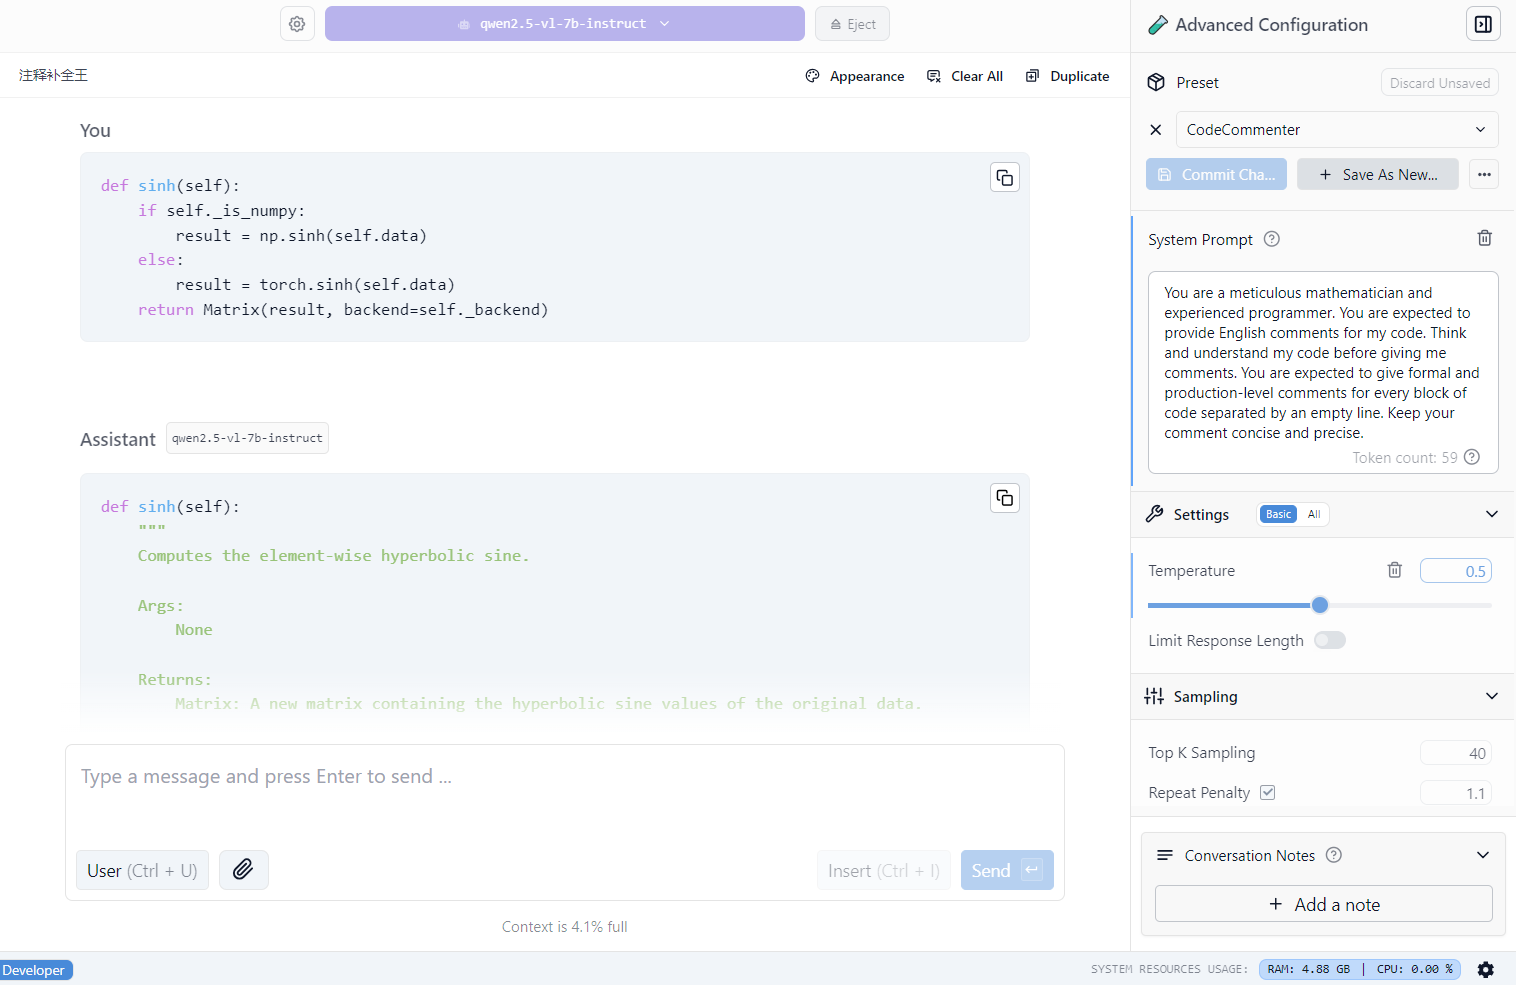

`1. Gradient Boosting Model Class using GBTree and Bootstrap (self-implemented)`

In [168]:
# This GradientBoostingModel class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Base Class for Gradient Boosting Models
class BaseGradientBoosting(Bagging, Boosting):
    
    __attr__ = "MML.BaseGradientBossting"
    
    def __init__(self, task: str = "regression", init_method: str = "mean", 
                 *, feature_names: Matrix | Tensor | None = None, **kwargs):
        """
        Initializes a Gradient Boosting model.

        This class represents a base gradient boosting algorithm, which fits multiple weak learners 
        (typically decision trees) on residuals to create a strong predictive model.  It inherits from the 
        'Boosting' base class and provides an optional way to specify feature names for improved interpretability.

        Args:
            task (str): one of {"classification", "regression"}, showing the learning task.
            init_method (str): The method name for creating the initial values. Can be used like an aggregation method.
                In fact, we just reshape the target result and use Aggregation classes to perform the initialization.
                for classification, recommended methods are {"mean", "hard_vote", "soft_vote", ...}
                for regression, recommended methods are {"mean", "median", "trimmed_mean", "quantile", ...}
            feature_names (Matrix | Tensor | None, optional): A Matrix or Tensor object containing strings representing the names of the features used by the model. 
                Defaults to None.  If provided, it should be a one-dimensional structure with a length equal to the number of columns in the data used for training.

        Attributes:
            feature_names (Matrix | Tensor | None): The feature names associated with the model, if provided during initialization.  Inherited from Ensemble.
            initial_values (Matrix | Tensor | None): The initial values for gradient boosting models, is None if not initialized. Can be computed by _compute_initial_values().

        Returns:
            None
        """
        
        # Feature Names should be a 1 dimension Matrix or Tensor object of strings
        # It should be equal to the number of columns of data.
        super().__init__(feature_names = feature_names)
        # Assigned in the base class - Ensemble
        
        # Record task name and initial method
        self.task = task
        self.init_method = init_method
        
        # Initial Values for the first round before fitting any GBTrees.
        # Matrix or Tensor type but left None if not initialized
        self.initial_values = None
    
    @staticmethod
    def _compute_initial_values(real_y: Matrix | Tensor, task: str = "regression", init_method: str = "mean", 
                                *, keepdims: bool = False, **kwargs) -> Matrix | Tensor:
        """
        Computes the initial values for gradient boosting models.
        
        This method calculates the initial predictions used as a starting point in the boosting process.
        It performs data validation and aggregation based on the specified task and initialization method.
        
        Args:
            real_y (Matrix | Tensor): The target variable matrix or tensor to compute initial values from.
            task (str, optional): The learning task ("classification" or "regression"). Defaults to "regression".
            init_method (str, optional): The aggregation method for computing initial values (e.g., "mean", "median"). Defaults to "mean".
            keepdims (bool, optional): Whether to keep the dimensions of the aggregated result. Defaults to False.
            **kwargs: Additional keyword arguments passed to the aggregation class.
        
        Returns:
            Matrix | Tensor: The computed initial values as a Matrix or Tensor.
        
        Raises:
            ValueError: If the input `real_y` is not a Matrix or Tensor, has an invalid shape (not 2D),
                        or contains integer data types instead of floating-point numbers.
        """

        # Type Check (must be an Object type).
        if isinstance(real_y, Object) == False:
            raise ValueError("Input real values must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        
        # Dimension Check
        if len(real_y.shape) != 2:
            raise ValueError("Input `real_y` must be a tabular data with two dimensions.")
        
        # Dtype Check, must be a float not int
        dtype = real_y.dtype
        if str(dtype) in ("int8", "int16", "int32", "int64"):
            raise ValueError("Input `real_y` must be a floatting type data instead of integers. Consider use .astype() to transform.")
        
        # Shape Detection (it is not 3D, then conduct transformation)
        shape_0 = real_y.shape[0]
        shape_1 = real_y.shape[1]
        stacked = real_y.reshape([shape_0, 1, shape_1])
        
        # Use Aggregation to perform the computation of initial values
        # In, fact, it just takes the mean/median/.. or soft_vote/hard vote 
        # to compute the average starting point in the boosting algorithm
        if task == "classification":
            agg = ClassificationAggregation(stacked, method = init_method, floattype = dtype, **kwargs).compute()
        else:
            agg = RegressionAggregation(stacked, method = init_method, floattype = dtype, **kwargs).compute()
        if keepdims == False:
            agg = agg.reshape([-1])
            
        return agg
    
    @staticmethod
    def _compute_pseudo_residuals(result: Tensor | Matrix, target: Tensor | Matrix, task: str = "regression", loss: str = "mse", **kwargs) -> Matrix | Tensor:  
        """
        Computes the pseudo-residuals (negative gradients scaled by the number of samples).
    
        This method calculates the pseudo-residuals based on the predicted values (`result`), true target values (`target`), 
        task type, and loss function. It leverages specialized metrics classes for regression and classification tasks to compute gradients.
    
        Args:
            result (Tensor | Matrix): The predicted values from the model.
            target (Tensor | Matrix): The true target values.
            task (str, optional): The learning task ("classification" or "regression"). Defaults to "regression".
            loss (str, optional): The loss function used during training. Defaults to "mse".
            **kwargs: Additional keyword arguments passed to the metrics classes.
    
        Returns:
            Matrix | Tensor: The computed pseudo-residuals.
    
        Raises:
            ValueError: If an invalid task is specified (other than "regression" or "classification").
        """
        
        # We don't do type checking here and it is handled internally by Metrics implementation.
        # We don't do loss validity checking since it will be handled by external class initializers.
        
        if task == "regression":
            gradients = RegressionMetrics(result = result, target = target, metric_type = loss, **kwargs).deriv_1(**kwargs)
        elif task == "classification":
            if result.shape[1] == 1:
                raise ValueError("We have detected a single column target in doing classification. Do you use a wrong task? Or convert your binary/multiclass into one_hot.")
            else:
                # raw scores F gradients before the softmax
                gradients = result - target
        else:
            raise ValueError("Invalid task. Task can only be either `regression` or `classification`.")
        
        # pseudo-residuals = negative gradients * n
        if task == "classification":
            return -gradients
        else:
            return -gradients * np.array(result.shape).prod()

    @staticmethod
    def _compute_pseudo_residuals_d1_and_d2(result: Tensor | Matrix, target: Tensor | Matrix, task: str = "regression", loss: str = "mse", **kwargs) -> tuple:  
        """
        Computes the pseudo-residuals (negative gradients scaled by the number of samples), and the grads and hessian matrix together.
    
        This method calculates the pseudo-residuals, gradients, and hessian, based on the predicted values (`result`), true target values (`target`), 
        task type, and loss function. It leverages specialized metrics classes for regression and classification tasks to compute gradients.
    
        Args:
            result (Tensor | Matrix): The predicted values from the model.
            target (Tensor | Matrix): The true target values.
            task (str, optional): The learning task ("classification" or "regression"). Defaults to "regression".
            loss (str, optional): The loss function used during training. Defaults to "mse".
            **kwargs: Additional keyword arguments passed to the metrics classes.
    
        Returns:
            Tuple of [Matrix | Tensor]: The computed pseudo-residuals, grads, hessian.
    
        Raises:
            ValueError: If an invalid task is specified (other than "regression" or "classification").
        """
        
        # We don't do type checking here and it is handled internally by Metrics implementation.
        # We don't do loss validity checking since it will be handled by external class initializers.
        
        if task == "regression":
            metric = RegressionMetrics(result = result, target = target, metric_type = loss, **kwargs)
            gradients = metric.deriv_1(**kwargs)
            hessian = metric.deriv_2(**kwargs)
        elif task == "classification":
            if result.shape[1] == 1:
                raise ValueError("We have detected a single column target in doing classification. Do you use a wrong task? Or convert your binary/multiclass into one_hot.")
            else:
                # raw scores F gradients before the softmax
                gradients = result - target
                hessian = result * (1.0 - result)
                # Formula:
                # grad = P - true_onehot
                # hess = P * (1 - P)
        else:
            raise ValueError("Invalid task. Task can only be either `regression` or `classification`.")
        
        # pseudo-residuals = negative gradients * n
        if task == "classification":
            resid = -gradients
        else:
            resid = -gradients * np.array(result.shape).prod()
        return resid, gradients, hessian

    @staticmethod
    def _softmax_and_standardize(raw: Matrix | Tensor, **kwargs):
        """
        Performs a row-wise softmax operation and standardizes the input matrix.
    
        Args:
            raw: Matrix | Tensor, The input matrix or tensor, which is raw scores 
                 in multi-classification before applied to softmax.
    
        Returns:
            Matrix: A new matrix containing the softmaxed and standardized values of the original data,
                    which is a one-hot like probability matrix.
    
        """
        # Row‐wise softmax of F, shape (n_samples, n_classes)
        raw_max = raw.max(axis = 1).reshape([-1, 1])
        raw_exp = (raw - raw_max).exp()
        # Standardize it into probability measure
        return raw_exp / raw_exp.sum(axis=1).reshape([-1, 1])
    
    @staticmethod
    def _log_prior_transform_one_hot(init_val_y: Matrix | Tensor, task: str = "regression", eps: float = 1e-16, **kwargs):
        """
        Transforms one-hot encoded or probability matrix data into log probabilities for classification tasks.
        
        This function is specifically designed to handle input data that represents either one-hot encoding or probability distributions 
        for classification problems. It converts these values to their natural logarithm (log) representation, which can be beneficial 
        for numerical stability and optimization in certain machine learning algorithms.  It only performs the transformation if the task
        is not regression.
        
        Args:
            init_val_y (Matrix | Tensor): The input data, expected to be a Matrix or Tensor representing one-hot encoded values or probabilities.
            task (str, optional): A string indicating the type of machine learning task. Defaults to "regression".  The transformation is only applied if the task is "classification".
            eps (float, optional): A small constant used for clipping the input values before taking the logarithm. This prevents errors due to log(0). Defaults to 1e-16.
            **kwargs: Additional keyword arguments that are not used in this function.
        
        Returns:
            Matrix | Tensor: The transformed data with log probabilities, or the original data if the task is regression.
        """
        
        # Only conduct the transformation if the task is doing regression
        # We only accept one-hot and probability matrix data in classification tasks
        if task != "classification":
            return init_val_y
        else:
            return init_val_y.clip(eps).log()
    
    @staticmethod
    def _softmax_post_transform_one_hot(raw_score_y: Matrix | Tensor, task: str = "regression", **kwargs):
        """
        Applies a post-softmax transformation and standardization to the raw scores if the task is classification.
        
        This method conditionally applies a softmax function followed by standardization to the raw score predictions 
        if the learning task is classification.  For regression tasks, it returns the input unchanged.
        
        Args:
            raw_score_y (Matrix | Tensor): The raw score predictions from the model.
            task (str, optional): The learning task ("classification" or "regression"). Defaults to "regression".
            **kwargs: Additional keyword arguments passed to the softmax and standardization function.
        
        Returns:
            Matrix | Tensor: The transformed raw scores if the task is classification; otherwise, the original input.
        """
        
        # Only conduct the transformation if the task is doing regression
        # We only accept one-hot and probability matrix data in classification tasks
        if task != "classification":
            return raw_score_y
        else:
            return BaseGradientBossting._softmax_and_standardize(raw_score_y, **kwargs)
        
    def __repr__(self):
        return "BaseGradientBossting(Abstract Class)."
    
    
# Implementation for Greadient Boosting Model
class GradientBoostingModel(BaseGradientBoosting):
    
    __attr__ = "MML.GradientBoostingModel"
    
    def __init__(self, task: str = "classification",
                       loss: str | None = None,
                       init_method: str = "mean",
                       *,
                       tree_type: type = CART,
                       n_estimators: int = 10,
                       max_features: str | int | float | None = 0.8,
                       bootstrap_ratio: float = 0.8,
                       replace: bool = True,
                       shuffle: bool = True,
                       eps: float = 1e-16,
                       tol: float = 1e-8,
                       lr: float = 1e-1,      
                       step_size: str = "newton",
                       l2_lambda: float = 1e-6,
                       floattype: type = float,
                       random_state: int | None = None,
                       feature_names: Matrix | Tensor | None = None,
                       tree_kwargs: dict = {},
                       agg_kwargs: dict = {},
                       **kwargs) -> None:
        """
        Initialize a Gradient Boosting Model using boosting methods on weak learners.
        
        Parameters
        ----------
        task: str, one of {"classification", "regression"}, showing the learning task.
        loss: str, the name of the loss function of the Gradient Model, can be a str or left None.
              If left None, we will adjust it to "mse" if regression, "logloss" if classification.
             (not the loss for the tree, if you intend to set the loss for trees, set them in `tree_kwargs`)
        init_method: str, the name of initial method (actually using aggregation method). See aggregation.py.
                    for classification, common ones are: "mean", "hard_vote", "soft_vote", ...
                    for regression, common ones are: "mean", "median", "percentile", "weighted", ...
        Optional:
            tree_type: type, showing the type of trees you intend to use. Default, CART (Classification and Regression Tree). 
                       You may pass in some other tree-compatible classes, like LRTW.
            n_estimators : int, indicating the maximum number of trees.
            max_features : {None, "sqrt", "log2", "over3"} | int | float, number of columns available to each tree.
            bootstrap_ratio : float, fraction of samples drawn per bootstrap sample, [0, 1].
            replace, shuffle : bool, if to shuffle the bootstrapped samples, passed to `_sample_bootstrapping`.
            eps: float, a very small amount to avoid dividing by 0.
            tol: float, tolerence for convergence when optimizing.
            lr: float, learning rate. Default 1e-2.
            step_size: str, name of methods to step_size calculation, can be {
                       "constant" (to use 1), 
                       "newton" (Newton's method to find the step_size), 
                       "xgboost" (XGBoost-like leaf-wise Newton's method (Not Implemented Yet)),
                    or "numerical" (to numerically search (Not Implemented Yet))}
            l2_lambda: float, the l2 regularization parameter to avoid overfitting. Default 1e-6.
            floattype : type, numerical precision stored in internal matrices.
            random_state : int | None, global seed for reproducibility.
            feature_names : Matrix | Tensor | None, optional feature labels, in Object type. May be useful in feature importance.
            tree_kwargs : dict, extra hyperparameters forwarded to every tree model.
            agg_kwargs : dict, extra hyperparameters forwarded to the aggregation instance (in initialization).
            **kwargs: other key word arguments, reserved for compatibility use.
        """
        
        super().__init__(task=task, init_method=init_method, feature_names=feature_names, **kwargs)

        # Loss Function and init method
        if loss is None:
            self.loss = "mse" if task == "regression" else "logloss"
        else:
            self.loss = loss
        self.init_method = init_method
        
        # Gradient Related Variables (lr/tol)
        self.lr = lr     # Learning rate for gradient boosting
        self.tol = tol   # Tolerance for grad and line search
        self.eps = eps   # When used in newton and xgboost mode to prevent g/h = 0
        
        # Gradient Boosting Data ROW/COL settings
        self.max_features = max_features
        if  max_features is None:
            max_features = 1.0
        self.bootstrap_ratio = float(bootstrap_ratio)
        if self.bootstrap_ratio > 1.0 or self.bootstrap_ratio <= 0.0:
            raise ValueError("Extrapulate for bootstrap ratio is NOT allowed. You must set a value in (0, 1]")
            
        # Bootstrap and Feature Selecting arguments
        self.replace = replace
        self.shuffle = shuffle
        
        # Gradient Descent regularization
        if step_size.lower() not in ("constant", "newton", "xgboost", "numerical"):
            raise ValueError(f"Parameter `step_size` must be on of ('constant', 'newton', 'xgboost', 'numerical') but you have f{step_size}.")
        if step_size.lower() in ("xgboost", "numerical"):
            raise NotImplementedError((f"Step size method {step_size.lower()} is not implemented."))
        if step_size.lower() == "xgboost":
            # We should make sure that the tree instance has `apply` attribute
            try:
                _ = tree_type().apply
            except AttributeError as e:
                raise ValueError(f"When `step_size` set to `xgboost`, you have to use a base tree with method `apply` that returns the index of the leaf node a sample belongs to. But your `tree_type` does not have this.")
        self.step_size = step_size.lower()    # The way step size is calculated
        self.l2_lambda = l2_lambda            # L2 lambda when calculating the step size
        
        # Gradient Boosting Key arguments
        self.n_estimators = int(n_estimators) # Specified Number of Estimators
        self.n_estimators_used = 0            # Trainned Number of Estimators
        # Note, early stopping may prevent using all of the estimators
        
        # Global random_state (Use _random_state_next() to move it forward)
        self.random_state = random_state

        # Type Related Variables.
        self.tree_type = tree_type
        if isinstance(self.tree_type(), BaseTree) == False:
            raise ValueError(f"The given weak leaner type {tree_type} must be a child class of BaseTree.")
        self.floattype = floattype
        self.typeclass = None # Determined in fit()

        # KWargs for Trees and Aggregation
        self.tree_kwargs = tree_kwargs
        self.agg_kwargs = agg_kwargs   
        self.kwargs = kwargs
        
        # Original Dataset.
        self.original_X = None
        self.original_y = None
        
        # Processed Datasets.
        self._feature_sets = {}      # Key: tree id, starting from 0
                                     # Value: feature indices used
        self._bootstrapped = {}      # Key: tree id, starting from 0
                                     # Value: bootstrapped data tuple (see. ensemble.py)
        
        # Runtime Containers (Gradient Booster Ensemble).
        self._estimators = {}        # Key: tree id, starting from 0
                                     # Value: tree instance
    
        # Runtime Containers (Step Sizes).
        self._step_sizes = {}        # Key: tree id, starting from 0
                                     # Value: step_size, in Matrix or Tensor, a scalar per output or same to y shape

        # Runtime Containers (Incremental Updates by each tree).
        self._inc_updates= {}        # Key: tree id, starting from 0
                                     # Value: prediction by each tree using the training X

    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor,
            *,
            one_hot: bool = True,
            verbosity: int | None = None,
            evalset: Dict[str, Tuple[Matrix | Tensor, Matrix | Tensor]] | None = None,
            evalmetrics: List[str] | str | None = None,
            early_stop: int | None = None,
            early_stop_logic: str = "some",
            continue_to_train: bool | None = None,
            **kwargs):
        """
        Train n_estimators gradient boosting trees sequentially.
        
        Evaluation Remark:
            ----------
            You may want to evaluate datasets while training. If so, please do the following things:
                1. set `verbosity` = 1 to print the evaluation
                2. set the `evalset` to a dict of tuples of your dataset that is going to be evaluated
                3. set the `evalmetrics` either to a string of metrics or a list of strings
            You may want the algorithm to decide to stop training automatically. If so, please do things above, plus:
                1. set `early_stop` to a number of batches, like 1 or 2, which acts like: 
                    if the metrics for all/some/any/most of the evaluation sets do not decrease anymore, 
                    the training process will be terminated and return
                2. set `early_stop_logic` to determine the way of processing non-decreasing datasets/metrics
                3. If you hope to continue to train again, call this `fit` again with `continue_to_train` set to True

        Parameters:
            ----------
            X: Matrix | Tensor, the feature matrix (each row is a sample).
            y: Matrix | Tensor, the target values (for regression, numerical; for classification, one-hot or multi-label).
            Optional:
                one_hot : bool, if y is one-hot encoded for classification tasks.
                verbosity: int | None, if >= 1 and having `evalset`, then will report metrics each batch.
                evalset: Dict[name : Tuple[X, y],
                              ...], | None, if provided, it may be used as evaluation set. XGBoost style.
                evalmetrics: list of str | str | None, metrics used to do the evaluation. Will be printed.
                early_stop: int | None, if non-None, then if metrics NOT gained for `early_stop` times, the forest will stop training.
                early_stop_logic: str, the logic when deciding on multiple metrics, can be {"any", "some", "most", "all"}.
                continue_to_train: bool | None, if non-None and True, the machine will try to restore the place it was and continue
                                   to train new estimators until a new stopping criterion meets or until reaches the max number of allowed estimators.
                
        Returns:
            ----------
            self
        """

        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check.
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one label or value, use data.reshape([-1, 1])")
                    
        # Special logic Check: If classification, then must be one_hot.
        if self.task == "classification" and y.shape[1] == 1:
            raise ValueError("Input target `y` only have 1 column while you are using `classification` mode. Please notice Gradient Boosting only support one-hot coding. Consider transforming your target into a one-hot two column dataset.")
            
        # Stopping Logic Check.
        if early_stop_logic not in ("any", "some", "most", "all"):
            raise ValueError("Stopping logic `early_stop_logic` must be one of ('any', 'some', 'most', 'all')")
            
        # Prepare the bootstrapped sampeles and initial values
        self._fit_prep(X = X, y = y, continue_to_train = continue_to_train)
        n_samples, n_features = X.shape
        
        # Expanded Initial Values
        expanded_init_vals = self.initial_values.repeat(n_samples, axis = 0)
        y_pred = expanded_init_vals.copy()
        # y_pred is the current prediction for ALL samples (not subsamples)
        
        # Special evalmetrics type conversion
        if isinstance(evalmetrics, str) == True:
            evalmetrics = [evalmetrics]
            
        # Verbosity Conversion
        verbosity = verbosity if verbosity is not None else 0
        
        round_ = 0
        tree_id = 0
        undecreased_no = 0
        last_eval_dict = {} # Please use deepcopy() here to avoid being errorly referred
        
        # Continue to train? Restore the last point
        if continue_to_train is not None:
            
            # In boosting, it is NOT simply to train new trees but to 
            # continue to train on the unexplained residuals.
            # We should first restore the prediction by adding predictions of the 
            # previous trees up.
            if continue_to_train == True and self.n_estimators_used > 0:
                # Copy the tree_id
                tree_id = self.n_estimators_used
                
                # Expand the y_pred by adding things up with
                # += lr * step_size * updates
                for i in range(tree_id):
                    # Note, this step can be replaced by calling one predict
                    # on the training data by previous trees.
                    y_pred += self.lr * self._step_sizes[i] * self._inc_updates[i]
        
        # Helper: Print and decide the evaluated results
        def _decide_stop_with_print(batch: int, undecreased_no: int, eval_dict: dict, last_eval_dict: dict, **kwargs):
            """
            Compare the metics and decide if stop or not.

            Parameters
                ----------
                batch: int, batch no, for printing uses.
                undecreased_no : int, cumulative number that loss did NOT decrease before evaluation.
                eval_dict : dict, the passed evaluation dict.

            Returns
                -------
                Tuple of (int, bool):
                    int, updated undecreased_no
                    bool, whether to stop (True) training or continue (False)

            """
            # Dict is empty, abort
            if len(eval_dict) == 0:
                return undecreased_no, False
            if len(last_eval_dict) == 0:
                return undecreased_no, False
            
            # Difference dict copy
            diff_dict = deepcopy(eval_dict)
            
            # Calculate the difference (this - last)
            # and
            # If verbosity, print the new evaluation dict
            undes_count = 0
            allmetric_count = 0
            for evalset_name in eval_dict.keys():
                eval_result = eval_dict[evalset_name]
                if verbosity >= 1:
                    print("Evalset: [", evalset_name, " : Metrics {", end = " ", sep = "")
                for metric_name in eval_result.keys():
                    metric_value = eval_result[metric_name]
                    diff_dict[evalset_name][metric_name] = metric_value - last_eval_dict[evalset_name][metric_name]
                    if diff_dict[evalset_name][metric_name].to_list() > 0:
                        undes_count += 1
                    allmetric_count += 1
                    if verbosity >= 1:
                        print(metric_name, ":", round(metric_value.to_list(), 4), ", ", end = " ", sep = "")
                if verbosity >= 1:
                    print("}]", end = "\n")
                    
            # If no early stop, directly return 0, False
            if early_stop is None:
                return 0, False
                    
            # If meets the requirement, stop training
            if early_stop_logic == "any":
                if undes_count > 0:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
            elif early_stop_logic == "some":
                if undes_count * 3 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
            elif early_stop_logic == "most":
                if undes_count * 2 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
            elif early_stop_logic == "all":
                if undes_count * 1 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
                    
            # If survives here, return 0, False to refresh the undecreased_no
            return 0, False
                
        # Helper: Train one round pipeline
        def _train_one_round_pipeline(X: Matrix | Tensor, y: Matrix | Tensor, y_current_predicted: Matrix | Tensor, tree_id: int, **kwargs):
            """
            Train for one round and return the new prediction and updates.
            
            Returns
                -------
                Tuple of (Matrix | Tensor, Matrix | Tensor):
                    Matrix | Tensor, new y_pred after applied updates
                    Matrix | Tensor, the new updates

            """
            # y_pred create a copy to avoid modification issues
            y_pred = y_current_predicted.copy()
            
            ###################################################################
            #
            # Preparion
            # Collect the data used to train in this round
            X_selected, y_selected, row_indices = self._bootstrapped[tree_id]
            feature_idx = self._feature_sets[tree_id]
            
            # If classification, then perform softmax on the y_pred to calculate residuals
            probabilities = self._softmax_post_transform_one_hot(y_pred, task = self.task, **kwargs)

            # Calculate pseudo residuls and leave gradients, hessian None
            if self.step_size in ("constant", "numerical"):
                residuals = self._compute_pseudo_residuals(result = probabilities, target = y,
                                task = self.task, loss = self.loss, **kwargs)
                gradients, hessian = None, None # A sugar to achieve code simplicity
            
            # Calculate pseudo residuls as -gradient/hessian
            elif self.step_size in ("newton", "xgboost"):
                # First compute the elements
                residuals, gradients, hessian = self._compute_pseudo_residuals_d1_and_d2(result = probabilities, target = y,
                                task = self.task, loss = self.loss, **kwargs)
                # Then, compute the -g/h residuals
                residuals = - gradients / (hessian + self.l2_lambda + self.eps)
            
            ###################################################################
            #
            # Train
            # Sequentially train the trees on the psuedo residuals (only use a subsample)
            self._train_one_gbtree(X = X_selected, 
                                   y_resid = residuals[row_indices.to_numpy_array()], 
                                   weights = None if hessian is None else hessian[row_indices.to_numpy_array()], 
                                   tree_id = tree_id, one_hot = one_hot, feature_idx = feature_idx, **kwargs)
            
            # !!!
            # Note: We should use the entire data when calculating the _backward_step_size and updates
            # Adjust the step_size for this tree and return the tuple (lr, updates, step_size)
            lr, updates, step_size_i = self._backward_step_size(X = X, y_pred = y_pred, tree_id = tree_id, 
                    one_hot = one_hot, gradients = gradients, hessian = hessian, **kwargs)
            
            # Update the y_preds based on formula += lr * step_size_i * updates
            y_pred += lr * step_size_i * updates
            
            return y_pred, updates
            
        #######################################################################
        #        
        # Build up the gradient boosting trees sequentially
        while tree_id < self.n_estimators:
            
            # Verbosity
            if verbosity >= 1:
                print(f"Training on Round: {round_}, starting from tree: {tree_id} trainned on the residuals...")
            
            ###################################################################
            #
            # Train one pipeline
            y_pred, updates = _train_one_round_pipeline(X, y, y_pred, tree_id = tree_id, **kwargs)
            
            # Finished trainning and add the tree_id
            # You must do it here to avoid self-increased before calculating the step size
            tree_id += 1
                    
            ###################################################################
            #
            # Gradient Exition
            # If the total updates are too small, then exit the training process
            if updates.abs().sum().to_list() < self.tol:
                break
            
            ###################################################################
            #
            # Evaluation
            # Evaluate and decide if stop training from now
            eval_dict = self._eval_one_batch(evalset = evalset, evalmetrics = evalmetrics, one_hot = one_hot, **kwargs)
            
            # Try stop maker and receive the advice
            undecreased_no, decision = _decide_stop_with_print(round_, undecreased_no = undecreased_no, eval_dict = eval_dict, last_eval_dict = last_eval_dict)
            
            # Copy last evaluated dict
            last_eval_dict = deepcopy(eval_dict)
            
            # Count self increasing
            round_ += 1
            
            # Make decision to terminate or not
            if decision == True:
                break
            
        return self
                
    def _fit_prep(self, X: Matrix | Tensor, y: Matrix | Tensor, continue_to_train: bool = False, **kwargs):
        """
        Prepare datasets and calculate initial values (for regression tasks and classification tasks).

        Parameters:
            ----------
            X: Matrix | Tensor, the feature matrix (each row is a sample).
            y: Matrix | Tensor, the target values (for regression, numerical; for classification, one-hot or multi-label).
            continue_to_train: bool, if False then not refresh the data, else only conduct type checking.
        
        Returns:
            ----------
            self
        """
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check.
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one label or value, use data.reshape([-1, 1])")
        
        # If newly added data, do the full initialization
        if continue_to_train == False or continue_to_train is None:
        
            # Copy Training data.
            self.original_X = X.to(backend=X._backend, dtype = self.floattype, device=X.device)
            self.original_y = y.to(backend=y._backend, dtype = self.floattype, device=y.device)
            
            # Resolve Number of Features for each weak learner.
            n_samples, n_features = X.shape
            self.max_features = self._resolve_max_features(n_features, q = self.max_features)
            
            # Bootstrap row indices, generate row-sliced subsets.
            # Prepare all n_estimators even somethimes not fully used.
            self._bootstrapped = self._sample_bootstrapping(
                X, y,
                M = self.n_estimators,
                k = self.bootstrap_ratio,
                replace = self.replace,
                shuffle = self.shuffle,
                random_state = self._random_state_next(),
                container = dict)

            # Retrieve the subset of features.
            # Prepare all n_estimators even somethimes not fully used.
            self._feature_sets = self._feature_random_select(
                M = self.n_estimators,
                N = n_features,
                q = self.max_features,
                replace = False,  # Default standarad
                random_state = self._random_state_next(),
                container = dict)
            
            # Restore trained trees and trained numbers
            self._estimators = {}
            self._step_sizes = {}
            self._inc_updates = {}
            self.n_estimators_used = 0
            
            # Calculate the initial value
            self.initial_values = self._compute_initial_values(real_y = y, 
                            task = self.task, init_method = self.init_method, keepdims = True, **kwargs)
            self.initial_values = self._log_prior_transform_one_hot(self.initial_values, task = self.task, **kwargs)
            
        return self

    def _resolve_max_features(self, n_features_all: int, q: int | float | str | None, **kwargs) -> int:
        """
        Translate max_features spec into an integer 1 ≤ q ≤ n_features_all.
        
        Parameters:
            ----------
            n_features_all: int, number of total features you have.
            q: int | float | str | None, feature number/proportion/description or None
        
        Returns:
            ----------
            int, number of features selected (parsed from the input, which may not be an int)
        """
        p = n_features_all
        
        # String: sqrt or log2
        if isinstance(q, str):
            q = q.lower()
            if q == "sqrt":
                return max(1, int(p ** 0.5))
            if q == "log2":
                return max(1, int(math.log2(p)))
            if q == "over3":
                return max(1, int(p // 3))
            raise ValueError("Resolving the max features, max_features `q` may be None, int, 'sqrt', or 'log2'")
        if isinstance(q, int):
            if q <= 0:
                raise ValueError("Resolving the max features, max_features `q` must be positive")
            return min(q, p)
        if isinstance(q, float):
            if q > 1:
                raise ValueError("Resolving the max features, max_features `q` must be less than 1 if float type")
            return max(1, int(p * q))
        raise ValueError("Unsupported max_features `q` type. Coult be int, float, str and None")

    def _train_one_gbtree(self, X: Matrix | Tensor, y_resid: Matrix | Tensor, weights: Matrix | Tensor | None, tree_id: int, one_hot: bool, feature_idx: np.ndarray, *, _mutex : Mutex | None = None, **kwargs) -> None:
        """
        Train one gradient boosting tree based on the split data.

        Parameters
        ----------
            X: Matrix | Tensor, the feature matrix (each row is a sample).
            y_resid: Matrix | Tensor, the target values (peuedo residuals, NOT the actual label).
            weights: Matrix | Tensor | None, the weights used to split the tree or to create the leaf nodes.
            tree_id : int, the tree_id you expect to train.
                      The tree must NOT be initialied, else error.
            one_hot: bool, if classification and using one-hot coding.
            feature_idx: np.ndarray, the indices of used features in training. 

        Returns
            -------
            None.

        """
        # Tree id validity check
        if tree_id > self.n_estimators:
            raise ValueError(f"You are training tree_id {tree_id}, but you only have {self.n_estimators} reserved.")
        
        # If the tree is trained
        if self._estimators.get(tree_id, None) is not None:
            raise ValueError(f"You are training tree_id {tree_id}, but the tree has been already trained.")
            
        # Process the tree kwargs. You should NOT specify the task/loss, if so, then ValueError
        if self.tree_kwargs is not None:
            if "task" in self.tree_kwargs:
                raise ValueError(f"You should never specify any `task` in the tree kwargs since the mode must be automatically decided by the gradient boosting tree. You have {self.tree_kwargs['task']} now.")
            if "loss" in self.tree_kwargs:
                raise ValueError(f"You should never specify any `loss` in the tree kwargs since the mode must be automatically decided by the gradient boosting tree. You have {self.tree_kwargs['loss']} now.")
                
        # Train one gradient boost tree using MSE or WMSE
        if weights is not None:
            tree = self.tree_type(task = "regression", tree_id = tree_id, loss = "wmse",
                                  random_state = self._random_state_next(), floattype = self.floattype, feature_names = self.feature_names, **self.tree_kwargs)
        else:
            tree = self.tree_type(task = "regression", tree_id = tree_id, loss = "mse",
                                  random_state = self._random_state_next(), floattype = self.floattype, feature_names = self.feature_names, **self.tree_kwargs)
        tree.fit(X, y_resid, one_hot = one_hot, use_features_idx = feature_idx, weights = weights, **kwargs)

        # Apply lock to protect the resources
        if _mutex is not None:
            with _mutex:
                self._estimators[tree_id] = tree
                self.n_estimators_used += 1
            return
        else:
            self._estimators[tree_id] = tree
            self.n_estimators_used += 1

        return
    
    def _backward_step_size(self, X: Matrix | Tensor, y_pred: Matrix | Tensor, tree_id: int, one_hot: bool,
                             gradients: Matrix | Tensor | None = None, hessian: Matrix | Tensor | None = None, *, _mutex : Mutex | None = None, **kwargs) -> tuple:
        """
        Calculate the step size and compute the addition values on the backward step.

        Parameters
        ----------
            X: Matrix | Tensor, the feature matrix (each row is a sample).
            y_pred: Matrix | Tensor, the accumulated, unupdated predictions before training this tree.
            tree_id: int, the tree_id you expect to train.
                     The tree must NOT be initialied, else error.
            one_hot: bool, if classification and using one-hot coding.
            gradients: Matrix | Tensor | None, the gradient matrix calculated, can be None in `constant` mode.
            hessian: Matrix | Tensor | None, the hessian matrix (hessian vector without cross terms) calculated, can be None in `constant` mode.

        Returns
            -------
            Tuple[lr, updates, step_size] calculated.
                lr is scalar,
                updates is Matrix | Tensor with y shape,
                step_size is Matrix | Tensor processed into y shape or a scalar.

        """
        # Tree id validity check
        if tree_id > self.n_estimators:
            raise ValueError(f"You are training tree_id {tree_id}, but you only have {self.n_estimators} reserved.")
        
        # If the tree is ont trained
        if self._estimators.get(tree_id, None) is None:
            raise ValueError(f"You are trying to create the updates and step size on tree_id {tree_id}, but the tree has NOT been trained. First train the tree.")
        tree = self._estimators[tree_id]
        
        # If it is updated and calculated
        if self._inc_updates.get(tree_id, None) is not None:
            raise ValueError(f"You are trying to create the updates and step size on tree_id {tree_id}, but they are existed.")
        if self._step_sizes.get(tree_id, None) is not None:
            raise ValueError(f"You are trying to create the updates and step size on tree_id {tree_id}, but they are existed.")
            
        # Check the status of gradients and hessian
        # They should be given in non-constant mode and should be None in constant mode
        if self.step_size in ("constant", "numerical"):
            if gradients is not None or hessian is not None:
                raise ValueError(f"In creating the updates and calculating the step size for tree_id {tree_id}, you have constant step_size but given a gradient/hessian matrix.")
        elif self.step_size in ("newton", "xgboost"):
            if gradients is None or hessian is None:
                raise ValueError(f"In creating the updates and calculating the step size for tree_id {tree_id}, you have {self.step_size} method to estimate the step_size but left gradient/hessian as Nonetype.")
                
        # First, predict the updates on the new train
        updates = tree.predict(X, **kwargs)
        
        # These variables are to be returned
        lr = self.lr
        round_updates = updates
        round_step_size = updates.ones([1], backend = updates._backend, dtype = updates.dtype).to(backend = updates._backend, dtype = updates.dtype, device = updates.device)
        # shape (1) Scalar
        
        # If constant mode, use the default arguments
        if self.step_size == "constant":
            pass
        
        # Numerical is NOT implemented
        elif self.step_size == "numerical":
            raise NotImplementedError("Step size updating method `numerical` is NOT implemented. Consider using `newton` or `xgboost` instead.")
            
        # If Newton's method, implement a output-wise step size and broadcast it to sample wise
        elif self.step_size == "newton":
            # In newton's method, we have already fit the tree on -g/h, so let step_size = 1
            pass
            
        # If XGBoost method, implement a leaf-wise step size and broadcast it to sample wise
        elif self.step_size == "xgboost":
            # In xgboost method, we conduct a leaf-wise step size calculation and let step_size = 1 * step_size
            pass
            # Not Completely implemented yet
            # 1. Needs to store the lwgammas and search and match the leaf zones in predicting
            # 2. set the scaling gamma = 1
            
            # XGBoost method to update the leaf-wise step_size for all samples (n, d)
            def _xgboost_backward(g, h, updates, l2, axis):
                # Calculate the node indices and representations
                # The indices is a 1 column 2 dimensional [-1, 1] Matrix | Tensor
                node_indices, node_repr = tree.apply(X, **kwargs)
                
                # Transform the node indices into a 1d array
                node_indices = node_indices.flatten()
                
                # Convert the indices to a 1 dimensional unique Container
                node_indices_unique = node_indices.unique()
                
                # Leaf-wise Step_size (gamma)
                lw_gammas = {}
                for leaf in node_indices_unique:
                    mask = (node_indices == leaf) 
                    if axis is not None:
                        g_sum = g[mask].sum(axis=axis)       # shape (d,)
                        h_sum = h[mask].sum(axis=axis)       # shape (d,)
                    else:
                        g_sum = g[mask].sum().reshape([1]).repeat(g.shape[0], axis=0).reshape([1, -1])
                        h_sum = h[mask].sum().reshape([1]).repeat(g.shape[0], axis=0).reshape([1, -1])
                    lw_gammas[leaf] = - g_sum / (h_sum + l2) # shape (d,)
                    
                # Vstack to create a full ranged step_size
                gamma_mat = lw_gammas[node_indices[0]]
                gamma_mat = gamma_mat.vstack(*[lw_gammas[l] for l in node_indices[1:]])
                # After this # shape (n, d)
                return lw_gammas, gamma_mat
        
            # Calculate xgboost backward
            if self.task == "classification":
                lw_gammas, round_step_size = _xgboost_backward(gradients, hessian, updates, l2 = self.l2_lambda, axis = None)
            else:
                lw_gammas, round_step_size = _xgboost_backward(gradients, hessian, updates, l2 = self.l2_lambda, axis = 0)

        # Unknown step_size method
        else:
            raise ValueError("Unknown `self.step_size`. Make sure you choose one valid step_size name. Refer to __init__ for more information.")
                    
        # Add the updates (inc) and step_size to class members
        if _mutex is not None:
            with _mutex:
                self._inc_updates[tree_id] = round_updates.copy()
                self._step_sizes[tree_id] = round_step_size.copy()
            return
        else:
            self._inc_updates[tree_id] = round_updates.copy()
            self._step_sizes[tree_id] = round_step_size.copy()
            
        return lr, round_updates, round_step_size
            
    def _eval_one_batch(self, evalset: Dict[str, Tuple[Matrix | Tensor, Matrix | Tensor]] | None = None, evalmetrics: List[str] | str | None = None, one_hot: bool = True, **kwargs):
        """
        Evaluate the `evalset` after training for one batch.    

        Returns
            -------
            result_dict : dict  # Key: evalset name
                                # Value dict {metric_name: metric_value}
            or 
            {} if failed or did not evaluate
        """
        # If:
        # 1. sequential_batch non-None
        # 2. evalset is at least len = 1
        # 3. evalmetrics is non-None and at least len = 1
        # Do evaluation
        result_dict = {}
        if evalmetrics is not None and evalset is not None:
            if len(evalset) > 0 and len(evalmetrics) > 0:
                # Record the result for each eval group
                result_dict = {}    # Key: evalset name
                                    # Value dict {metric_name: metric_value}
                for eval_name in evalset.keys():
                    X_sub, y_sub = evalset[eval_name]
                    y_pred = self.predict(X_sub)
                    
                    # Inner metric dict, for values of result dict
                    metrics = {}
                    for metric_name in evalmetrics:
                        
                        # Evaluation: regression
                        if self.task == "regression":
                            eval_metric = RegressionMetrics(y_pred, y_sub, metric_type = metric_name).compute()
                            # Matrix | Tensor
                        
                        # Evaluation: this is classification
                        else:
                            if (y_pred.shape[1] == 2 and one_hot == False) or y_pred.shape[1] == 1:
                                # Binary and non-one hot
                                eval_metric = BinaryClassificationMetrics(self._to_binary_prob(y_pred), y_sub, metric_type = metric_name).compute()
                            else:
                                # Since the aggregation output is alway one-hot, use Multiple then
                                eval_metric = MultiClassificationMetrics(y_pred, y_sub, metric_type = metric_name).compute()
                            # Matrix | Tensor
                        metrics[metric_name] = eval_metric
                    # For all metrics, put them into result_dict
                    result_dict[eval_name] = metrics
        
        # If it is empty, then exit since nothing valid
        if len(result_dict) == 0:
            return {}
        
        # Else, return the dict
        else:
            return result_dict

    def predict(self, X: Matrix | Tensor, **kwargs) -> Matrix | Tensor:
        """
        Predict target values for samples in X.
        If classification, the output must be one-hot (even binary cases). Please kindly note.
        To convert one-hot to labels, use ._to_labels()
        
        Returns:
            Matrix | Tensor, output of predictions.
        """
        
        # Check if the model has (at least partially) fitted or not
        if self._is_fitted() == False:
            raise RuntimeError("No weak learner is fitted. Call .fit() before .predict()")
            
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if X.shape[1] != self.original_X.shape[1]:
            raise ValueError(f"Input feature `X` must have the same number of columns as the training data, which is {self.X.shape[1]}, but you have {X.shape[1]}")
                
        # Get the initial prediction over samples
        y_pred = self.initial_values.repeat(X.shape[0], axis = 0)

        # Iteratively predict
        for tree_id in self._estimators.keys():
            # Retrieve the estimator (tree)
            estimator = self._estimators[tree_id]
            
            # We here need to use different ways to treat the step_size:
            # If "constant", "newton" type, it is a [1, -1] size, we need to repeat on x axis
            if self.step_size in ("constant", "newton", "numerical"):
                step_size = self._step_sizes[tree_id].copy()
            elif self.step_size in ("xgboost"):
                pass # Need to implement
            
            y_pred += self.lr * step_size * estimator.predict(X)
        
        # If uses classification, apply softmax (automatically handled)
        return self._softmax_post_transform_one_hot(y_pred, task = self.task, **kwargs)
    
    def _is_fitted(self) -> bool:
        """
        Check if the Gradient Boosting Model has been fitted or not.

        Returns
            -------
            bool, if the model is fitted or not.

        """
        return True if len(self._estimators) > 0 else False

    def update_tree_kwargs(self, tree_kwargs : dict | None = None, **kwargs) -> None:
        """
        Update the tree-build key word arguments in whole.
        If you hope to replace or remove, please first get and then set by this.

        Returns
            -------
            None

        """
        if tree_kwargs is not None:
            # Check the new arguments
            if "task" in tree_kwargs:
                raise ValueError(f"You should never specify any `task` in the tree kwargs since the mode must be automatically decided by the gradient boosting tree. You have {tree_kwargs['task']} now.")
            if "loss" in tree_kwargs:
                raise ValueError(f"You should never specify any `loss` in the tree kwargs since the mode must be automatically decided by the gradient boosting tree. You have {tree_kwargs['loss']} now.")
                
            # Assign if passed
            self.tree_kwargs = tree_kwargs
            
    def update_agg_kwargs(self, agg_kwargs: dict | None = None, **kwargs) -> None:
        """
        Update the aggregation related key word arguments in whole.
        If you hope to replace or remove, please first get and then set by this.

        Returns
            -------
            None

        """
        if agg_kwargs is not None:
            self.agg_kwargs = agg_kwargs

    def __repr__(self):
        return f"GradientBoostingModel(task = {self.task}, loss = {self.loss}, tree_type = {str(self.tree_type)}, n_estimators = {self.n_estimators})."
    
               
# Alias for Gradient Boosting Model
GBM = GradientBoostingModel

# !!!
# Comments about points in the 1st part of this assignment:
# 
# > Implement regression trees with: MSE-based splitting
# ---> This Gradient Boosting Model uses a REVISED CART tree with the support of samples weights. See `CART`.
# ---> The splitting criterion can be different when running in the regression mode, supporting MSE or WMSE (Weighted MSE).
# ---> Moreover, in either MSE or WMSE mode, it supports grid search to speed up the process of finding the optimal threshold.
# ---> If you are interested in splitting criteria, see CART._find_best_split() for more information.
#
# > Implement regression trees with: Support for max depth and minimum samples per split
# ---> This Gradient Boosting Model uses a REVISED CART tree with the support of samples weights. See `CART`.
# ---> Max Depth and Minimum Samples are natively supported by CART.
# ---> When splitting new branches, the tree will first detect if the regularization criterion is met or not.
# ---> If you are interested in regularization criteria, see CART._build_tree() for more information.
#
# > Implement regression trees with: Recursive tree building and prediction
# ---> This Gradient Boosting Model uses a REVISED CART tree with the support of samples weights. See `CART`.
# ---> As implemented as the original form, the fitting and predicting processes are invoked recursively.
# ---> When you call fit(), it will call _build_tree() and the _build_tree() will recursively call itself until one regularization rule meets.
# ---> When you call predict(), it will call _predict_recursive() and the _predict_recursive() will also
# ---> recursively call itself ultil it goes to the terminal leaf nodes.
# ---> See CART._build_tree() and CART._predict_recursive() for more information.
#
# > Implement gradient boosting with: Residual fitting at each stage
# ---> Gradient Boosting Model supports either first-order gradient boosting and like xgboost, the second order.
# ---> The difference is the way to calculate residuals and how to fit the new weak learners on the residuals.
# ---> In "constant" mode, it always use the first order gradients and update the trees with negative gradients,
# ---> and in "newton"'s mode, it uses a quassi-second order gradients and fit the tree on -g/h to scale the step size by its hessian.
# ---> Obviously, "newton"'s method converges significantly faster and always outperforms the sklearn gradient boosting models.
# ---> If you are interested in how residuals are fitted, see GradientBoostingModel.fit() for more information.
#
# > Implement gradient boosting with: Learning rate control and iterative updates
# ---> Learning rates can always be set in the __init__ method. Although we did not support learning rate schedule (
# ---> since I have found in later iterations, the model seems learning too slow and perhaps needs a higher learning rate).
# ---> Other parameters related to learning rate include:
# --->     eps: float, a very small amount to avoid dividing by 0.
# --->     tol: float, tolerence for convergence when optimizing.
# --->     lr: float, learning rate. Default 1e-2.
# --->     step_size: str, name of methods to step_size calculation, can be {
# --->                "constant" (to use 1st order derrivatives only), 
# --->                "newton" (Newton's method to find the step_size)}
# --->     l2_lambda: float, the l2 regularization parameter to avoid overfitting. Default 1e-6.
# 
# > Implement gradient boosting with: Subsampling
# ---> Like XGBoost, we also support subsampling in terms of samples and features and use default ratio of 0.8
# ---> The implementation also uses what we implemented when creating RandomForest, and we inherit those methods
# ---> from base class "Bagging" (That's why you see BaseGradientBoosting class is a child of Bagging)
# ---> If both parameters are 0.8, and by default, it will retrieve 0.8x features without replacement and 0.8x samples with replacement
# ---> when fitting on the residuals of the samples using a CART tree. So, LRTW may not be supported here (use CART).
# ---> Parameters control subsamplings include:
# --->     max_features : {None, "sqrt", "log2", "over3"} | int | float, number of columns available to each tree.
# --->     bootstrap_ratio : float, fraction of samples drawn per bootstrap sample, [0, 1].
# --->     replace, shuffle : bool, if to shuffle the bootstrapped samples, passed to `_sample_bootstrapping`.

`2.1 Load the California Housing dataset into the Notebook Environment do Pre-processing`

In [169]:
# Load and preprocess the Housing dataset
#

# Load the housing dataset into the environment.
from sklearn.datasets import fetch_california_housing
housing_raw = fetch_california_housing(return_X_y = False)
housing_raw_X, housing_raw_y = fetch_california_housing(return_X_y = True)

# Create pandas DataFrames and Rename the columns
housing_raw_X_df = pd.DataFrame(housing_raw_X); housing_raw_X_df.columns = housing_raw.feature_names;
housing_raw_y_df = pd.DataFrame(housing_raw_y); housing_raw_y_df.columns = housing_raw.target_names;

# Merge the dataframes into one
housing_raw_all = housing_raw_X_df.copy()
housing_raw_all[housing_raw.target_names[0]] = housing_raw_y_df["MedHouseVal"]

In [170]:
# Save to csv for local archivation purpose
# housing_raw_all.to_csv("housing.csv", index = False)

# You may then import like this way
# housing_url = 'https://raw.githubusercontent.com/dof-studio/dtafina/refs/heads/main/MachineLearning/housing.csv'
# housing_raw_all = pd.read_csv(housing_url)

In [171]:
# We are lucky that the dataset does not have any NaNs
housing_raw_all.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [172]:
# Let us first create interaction terms. 
# And for gradient safety, we try to scale processed features into a standard scale using a robust scaler.

print(housing_raw_all.describe())

# Create interaction terms by polynomial approach
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
housing_X_processed = pd.DataFrame(poly.fit_transform(housing_raw_X_df))
housing_X_processed.columns = poly.get_feature_names_out(housing_raw_X_df.columns)

# Combine them with the taret
housing_all_processed = housing_X_processed.copy()
housing_all_processed[housing_raw.target_names[0]] = housing_raw_y_df["MedHouseVal"]

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

In [173]:
# Since the data are not in the same scale. Let us first create interaction terms and then scale them
# to avoid gradient crash when applied with `GD` method.

# Astype into float32.
merged_housing = housing_all_processed.copy().astype("float32")

# Create the Features Matrix
features_housing = Matrix(merged_housing.drop(["MedHouseVal"], axis = 1), backend=backend, device=device)

# Create the Targets Matrix
targets_housing = Matrix(merged_housing[["MedHouseVal"]], backend=backend, device=device)

# Create a feature name list
feature_names = list(merged_housing.drop(["MedHouseVal"], axis = 1).columns)


`2.2 Split the dataset into 70% training and 30% test`

In [174]:
# Split the data into training (70%) and test (30%) sets
# 

# The balanced train_test_split is implemented in the MLBase class.
train_feature, test_feature, train_target, test_target = MLBase.train_test_split(
                                        features_housing, targets_housing, test_size=0.3, random_state=202821)

# Show the train features and train target
print("### Train Feature Matrix: \n", train_feature)
print("### Train Target  Matrix: \n", train_target)

### Train Feature Matrix: 
 Matrix(backend=numpy, shape=(14448, 44), data=
[[ 2.28130007e+00  4.10000000e+01  4.51219511e+00 ...  1.16281006e+03
  -4.01391089e+03  1.38556445e+04]
 [ 1.50001001e+01  3.70000000e+01  8.65957451e+00 ...  1.16281006e+03
  -4.03641699e+03  1.40114570e+04]
 [ 3.52139997e+00  1.50000000e+01  3.04994440e+00 ...  1.41601685e+03
  -4.60704102e+03  1.49891045e+04]
 ...
 [ 5.70889997e+00  2.60000000e+01  6.69429111e+00 ...  1.14311609e+03
  -3.99059424e+03  1.39310811e+04]
 [ 2.40790009e+00  7.00000000e+00  4.03585339e+00 ...  1.64835999e+03
  -4.96822217e+03  1.49744170e+04]
 [ 3.24480009e+00  5.20000000e+01  5.48780489e+00 ...  1.42355286e+03
  -4.62003857e+03  1.49940029e+04]])
### Train Target  Matrix: 
 Matrix(backend=numpy, shape=(14448, 1), data=
[[1.25   ]
 [5.00001]
 [1.442  ]
 ...
 [2.374  ]
 [1.114  ]
 [2.662  ]])


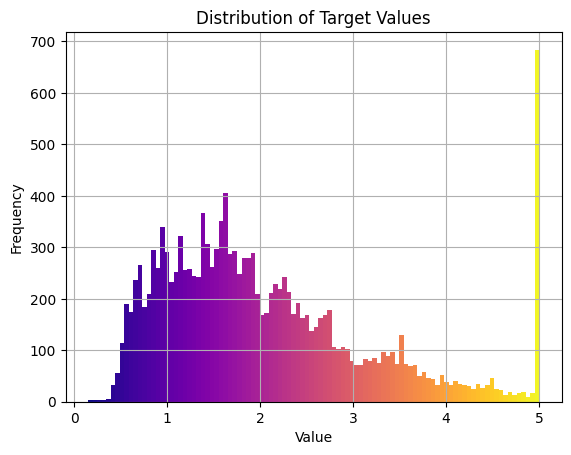

In [175]:
# Like the homework before, we plot the distribution of the target

def plot_gradient_histogram(df: pd.DataFrame, bins=100, cmap_name='plasma', which='Target'):
    """
    Plots a histogram of all values in the DataFrame with a gradient color map.
    """

    import matplotlib
    from matplotlib.colors import Normalize
    # Flatten data and remove NaNs
    data = df.values.flatten()
    data = data[~np.isnan(data)]
    
    # Compute histogram
    counts, bin_edges, patches = plt.hist(data, bins=bins)
    cmap = matplotlib.colormaps.get_cmap(cmap_name)
    norm = Normalize(vmin=bin_edges.min(), vmax=bin_edges.max())
    for edge, patch in zip(bin_edges, patches):
        patch.set_facecolor(cmap(norm(edge)))
    
    # Enhance plot aesthetics
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {which} Values')
    plt.grid(True)
    plt.show()

# Plot the distribution of the train target
plot_gradient_histogram(pd.DataFrame(train_target.data))

# It seems intersting that the target values conventrate around the max values

`2.3 Train with Gradient Boosting Model with different numbers of boosting rounds`

and

`2.3.1 Evaluate with RMSE, MAE, and R²`

In [315]:
# A batch pipeline on doing this Gradient Boosting task
# 

def gradient_boosting_regression(train_feature, test_feature, train_target, test_target,
                            use=["my", "sklearn"], plot=True,
                            *, 
                            n_estimators: int = 10,
                            max_features: str | int | float | None = 0.8,
                            bootstrap_ratio: float = 0.8,
                            replace: bool = True,
                            shuffle: bool = True,
                            eps: float = 1e-16,
                            tol: float = 1e-8,
                            lr: float = 1e-1,      
                            tree_type: type = CART,
                            verbosity: int = 1,
                            early_stop = None, 
                            early_stop_logic = "any",
                            evalset = None, 
                            evalmetrics = ["logloss"], 
                            continue_to_train = None,
                            tree_kwargs = {},
                            feature_names = None,
                            **kwargs):
    
    """
    Trains and evaluates a Gradient Boosting model using my implementation or sklearn's.

    Args:
        train_feature (Matrix | Tensor): Training feature data.
        test_feature (Matrix | Tensor): Test feature data.
        train_target (Matrix | Tensor): Training target labels.
        test_target (Matrix | Tensor): Test target labels.
        use: List of strings indicating the classification method to use. 
             Should be one of ["my", "sklearn"]. 
        plot: bool, whether to plot the feature importance graph or not (only valid in `my` implementation).
        n_estimators : int, indicating the maximum number of trees.
        max_features : {None, "sqrt", "log2", "over3"} | int | float, number of columns available to each tree.
        bootstrap_ratio : float, fraction of samples drawn per bootstrap sample, [0, 1].
        replace, shuffle : bool, if to shuffle the bootstrapped samples, passed to `_sample_bootstrapping`.
        eps: float, a very small amount to avoid dividing by 0.
        tol: float, tolerence for convergence when optimizing.
        lr: float, learning rate. Default 1e-2.
        verbosity (int): Whether to print some progresses if set to non-zero values.
        evalset (Dict[name : Tuple[X, y],
                     ...], | None) if provided, it may be used as evaluation set. XGBoost style.
        evalmetrics: (list of str | str | None) metrics used to do the evaluation. Will be printed.
        early_stop: (int | None) if non-None, then if metrics NOT gained for `early_stop` times, the forest will stop training.
        early_stop_logic: (str) the logic when deciding on multiple metrics, can be {"any", "some", "most", "all"}.
        continue_to_train: (bool | None) if non-None and True, the machine will try to restore the place it was and continue
                                to train new estimators until a new stopping criterion meets or until reaches the max number of allowed estimators.
        **kwargs: Any other arguments, for compatibility.

    Returns:
        tuple: A tuple containing model, Model, MSE, RMSE, MAE, R_2.

    Raises:
        ValueError: If `use` argument is neither "my" nor "sklearn".

    """

    # Returns a tuple of (Model, MSE, RMSE, MAE, R_2))
    
    if isinstance(use, list):
        use = use[0]
    if use != "my" and use != "sklearn":
        return ValueError("Arg `use` must be either `my` or `sklearn`!")
    
    # If using sklearn, forcefully convert data into numpy backend and scale it
    if use == "sklearn":
        train_feature = train_feature.to("numpy")
        train_target = train_target.to("numpy")
        test_feature = test_feature.to("numpy")
        test_target = test_target.to("numpy")
    else:
        pass

    # Create a gradient boost regressor instance before doing everything.
    if use == "my":
        if verbosity >= 1:
            print("Using my LR implementation as the regressor ...")
        model = GBM("regression", loss = None, init_method = "mean", tree_type = tree_type, 
                    n_estimators = n_estimators, max_features = max_features, bootstrap_ratio = bootstrap_ratio,
                    replace = replace, shuffle = shuffle, eps = eps, tol = tol, lr = lr,
                    tree_kwargs = tree_kwargs, agg_kwargs = {}, feature_names = feature_names, **kwargs)
    else:
        from sklearn.ensemble import GradientBoostingRegressor
        if verbosity >= 1:
            print("Using sklearn GradientBoostingRegressor as the regressor ...")
        model = GradientBoostingRegressor(learning_rate = lr, n_estimators = n_estimators, 
                                          subsample = bootstrap_ratio,
                                          max_depth = tree_kwargs.get("max_depth", 8), min_samples_leaf = 2)

    # Fit the model with the training dataset
    if use == "my":
        if verbosity >= 2:
            print("Fitting ...")
        model.fit(train_feature, train_target, verbosity=verbosity, evalset=evalset, evalmetrics=evalmetrics,
                  early_stop=early_stop, early_stop_logic=early_stop_logic, continue_to_train=continue_to_train,
                  **kwargs)
    else:
        if verbosity >= 2:
            print("Fitting ...")
        model.fit(train_feature.data, train_target.flatten().data)

    # Predict the values of the test set.
    if use == "my":
        if verbosity >= 2:
            print("Predicting ...")
        pred_values = model.predict(test_feature)
    else:
        if verbosity >= 2:
            print("Predicting ...")
        pred_values = type(test_feature)(model.predict(test_feature.data), backend="numpy").reshape([-1, 1])

    # Calculate Metrics
    mse_ = RegressionMetrics(pred_values, test_target, "mse").compute()
    rmse_ = RegressionMetrics(pred_values, test_target, "rmse").compute()
    mae_ = RegressionMetrics(pred_values, test_target, "mae").compute()
    r2_ = RegressionMetrics(pred_values, test_target, "r2").compute()

    # NOTE! Only plotting graphs when using `my` mode!
    if use == "my" and plot == True:
        model.plot_feature_importances_average(8, figsize=(14, 5), normalize=True)
        
    return model, mse_, rmse_, mae_, r2_ 

# Note. All of those metrics are computed by `RegressionMetrics`.
#       Feature Importance is plotted by matplotlib.

In [187]:
# Train and Evaluate the model - Train a Gradient Boosting Model with sklearn as benchmark
# 

model_sk, mse, rmse, mae, r2 = gradient_boosting_regression(
    train_feature, test_feature, train_target, test_target,
    use = "sklearn", n_estimators=50, lr = 0.1, 
    tree_kwargs = {"max_depth": 8}
)

# Evaluate performance on TEST SET.
print("Model Config: {Benchmark Evaluation: sklearn, with 50 estimators}")
print("RMSE :", round(rmse.to_list(), 6))
print("MAE  :", round(mae.to_list(), 6))
print("R^2  :", round(r2.to_list() * 100, 4), "%")

Using sklearn GradientBoostingRegressor as the regressor ...
Model Config: {Benchmark Evaluation: sklearn, with 50 estimators}
RMSE : 0.496778
MAE  : 0.325072
R^2  : 81.9137 %


In [180]:
# Train and Evaluate the model - Train a Gradient Boosting Model with sklearn as benchmark
# 

model_sk, mse, rmse, mae, r2 = gradient_boosting_regression(
    train_feature, test_feature, train_target, test_target,
    use = "sklearn", n_estimators=100, lr = 0.1, 
    tree_kwargs = {"max_depth": 8}
)

# Evaluate performance on TEST SET.
print("Model Config: {Benchmark Evaluation: sklearn, with 100 estimators}")
print("RMSE :", round(rmse.to_list(), 6))
print("MAE  :", round(mae.to_list(), 6))
print("R^2  :", round(r2.to_list() * 100, 4), "%")

Using sklearn GradientBoostingRegressor as the regressor ...
Model Config: {Benchmark Evaluation: sklearn, with 100 estimators}
RMSE : 0.487223
MAE  : 0.312086
R^2  : 82.6027 %


Using my LR implementation as the regressor ...
Training on Round: 0, starting from tree: 0 trainned on the residuals...
Training on Round: 1, starting from tree: 1 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.8492,  rmse:0.9215,  mae:0.7287,  r2:0.3553,  }]
Evalset: [Test : Metrics { mse:0.9074,  rmse:0.9526,  mae:0.7452,  r2:0.335,  }]
Training on Round: 2, starting from tree: 2 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.6944,  rmse:0.8333,  mae:0.6573,  r2:0.4728,  }]
Evalset: [Test : Metrics { mse:0.7567,  rmse:0.8699,  mae:0.6777,  r2:0.4454,  }]
Training on Round: 3, starting from tree: 3 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.5814,  rmse:0.7625,  mae:0.5993,  r2:0.5586,  }]
Evalset: [Test : Metrics { mse:0.6462,  rmse:0.8039,  mae:0.6225,  r2:0.5264,  }]
Training on Round: 4, starting from tree: 4 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.4932,  rmse:0.7023,  mae:0.5489,  r2:0.6256,  }]
Evalset: [

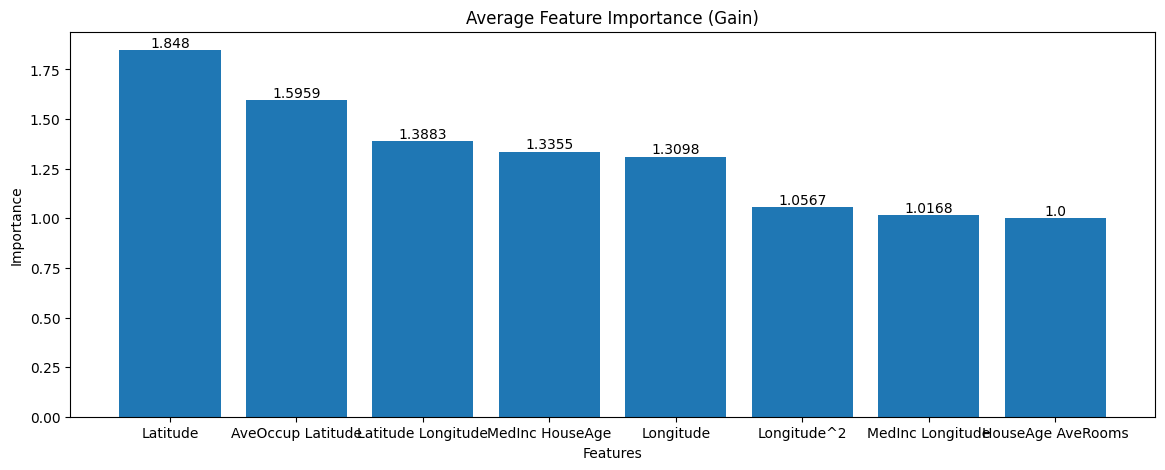

Model Config: {Gradient Boost, my GBM, newton, max_depth=8, n_estimators=5}
RMSE : 0.750496
MAE  : 0.575812
R^2  : 58.7215 %


In [181]:
# Train and Evaluate the model - Train a Gradient Boosting Model using my GBM with 5 estimators
# 

model0, mse, rmse, mae, r2 = gradient_boosting_regression(
    train_feature, test_feature, train_target, test_target,
    use = "my", n_estimators=5, lr = 0.15, 
    tree_kwargs = {"max_depth":8, 
                   "min_samples_split":0.001, 
                   "prune":False,
                   "grid_accelerator":20, 
                   "grid_use_percentile":False,
                   "grid_point_variant":None},
    plot = True,
    verbosity = 1,
    early_stop = 2, early_stop_logic = "most",
    evalset = {"Train": (train_feature, train_target), "Test": (test_feature, test_target)},
    evalmetrics = ["mse", "rmse", "mae", "r2"],
    feature_names = feature_names, continue_to_train = None,
)

# Evaluate performance on TEST SET.
print("Model Config: {Gradient Boost, my GBM, newton, max_depth=8, n_estimators=5}")
print("RMSE :", round(rmse.to_list(), 6))
print("MAE  :", round(mae.to_list(), 6))
print("R^2  :", round(r2.to_list() * 100, 4), "%")

Using my LR implementation as the regressor ...
Training on Round: 0, starting from tree: 0 trainned on the residuals...
Training on Round: 1, starting from tree: 1 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.8411,  rmse:0.9171,  mae:0.7231,  r2:0.3614,  }]
Evalset: [Test : Metrics { mse:0.8996,  rmse:0.9485,  mae:0.7403,  r2:0.3407,  }]
Training on Round: 2, starting from tree: 2 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.683,  rmse:0.8264,  mae:0.6496,  r2:0.4815,  }]
Evalset: [Test : Metrics { mse:0.7455,  rmse:0.8634,  mae:0.6698,  r2:0.4536,  }]
Training on Round: 3, starting from tree: 3 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.5723,  rmse:0.7565,  mae:0.5932,  r2:0.5655,  }]
Evalset: [Test : Metrics { mse:0.6398,  rmse:0.7999,  mae:0.6159,  r2:0.5311,  }]
Training on Round: 4, starting from tree: 4 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.4807,  rmse:0.6933,  mae:0.5408,  r2:0.6351,  }]
Evalset: [

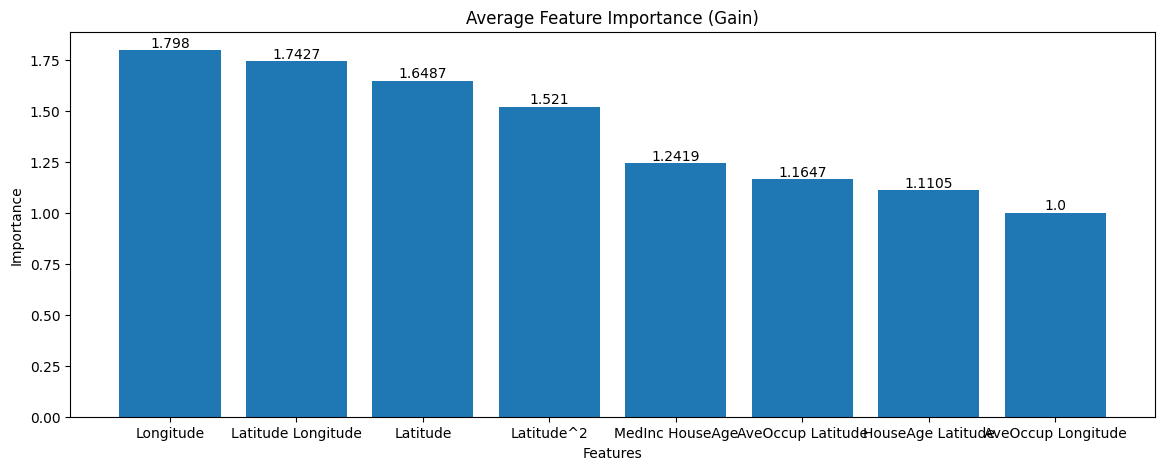

Model Config: {Gradient Boost, my GBM, newton, max_depth=8, n_estimators=10}
RMSE : 0.593556
MAE  : 0.428965
R^2  : 74.1804 %


In [183]:
# Train and Evaluate the model - Train a Gradient Boosting Model using my GBM with 10 estimators
# 

model1, mse, rmse, mae, r2 = gradient_boosting_regression(
    train_feature, test_feature, train_target, test_target,
    use = "my", n_estimators=10, lr = 0.15, 
    tree_kwargs = {"max_depth":8, 
                   "min_samples_split":0.0004, 
                   "prune":False,
                   "grid_accelerator":20, 
                   "grid_use_percentile":False,
                   "grid_point_variant":None},
    plot = True,
    verbosity = 1,
    early_stop = 2, early_stop_logic = "most",
    evalset = {"Train": (train_feature, train_target), "Test": (test_feature, test_target)},
    evalmetrics = ["mse", "rmse", "mae", "r2"],
    feature_names = feature_names, continue_to_train = None,
)

# Evaluate performance on TEST SET.
print("Model Config: {Gradient Boost, my GBM, newton, max_depth=8, n_estimators=10}")
print("RMSE :", round(rmse.to_list(), 6))
print("MAE  :", round(mae.to_list(), 6))
print("R^2  :", round(r2.to_list() * 100, 4), "%")

Using my LR implementation as the regressor ...
Training on Round: 0, starting from tree: 0 trainned on the residuals...
Training on Round: 1, starting from tree: 1 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.84,  rmse:0.9165,  mae:0.7223,  r2:0.3623,  }]
Evalset: [Test : Metrics { mse:0.8992,  rmse:0.9483,  mae:0.7387,  r2:0.341,  }]
Training on Round: 2, starting from tree: 2 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.6877,  rmse:0.8293,  mae:0.6519,  r2:0.4779,  }]
Evalset: [Test : Metrics { mse:0.7538,  rmse:0.8682,  mae:0.6723,  r2:0.4476,  }]
Training on Round: 3, starting from tree: 3 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.5716,  rmse:0.7561,  mae:0.593,  r2:0.566,  }]
Evalset: [Test : Metrics { mse:0.6444,  rmse:0.8028,  mae:0.6181,  r2:0.5277,  }]
Training on Round: 4, starting from tree: 4 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.4859,  rmse:0.697,  mae:0.5445,  r2:0.6311,  }]
Evalset: [Test 

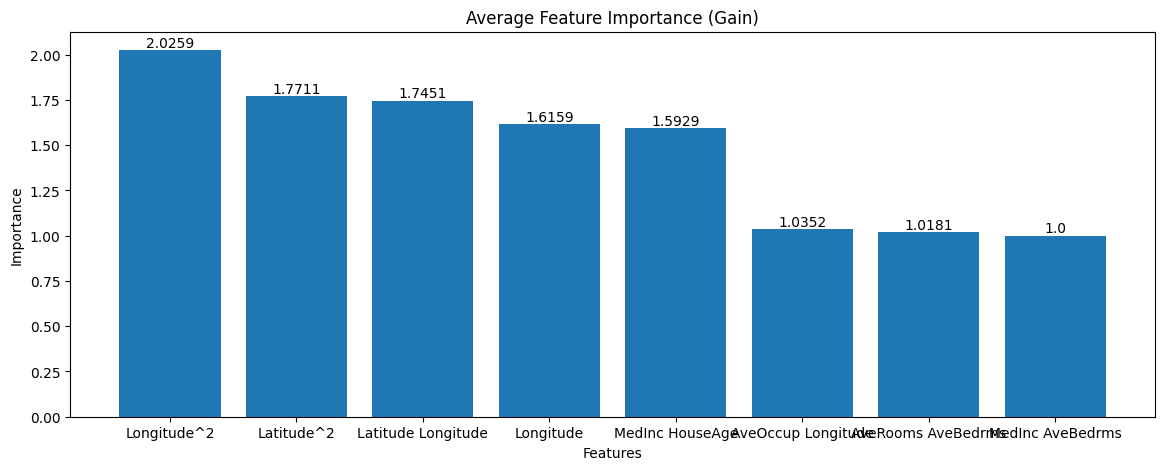

Model Config: {Gradient Boost, my GBM, newton, max_depth=8, n_estimators=20}
RMSE : 0.527512
MAE  : 0.353045
R^2  : 79.6065 %


In [184]:
# Train and Evaluate the model - Train a Gradient Boosting Model using my GBM with 20 estimators
# 

model2, mse, rmse, mae, r2 = gradient_boosting_regression(
    train_feature, test_feature, train_target, test_target,
    use = "my", n_estimators=20, lr = 0.15, 
    tree_kwargs = {"max_depth":8, 
                   "min_samples_split":0.0004, 
                   "prune":False,
                   "grid_accelerator":20, 
                   "grid_use_percentile":False,
                   "grid_point_variant":None},
    plot = True,
    verbosity = 1,
    early_stop = 4, early_stop_logic = "most",
    evalset = {"Train": (train_feature, train_target), "Test": (test_feature, test_target)},
    evalmetrics = ["mse", "rmse", "mae", "r2"],
    feature_names = feature_names, continue_to_train = None,
)

# Evaluate performance on TEST SET.
print("Model Config: {Gradient Boost, my GBM, newton, max_depth=8, n_estimators=20}")
print("RMSE :", round(rmse.to_list(), 6))
print("MAE  :", round(mae.to_list(), 6))
print("R^2  :", round(r2.to_list() * 100, 4), "%")

Using my LR implementation as the regressor ...
Training on Round: 0, starting from tree: 0 trainned on the residuals...
Training on Round: 1, starting from tree: 1 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.8381,  rmse:0.9155,  mae:0.7206,  r2:0.3637,  }]
Evalset: [Test : Metrics { mse:0.8914,  rmse:0.9441,  mae:0.7357,  r2:0.3467,  }]
Training on Round: 2, starting from tree: 2 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.6925,  rmse:0.8322,  mae:0.6534,  r2:0.4742,  }]
Evalset: [Test : Metrics { mse:0.753,  rmse:0.8678,  mae:0.6722,  r2:0.4482,  }]
Training on Round: 3, starting from tree: 3 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.5776,  rmse:0.76,  mae:0.595,  r2:0.5615,  }]
Evalset: [Test : Metrics { mse:0.6434,  rmse:0.8021,  mae:0.6179,  r2:0.5285,  }]
Training on Round: 4, starting from tree: 4 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.4891,  rmse:0.6993,  mae:0.5452,  r2:0.6287,  }]
Evalset: [Tes

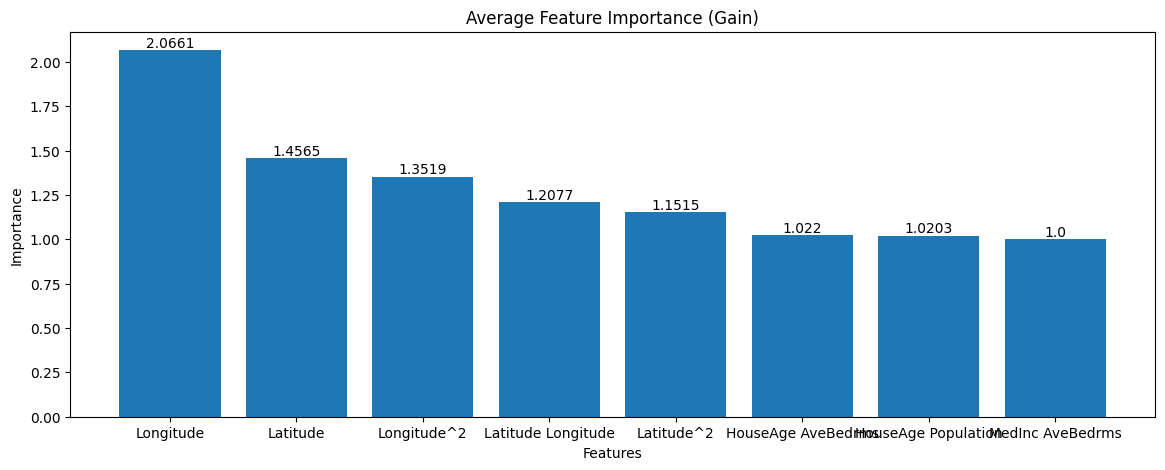

Model Config: {Gradient Boost, my GBM, newton, max_depth=8, n_estimators=50, verbosity=1}
RMSE : 0.493953
MAE  : 0.324504
R^2  : 82.1188 %


In [185]:
# Train and Evaluate the model - Train a Gradient Boosting Model using my GBM with 50 estimators
# 

model3, mse, rmse, mae, r2 = gradient_boosting_regression(
    train_feature, test_feature, train_target, test_target,
    use = "my", n_estimators=50, lr = 0.15, 
    tree_kwargs = {"max_depth":8, 
                   "min_samples_split":0.0008, 
                   "prune": False,
                   "grid_accelerator":10, 
                   "grid_use_percentile":False,
                   "grid_point_variant":None},
    plot = True,
    verbosity = 1,
    early_stop = 4, early_stop_logic = "most",
    evalset = {"Train": (train_feature, train_target), "Test": (test_feature, test_target)},
    evalmetrics = ["mse", "rmse", "mae", "r2"],
    feature_names = feature_names, continue_to_train = None,
)

# Evaluate performance on TEST SET.
print("Model Config: {Gradient Boost, my GBM, newton, max_depth=8, n_estimators=50, verbosity=1}")
print("RMSE :", round(rmse.to_list(), 6))
print("MAE  :", round(mae.to_list(), 6))
print("R^2  :", round(r2.to_list() * 100, 4), "%")

Using my LR implementation as the regressor ...
Training on Round: 0, starting from tree: 0 trainned on the residuals...
Training on Round: 1, starting from tree: 1 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.9806,  rmse:0.9902,  mae:0.783,  r2:0.2556,  }]
Evalset: [Test : Metrics { mse:1.0333,  rmse:1.0165,  mae:0.7968,  r2:0.2427,  }]
Training on Round: 2, starting from tree: 2 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.8557,  rmse:0.925,  mae:0.7316,  r2:0.3504,  }]
Evalset: [Test : Metrics { mse:0.9091,  rmse:0.9534,  mae:0.7463,  r2:0.3338,  }]
Training on Round: 3, starting from tree: 3 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.7426,  rmse:0.8618,  mae:0.6801,  r2:0.4362,  }]
Evalset: [Test : Metrics { mse:0.7966,  rmse:0.8925,  mae:0.6954,  r2:0.4162,  }]
Training on Round: 4, starting from tree: 4 trainned on the residuals...
Evalset: [Train : Metrics { mse:0.6562,  rmse:0.8101,  mae:0.6373,  r2:0.5018,  }]
Evalset: [T

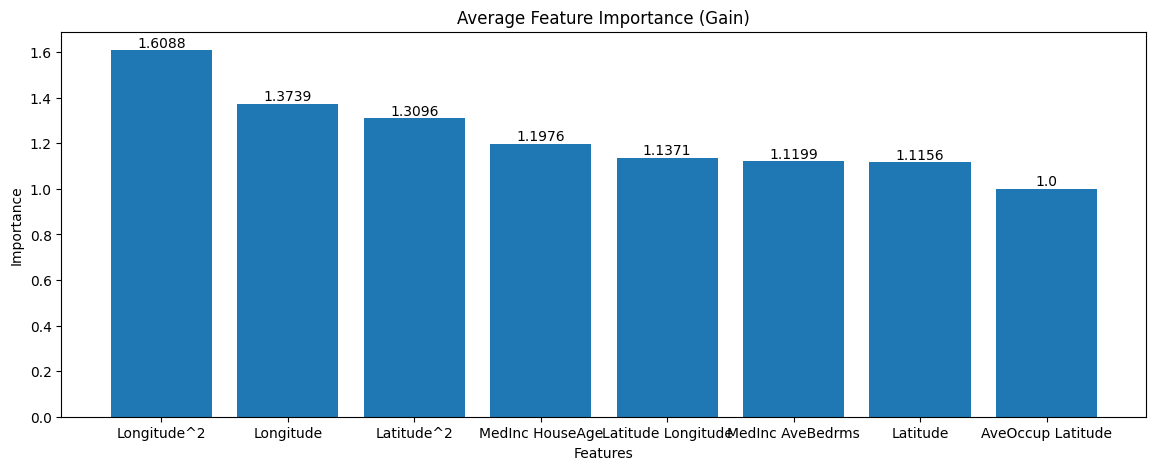

Model Config: {Gradient Boost, my GBM, newton, max_depth=8, n_estimators=100, verbosity=1}
RMSE : 0.477852
MAE  : 0.310176
R^2  : 83.2655 %


In [197]:
# Train and Evaluate the model - Train a Gradient Boosting Model using my GBM with 100 estimators
# 

model4, mse, rmse, mae, r2 = gradient_boosting_regression(
    train_feature, test_feature, train_target, test_target,
    use = "my", n_estimators=100, lr = 0.10, 
    tree_kwargs = {"max_depth":8, 
                   "min_samples_split":0.0008, 
                   "prune": False,
                   "grid_accelerator":10, 
                   "grid_use_percentile":False,
                   "grid_point_variant":None},
    plot = True,
    verbosity = 1,
    early_stop = 4, early_stop_logic = "most",
    evalset = {"Train": (train_feature, train_target), "Test": (test_feature, test_target)},
    evalmetrics = ["mse", "rmse", "mae", "r2"],
    feature_names = feature_names, continue_to_train = None,
)

# Evaluate performance on TEST SET.
print("Model Config: {Gradient Boost, my GBM, newton, max_depth=8, n_estimators=100, verbosity=1}")
print("RMSE :", round(rmse.to_list(), 6))
print("MAE  :", round(mae.to_list(), 6))
print("R^2  :", round(r2.to_list() * 100, 4), "%")

In [ ]:
# A short review on the performance
# 
#                              RMSE       MAE        R^2
#  
# Sklearn Bench 50           0.4968    0.3251     0.8191
# Sklearn Bench 100          0.4872    0.3120     0.8260
# My GBM CART x5             0.7504    0.5758     0.5872
# My GBM CART x10            0.5936    0.4289     0.7418
# My GBM CART x20            0.5275    0.3530     0.7961 
# My GBM CART x50            0.4939    0.3245     0.8212
# My GBM CART x100           0.4779    0.3102     0.8327 
# * Comparable Logit Reg                          0.7296
#
# > From the figures above, we have those observations：
# > 1. First, comparing GBM with logistic regression, we have found that the boosting model outperforms significantly
#      and achieved a higher-than-0.8 R2 metric in this regression task. It is because the nonlinearity introduced by fitting
#      on the residuals for each subsequent trees.
# > 2. Comparing within my GBM implementaion, as the number of trees increases, the result generally improves but in a marginal 
#      decreasing way - it comes to a plateau when it comes to 100 estimators. Note, GBM may introduce overfitting but in the case
#      we are testing, the algorithm did NOT stop to train, which means overfitting has not been detected even with 100 estimators.
# > 3. By comparing the metrics of sklearn models and my models, we can see they generally achieved a comparable level,
#      with around 0.82 in R2 when there are 50 estimators and 0.83 in R2 when 100 estimators.
#      I have done extensive experiments and confirmmed at least my GBM can achieve a comparable performance as sklearn's gradient
#      boosting models, including GradientBoostRegressor and GradientBoostClassifier.

In [ ]:
# Example of saving the Gradient Boosting model to disk.
#

# |
# V De-comment this line to save the model.
# model4.save(model4, "./models/GradientBoosting.ID04.bin")

`2.3.2 Visualization of the predictions and training process`

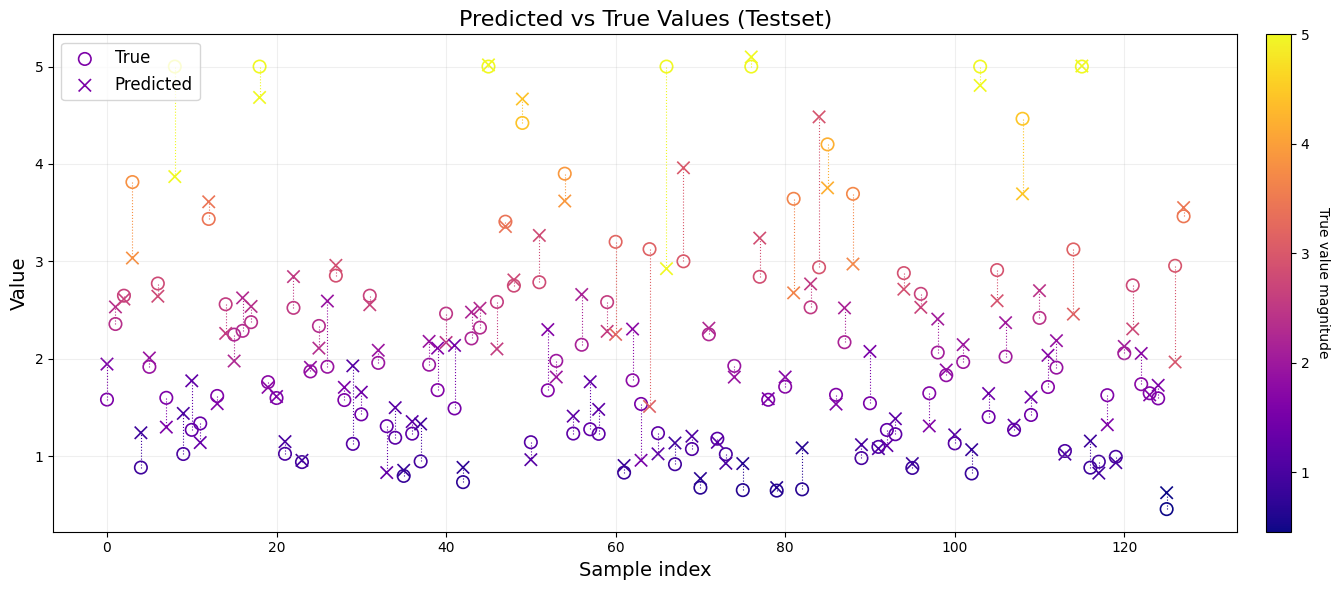

In [ ]:
# Prediction vs. True values (scatter plot) - using model4
# 

# Prediction by model4
pred_y = model4.predict(test_feature)

# Plot prediction versus true
def plot_pred_vs_true(y_true: np.ndarray,
                      y_pred: np.ndarray,
                      *,
                      cmap: str = 'plasma',
                      base_marker_size: int = None,
                      alpha: float = None,
                      rasterized: bool = True):
    """
    Scatter true vs. predicted values over sample index, with:
      - hollow circles for true
      - '×' for predicted
      - color-encoded by true value magnitude
      - auto-adjusted marker_size & alpha when n is large
      - optional rasterization for very large n
    
    A slim dotted line now connects each true–predicted pair.
    """
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")
    
    n = y_true.shape[0]
    from matplotlib import colors
    if base_marker_size is None:
        base_marker_size = 80 if n < 5_000 else 20
    if alpha is None:
        alpha = 1.0 if n < 5_000 else 0.3

    norm = colors.Normalize(vmin=y_true.min(), vmax=y_true.max())
    cmap_obj = plt.colormaps[cmap]

    fig, ax = plt.subplots(figsize=(15, 6))
    idx = np.arange(n)

    # True values: hollow circles
    ax.scatter(idx, y_true,
               marker='o',
               facecolors='none',
               edgecolors=cmap_obj(norm(y_true)),
               s=base_marker_size,
               linewidths=1.2,
               alpha=alpha,
               rasterized=rasterized,
               label='True')

    # Predicted values: × markers
    ax.scatter(idx, y_pred,
               marker='x',
               c=cmap_obj(norm(y_true)),
               s=base_marker_size,
               linewidths=1.2,
               alpha=alpha,
               rasterized=rasterized,
               label='Predicted')

    # Slim dotted lines connecting each true–predicted pair
    ax.vlines(idx,
              y_true,
              y_pred,
              colors=cmap_obj(norm(y_true)),
              linestyles=':',
              linewidths=0.8,
              alpha=alpha,
              rasterized=rasterized)

    # Create a ScalarMappable and attach it to this Axes
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    sm.set_array(y_true)

    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label('True value magnitude', rotation=270, labelpad=15)

    ax.set_title('Predicted vs True Values (Testset)', fontsize=16)
    ax.set_xlabel('Sample index', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(alpha=0.2)

    fig.tight_layout()
    plt.show()

# Since the number is large, we plot the first 128 entries.
plot_pred_vs_true(test_target.flatten()[0:128].to_numpy_array(), pred_y.flatten()[0:128].to_numpy_array())

# We can see even if some points are not close to 0 or 1, they are all correctly classified.
# We can also see most of the predictions are super close to the real target (0 or 1) after applied the sigmoid function.

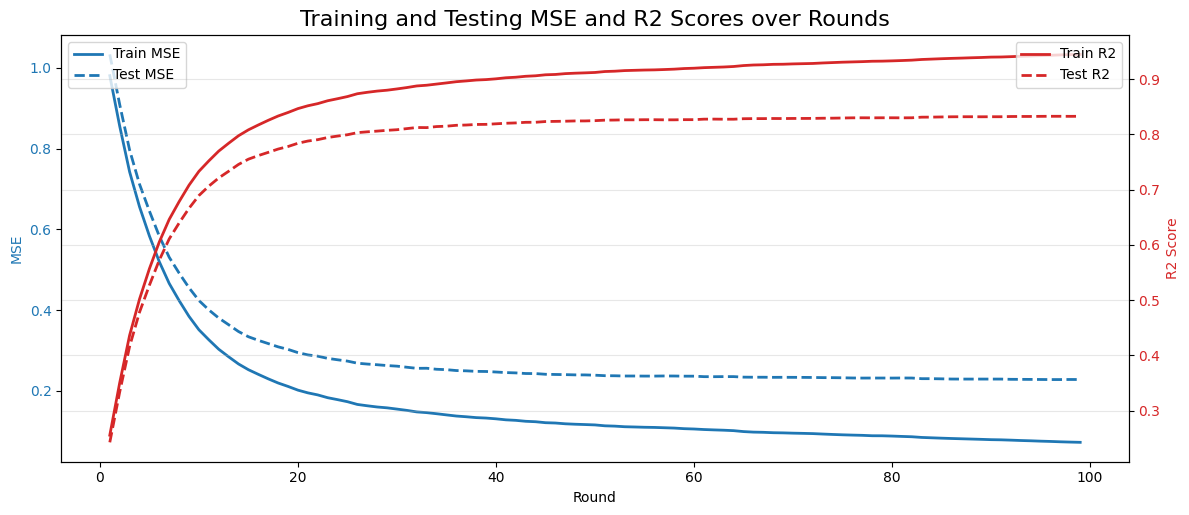

In [ ]:
# Visualize the training and testing loss across the boosting process - MSE against R2
#

def plot_loss_across_training():
    import re
    import matplotlib.pyplot as plt

    log_data = """
        Training on Round: 0, starting from tree: 0 trainned on the residuals...
        Training on Round: 1, starting from tree: 1 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.9806,  rmse:0.9902,  mae:0.783,  r2:0.2556,  }]
        Evalset: [Test : Metrics { mse:1.0333,  rmse:1.0165,  mae:0.7968,  r2:0.2427,  }]
        Training on Round: 2, starting from tree: 2 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.8557,  rmse:0.925,  mae:0.7316,  r2:0.3504,  }]
        Evalset: [Test : Metrics { mse:0.9091,  rmse:0.9534,  mae:0.7463,  r2:0.3338,  }]
        Training on Round: 3, starting from tree: 3 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.7426,  rmse:0.8618,  mae:0.6801,  r2:0.4362,  }]
        Evalset: [Test : Metrics { mse:0.7966,  rmse:0.8925,  mae:0.6954,  r2:0.4162,  }]
        Training on Round: 4, starting from tree: 4 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.6562,  rmse:0.8101,  mae:0.6373,  r2:0.5018,  }]
        Evalset: [Test : Metrics { mse:0.7121,  rmse:0.8439,  mae:0.6543,  r2:0.4781,  }]
        Training on Round: 5, starting from tree: 5 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.5838,  rmse:0.7641,  mae:0.5998,  r2:0.5568,  }]
        Evalset: [Test : Metrics { mse:0.6454,  rmse:0.8033,  mae:0.6205,  r2:0.527,  }]
        Training on Round: 6, starting from tree: 6 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.5199,  rmse:0.721,  mae:0.5644,  r2:0.6053,  }]
        Evalset: [Test : Metrics { mse:0.5833,  rmse:0.7637,  mae:0.5871,  r2:0.5725,  }]
        Training on Round: 7, starting from tree: 7 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.4662,  rmse:0.6828,  mae:0.5327,  r2:0.6461,  }]
        Evalset: [Test : Metrics { mse:0.531,  rmse:0.7287,  mae:0.5569,  r2:0.6108,  }]
        Training on Round: 8, starting from tree: 8 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.4238,  rmse:0.651,  mae:0.5058,  r2:0.6782,  }]
        Evalset: [Test : Metrics { mse:0.4918,  rmse:0.7012,  mae:0.5325,  r2:0.6396,  }]
        Training on Round: 9, starting from tree: 9 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.3846,  rmse:0.6202,  mae:0.4795,  r2:0.708,  }]
        Evalset: [Test : Metrics { mse:0.4555,  rmse:0.6749,  mae:0.5085,  r2:0.6662,  }]
        Training on Round: 10, starting from tree: 10 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.3515,  rmse:0.5929,  mae:0.4561,  r2:0.7331,  }]
        Evalset: [Test : Metrics { mse:0.424,  rmse:0.6511,  mae:0.4874,  r2:0.6893,  }]
        Training on Round: 11, starting from tree: 11 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.3267,  rmse:0.5716,  mae:0.4378,  r2:0.752,  }]
        Evalset: [Test : Metrics { mse:0.4007,  rmse:0.633,  mae:0.4709,  r2:0.7063,  }]
        Training on Round: 12, starting from tree: 12 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.3033,  rmse:0.5507,  mae:0.4195,  r2:0.7697,  }]
        Evalset: [Test : Metrics { mse:0.3806,  rmse:0.6169,  mae:0.4553,  r2:0.7211,  }]
        Training on Round: 13, starting from tree: 13 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.2846,  rmse:0.5335,  mae:0.4051,  r2:0.7839,  }]
        Evalset: [Test : Metrics { mse:0.364,  rmse:0.6033,  mae:0.4427,  r2:0.7332,  }]
        Training on Round: 14, starting from tree: 14 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.2668,  rmse:0.5165,  mae:0.3899,  r2:0.7975,  }]
        Evalset: [Test : Metrics { mse:0.3471,  rmse:0.5891,  mae:0.4293,  r2:0.7456,  }]
        Training on Round: 15, starting from tree: 15 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.2526,  rmse:0.5026,  mae:0.3774,  r2:0.8082,  }]
        Evalset: [Test : Metrics { mse:0.3342,  rmse:0.5781,  mae:0.4181,  r2:0.7551,  }]
        Training on Round: 16, starting from tree: 16 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.2411,  rmse:0.491,  mae:0.3676,  r2:0.817,  }]
        Evalset: [Test : Metrics { mse:0.3253,  rmse:0.5703,  mae:0.4102,  r2:0.7616,  }]
        Training on Round: 17, starting from tree: 17 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.23,  rmse:0.4796,  mae:0.3574,  r2:0.8254,  }]
        Evalset: [Test : Metrics { mse:0.3173,  rmse:0.5633,  mae:0.4021,  r2:0.7674,  }]
        Training on Round: 18, starting from tree: 18 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.2197,  rmse:0.4687,  mae:0.3475,  r2:0.8332,  }]
        Evalset: [Test : Metrics { mse:0.3092,  rmse:0.5561,  mae:0.3938,  r2:0.7734,  }]
        Training on Round: 19, starting from tree: 19 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.2112,  rmse:0.4596,  mae:0.3393,  r2:0.8396,  }]
        Evalset: [Test : Metrics { mse:0.3029,  rmse:0.5504,  mae:0.3878,  r2:0.778,  }]
        Training on Round: 20, starting from tree: 20 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.202,  rmse:0.4495,  mae:0.3304,  r2:0.8466,  }]
        Evalset: [Test : Metrics { mse:0.2949,  rmse:0.543,  mae:0.3805,  r2:0.7839,  }]
        Training on Round: 21, starting from tree: 21 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1953,  rmse:0.442,  mae:0.3236,  r2:0.8517,  }]
        Evalset: [Test : Metrics { mse:0.2893,  rmse:0.5379,  mae:0.3749,  r2:0.7879,  }]
        Training on Round: 22, starting from tree: 22 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1902,  rmse:0.4362,  mae:0.3181,  r2:0.8556,  }]
        Evalset: [Test : Metrics { mse:0.2861,  rmse:0.5348,  mae:0.3706,  r2:0.7904,  }]
        Training on Round: 23, starting from tree: 23 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1833,  rmse:0.4282,  mae:0.3112,  r2:0.8608,  }]
        Evalset: [Test : Metrics { mse:0.2807,  rmse:0.5298,  mae:0.365,  r2:0.7943,  }]
        Training on Round: 24, starting from tree: 24 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1785,  rmse:0.4225,  mae:0.3062,  r2:0.8645,  }]
        Evalset: [Test : Metrics { mse:0.2772,  rmse:0.5265,  mae:0.3611,  r2:0.7969,  }]
        Training on Round: 25, starting from tree: 25 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1734,  rmse:0.4164,  mae:0.301,  r2:0.8684,  }]
        Evalset: [Test : Metrics { mse:0.2739,  rmse:0.5233,  mae:0.3575,  r2:0.7993,  }]
        Training on Round: 26, starting from tree: 26 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1666,  rmse:0.4082,  mae:0.294,  r2:0.8735,  }]
        Evalset: [Test : Metrics { mse:0.2687,  rmse:0.5183,  mae:0.3521,  r2:0.8031,  }]
        Training on Round: 27, starting from tree: 27 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1633,  rmse:0.4041,  mae:0.2902,  r2:0.8761,  }]
        Evalset: [Test : Metrics { mse:0.2666,  rmse:0.5163,  mae:0.3494,  r2:0.8046,  }]
        Training on Round: 28, starting from tree: 28 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1603,  rmse:0.4003,  mae:0.2869,  r2:0.8783,  }]
        Evalset: [Test : Metrics { mse:0.2649,  rmse:0.5146,  mae:0.347,  r2:0.8059,  }]
        Training on Round: 29, starting from tree: 29 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1582,  rmse:0.3977,  mae:0.2843,  r2:0.8799,  }]
        Evalset: [Test : Metrics { mse:0.2629,  rmse:0.5127,  mae:0.3446,  r2:0.8073,  }]
        Training on Round: 30, starting from tree: 30 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1551,  rmse:0.3939,  mae:0.281,  r2:0.8822,  }]
        Evalset: [Test : Metrics { mse:0.2614,  rmse:0.5113,  mae:0.3427,  r2:0.8084,  }]
        Training on Round: 31, starting from tree: 31 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1519,  rmse:0.3897,  mae:0.2772,  r2:0.8847,  }]
        Evalset: [Test : Metrics { mse:0.2587,  rmse:0.5087,  mae:0.3398,  r2:0.8104,  }]
        Training on Round: 32, starting from tree: 32 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1481,  rmse:0.3848,  mae:0.2732,  r2:0.8876,  }]
        Evalset: [Test : Metrics { mse:0.256,  rmse:0.5059,  mae:0.3369,  r2:0.8124,  }]
        Training on Round: 33, starting from tree: 33 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1463,  rmse:0.3825,  mae:0.2714,  r2:0.8889,  }]
        Evalset: [Test : Metrics { mse:0.2562,  rmse:0.5062,  mae:0.3365,  r2:0.8122,  }]
        Training on Round: 34, starting from tree: 34 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1436,  rmse:0.379,  mae:0.2684,  r2:0.891,  }]
        Evalset: [Test : Metrics { mse:0.2537,  rmse:0.5037,  mae:0.3344,  r2:0.8141,  }]
        Training on Round: 35, starting from tree: 35 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1407,  rmse:0.3752,  mae:0.2657,  r2:0.8931,  }]
        Evalset: [Test : Metrics { mse:0.2527,  rmse:0.5027,  mae:0.3332,  r2:0.8148,  }]
        Training on Round: 36, starting from tree: 36 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1379,  rmse:0.3714,  mae:0.2625,  r2:0.8953,  }]
        Evalset: [Test : Metrics { mse:0.2505,  rmse:0.5005,  mae:0.3309,  r2:0.8164,  }]
        Training on Round: 37, starting from tree: 37 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1361,  rmse:0.3689,  mae:0.2607,  r2:0.8967,  }]
        Evalset: [Test : Metrics { mse:0.2498,  rmse:0.4998,  mae:0.3302,  r2:0.8169,  }]
        Training on Round: 38, starting from tree: 38 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.134,  rmse:0.366,  mae:0.2583,  r2:0.8983,  }]
        Evalset: [Test : Metrics { mse:0.2485,  rmse:0.4985,  mae:0.3288,  r2:0.8179,  }]
        Training on Round: 39, starting from tree: 39 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1329,  rmse:0.3645,  mae:0.2569,  r2:0.8991,  }]
        Evalset: [Test : Metrics { mse:0.2482,  rmse:0.4982,  mae:0.3282,  r2:0.8181,  }]
        Training on Round: 40, starting from tree: 40 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.131,  rmse:0.362,  mae:0.2549,  r2:0.9005,  }]
        Evalset: [Test : Metrics { mse:0.2469,  rmse:0.4969,  mae:0.3268,  r2:0.8191,  }]
        Training on Round: 41, starting from tree: 41 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1285,  rmse:0.3585,  mae:0.2525,  r2:0.9024,  }]
        Evalset: [Test : Metrics { mse:0.2455,  rmse:0.4955,  mae:0.3254,  r2:0.8201,  }]
        Training on Round: 42, starting from tree: 42 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1272,  rmse:0.3566,  mae:0.2511,  r2:0.9034,  }]
        Evalset: [Test : Metrics { mse:0.2447,  rmse:0.4947,  mae:0.3247,  r2:0.8207,  }]
        Training on Round: 43, starting from tree: 43 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1249,  rmse:0.3535,  mae:0.2486,  r2:0.9051,  }]
        Evalset: [Test : Metrics { mse:0.2432,  rmse:0.4931,  mae:0.3232,  r2:0.8218,  }]
        Training on Round: 44, starting from tree: 44 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1238,  rmse:0.3518,  mae:0.2472,  r2:0.906,  }]
        Evalset: [Test : Metrics { mse:0.243,  rmse:0.4929,  mae:0.3229,  r2:0.8219,  }]
        Training on Round: 45, starting from tree: 45 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1214,  rmse:0.3484,  mae:0.245,  r2:0.9078,  }]
        Evalset: [Test : Metrics { mse:0.2413,  rmse:0.4912,  mae:0.3212,  r2:0.8232,  }]
        Training on Round: 46, starting from tree: 46 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1206,  rmse:0.3473,  mae:0.2443,  r2:0.9084,  }]
        Evalset: [Test : Metrics { mse:0.2408,  rmse:0.4907,  mae:0.3209,  r2:0.8235,  }]
        Training on Round: 47, starting from tree: 47 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1187,  rmse:0.3445,  mae:0.2423,  r2:0.9099,  }]
        Evalset: [Test : Metrics { mse:0.2404,  rmse:0.4903,  mae:0.3205,  r2:0.8238,  }]
        Training on Round: 48, starting from tree: 48 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1176,  rmse:0.3429,  mae:0.2412,  r2:0.9107,  }]
        Evalset: [Test : Metrics { mse:0.2398,  rmse:0.4897,  mae:0.3199,  r2:0.8243,  }]
        Training on Round: 49, starting from tree: 49 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1168,  rmse:0.3418,  mae:0.2405,  r2:0.9113,  }]
        Evalset: [Test : Metrics { mse:0.2397,  rmse:0.4896,  mae:0.3199,  r2:0.8243,  }]
        Training on Round: 50, starting from tree: 50 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1159,  rmse:0.3404,  mae:0.2396,  r2:0.912,  }]
        Evalset: [Test : Metrics { mse:0.239,  rmse:0.4889,  mae:0.3194,  r2:0.8248,  }]
        Training on Round: 51, starting from tree: 51 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1137,  rmse:0.3372,  mae:0.2375,  r2:0.9137,  }]
        Evalset: [Test : Metrics { mse:0.2378,  rmse:0.4877,  mae:0.3184,  r2:0.8257,  }]
        Training on Round: 52, starting from tree: 52 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1129,  rmse:0.3361,  mae:0.2366,  r2:0.9143,  }]
        Evalset: [Test : Metrics { mse:0.2376,  rmse:0.4874,  mae:0.3182,  r2:0.8259,  }]
        Training on Round: 53, starting from tree: 53 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1114,  rmse:0.3337,  mae:0.2351,  r2:0.9154,  }]
        Evalset: [Test : Metrics { mse:0.237,  rmse:0.4868,  mae:0.3176,  r2:0.8263,  }]
        Training on Round: 54, starting from tree: 54 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1108,  rmse:0.3328,  mae:0.2345,  r2:0.9159,  }]
        Evalset: [Test : Metrics { mse:0.237,  rmse:0.4868,  mae:0.3176,  r2:0.8263,  }]
        Training on Round: 55, starting from tree: 55 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1101,  rmse:0.3318,  mae:0.2336,  r2:0.9164,  }]
        Evalset: [Test : Metrics { mse:0.2368,  rmse:0.4866,  mae:0.3174,  r2:0.8265,  }]
        Training on Round: 56, starting from tree: 56 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1097,  rmse:0.3312,  mae:0.2331,  r2:0.9167,  }]
        Evalset: [Test : Metrics { mse:0.2368,  rmse:0.4866,  mae:0.3173,  r2:0.8265,  }]
        Training on Round: 57, starting from tree: 57 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1089,  rmse:0.33,  mae:0.2327,  r2:0.9173,  }]
        Evalset: [Test : Metrics { mse:0.2371,  rmse:0.4869,  mae:0.3175,  r2:0.8263,  }]
        Training on Round: 58, starting from tree: 58 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1081,  rmse:0.3287,  mae:0.2318,  r2:0.918,  }]
        Evalset: [Test : Metrics { mse:0.237,  rmse:0.4869,  mae:0.3174,  r2:0.8263,  }]
        Training on Round: 59, starting from tree: 59 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1066,  rmse:0.3265,  mae:0.2304,  r2:0.9191,  }]
        Evalset: [Test : Metrics { mse:0.2366,  rmse:0.4864,  mae:0.3169,  r2:0.8266,  }]
        Training on Round: 60, starting from tree: 60 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1058,  rmse:0.3253,  mae:0.2295,  r2:0.9197,  }]
        Evalset: [Test : Metrics { mse:0.2366,  rmse:0.4865,  mae:0.317,  r2:0.8266,  }]
        Training on Round: 61, starting from tree: 61 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1045,  rmse:0.3233,  mae:0.2281,  r2:0.9207,  }]
        Evalset: [Test : Metrics { mse:0.2354,  rmse:0.4851,  mae:0.3159,  r2:0.8275,  }]
        Training on Round: 62, starting from tree: 62 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1036,  rmse:0.3219,  mae:0.2273,  r2:0.9213,  }]
        Evalset: [Test : Metrics { mse:0.2353,  rmse:0.4851,  mae:0.3157,  r2:0.8276,  }]
        Training on Round: 63, starting from tree: 63 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1028,  rmse:0.3207,  mae:0.2265,  r2:0.9219,  }]
        Evalset: [Test : Metrics { mse:0.2355,  rmse:0.4853,  mae:0.3159,  r2:0.8274,  }]
        Training on Round: 64, starting from tree: 64 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.1017,  rmse:0.3189,  mae:0.2252,  r2:0.9228,  }]
        Evalset: [Test : Metrics { mse:0.2355,  rmse:0.4853,  mae:0.3156,  r2:0.8274,  }]
        Training on Round: 65, starting from tree: 65 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0994,  rmse:0.3153,  mae:0.223,  r2:0.9245,  }]
        Evalset: [Test : Metrics { mse:0.2342,  rmse:0.484,  mae:0.3143,  r2:0.8283,  }]
        Training on Round: 66, starting from tree: 66 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0981,  rmse:0.3132,  mae:0.2217,  r2:0.9255,  }]
        Evalset: [Test : Metrics { mse:0.234,  rmse:0.4837,  mae:0.3142,  r2:0.8285,  }]
        Training on Round: 67, starting from tree: 67 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0976,  rmse:0.3124,  mae:0.2212,  r2:0.9259,  }]
        Evalset: [Test : Metrics { mse:0.234,  rmse:0.4837,  mae:0.3143,  r2:0.8285,  }]
        Training on Round: 68, starting from tree: 68 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0966,  rmse:0.3108,  mae:0.2201,  r2:0.9267,  }]
        Evalset: [Test : Metrics { mse:0.2337,  rmse:0.4834,  mae:0.3142,  r2:0.8287,  }]
        Training on Round: 69, starting from tree: 69 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0962,  rmse:0.3102,  mae:0.2197,  r2:0.9269,  }]
        Evalset: [Test : Metrics { mse:0.2338,  rmse:0.4835,  mae:0.3142,  r2:0.8286,  }]
        Training on Round: 70, starting from tree: 70 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0955,  rmse:0.309,  mae:0.2189,  r2:0.9275,  }]
        Evalset: [Test : Metrics { mse:0.2337,  rmse:0.4834,  mae:0.314,  r2:0.8288,  }]
        Training on Round: 71, starting from tree: 71 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.095,  rmse:0.3082,  mae:0.2183,  r2:0.9279,  }]
        Evalset: [Test : Metrics { mse:0.2336,  rmse:0.4833,  mae:0.314,  r2:0.8288,  }]
        Training on Round: 72, starting from tree: 72 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0944,  rmse:0.3073,  mae:0.2177,  r2:0.9283,  }]
        Evalset: [Test : Metrics { mse:0.2334,  rmse:0.4831,  mae:0.3137,  r2:0.8289,  }]
        Training on Round: 73, starting from tree: 73 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0933,  rmse:0.3054,  mae:0.2167,  r2:0.9292,  }]
        Evalset: [Test : Metrics { mse:0.233,  rmse:0.4827,  mae:0.3133,  r2:0.8292,  }]
        Training on Round: 74, starting from tree: 74 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0923,  rmse:0.3039,  mae:0.2157,  r2:0.9299,  }]
        Evalset: [Test : Metrics { mse:0.2329,  rmse:0.4826,  mae:0.3133,  r2:0.8293,  }]
        Training on Round: 75, starting from tree: 75 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0914,  rmse:0.3024,  mae:0.2147,  r2:0.9306,  }]
        Evalset: [Test : Metrics { mse:0.2326,  rmse:0.4823,  mae:0.3131,  r2:0.8296,  }]
        Training on Round: 76, starting from tree: 76 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0907,  rmse:0.3012,  mae:0.2137,  r2:0.9311,  }]
        Evalset: [Test : Metrics { mse:0.2321,  rmse:0.4818,  mae:0.3126,  r2:0.8299,  }]
        Training on Round: 77, starting from tree: 77 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0901,  rmse:0.3001,  mae:0.2131,  r2:0.9316,  }]
        Evalset: [Test : Metrics { mse:0.2319,  rmse:0.4816,  mae:0.3124,  r2:0.83,  }]
        Training on Round: 78, starting from tree: 78 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0891,  rmse:0.2985,  mae:0.212,  r2:0.9323,  }]
        Evalset: [Test : Metrics { mse:0.232,  rmse:0.4817,  mae:0.3125,  r2:0.8299,  }]
        Training on Round: 79, starting from tree: 79 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.089,  rmse:0.2983,  mae:0.2117,  r2:0.9325,  }]
        Evalset: [Test : Metrics { mse:0.232,  rmse:0.4816,  mae:0.3124,  r2:0.83,  }]
        Training on Round: 80, starting from tree: 80 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0883,  rmse:0.2972,  mae:0.2111,  r2:0.933,  }]
        Evalset: [Test : Metrics { mse:0.2319,  rmse:0.4816,  mae:0.3124,  r2:0.83,  }]
        Training on Round: 81, starting from tree: 81 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0874,  rmse:0.2957,  mae:0.2101,  r2:0.9336,  }]
        Evalset: [Test : Metrics { mse:0.2321,  rmse:0.4818,  mae:0.3127,  r2:0.8299,  }]
        Training on Round: 82, starting from tree: 82 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0866,  rmse:0.2943,  mae:0.2093,  r2:0.9343,  }]
        Evalset: [Test : Metrics { mse:0.232,  rmse:0.4816,  mae:0.3126,  r2:0.83,  }]
        Training on Round: 83, starting from tree: 83 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0849,  rmse:0.2914,  mae:0.2073,  r2:0.9355,  }]
        Evalset: [Test : Metrics { mse:0.2304,  rmse:0.48,  mae:0.3113,  r2:0.8311,  }]
        Training on Round: 84, starting from tree: 84 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.084,  rmse:0.2898,  mae:0.206,  r2:0.9362,  }]
        Evalset: [Test : Metrics { mse:0.2304,  rmse:0.48,  mae:0.3111,  r2:0.8312,  }]
        Training on Round: 85, starting from tree: 85 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0831,  rmse:0.2882,  mae:0.2051,  r2:0.9369,  }]
        Evalset: [Test : Metrics { mse:0.23,  rmse:0.4795,  mae:0.3106,  r2:0.8315,  }]
        Training on Round: 86, starting from tree: 86 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0823,  rmse:0.2869,  mae:0.2042,  r2:0.9375,  }]
        Evalset: [Test : Metrics { mse:0.2295,  rmse:0.479,  mae:0.3105,  r2:0.8318,  }]
        Training on Round: 87, starting from tree: 87 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0816,  rmse:0.2857,  mae:0.2033,  r2:0.938,  }]
        Evalset: [Test : Metrics { mse:0.2294,  rmse:0.479,  mae:0.3105,  r2:0.8319,  }]
        Training on Round: 88, starting from tree: 88 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0809,  rmse:0.2844,  mae:0.2026,  r2:0.9386,  }]
        Evalset: [Test : Metrics { mse:0.2294,  rmse:0.479,  mae:0.3105,  r2:0.8319,  }]
        Training on Round: 89, starting from tree: 89 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0802,  rmse:0.2832,  mae:0.2019,  r2:0.9391,  }]
        Evalset: [Test : Metrics { mse:0.2294,  rmse:0.479,  mae:0.3106,  r2:0.8318,  }]
        Training on Round: 90, starting from tree: 90 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0794,  rmse:0.2817,  mae:0.201,  r2:0.9398,  }]
        Evalset: [Test : Metrics { mse:0.2294,  rmse:0.479,  mae:0.3106,  r2:0.8319,  }]
        Training on Round: 91, starting from tree: 91 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.079,  rmse:0.2811,  mae:0.2006,  r2:0.94,  }]
        Evalset: [Test : Metrics { mse:0.2294,  rmse:0.4789,  mae:0.3106,  r2:0.8319,  }]
        Training on Round: 92, starting from tree: 92 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0782,  rmse:0.2797,  mae:0.1996,  r2:0.9406,  }]
        Evalset: [Test : Metrics { mse:0.2288,  rmse:0.4784,  mae:0.3101,  r2:0.8323,  }]
        Training on Round: 93, starting from tree: 93 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0773,  rmse:0.2781,  mae:0.1987,  r2:0.9413,  }]
        Evalset: [Test : Metrics { mse:0.2287,  rmse:0.4783,  mae:0.3101,  r2:0.8324,  }]
        Training on Round: 94, starting from tree: 94 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0766,  rmse:0.2768,  mae:0.1981,  r2:0.9418,  }]
        Evalset: [Test : Metrics { mse:0.2286,  rmse:0.4782,  mae:0.31,  r2:0.8324,  }]
        Training on Round: 95, starting from tree: 95 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0757,  rmse:0.2752,  mae:0.197,  r2:0.9425,  }]
        Evalset: [Test : Metrics { mse:0.2284,  rmse:0.4779,  mae:0.31,  r2:0.8326,  }]
        Training on Round: 96, starting from tree: 96 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.075,  rmse:0.2738,  mae:0.1961,  r2:0.9431,  }]
        Evalset: [Test : Metrics { mse:0.2282,  rmse:0.4777,  mae:0.3099,  r2:0.8327,  }]
        Training on Round: 97, starting from tree: 97 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0741,  rmse:0.2721,  mae:0.1951,  r2:0.9438,  }]
        Evalset: [Test : Metrics { mse:0.2282,  rmse:0.4777,  mae:0.3102,  r2:0.8327,  }]
        Training on Round: 98, starting from tree: 98 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0734,  rmse:0.271,  mae:0.1943,  r2:0.9443,  }]
        Evalset: [Test : Metrics { mse:0.2284,  rmse:0.4779,  mae:0.3103,  r2:0.8326,  }]
        Training on Round: 99, starting from tree: 99 trainned on the residuals...
        Evalset: [Train : Metrics { mse:0.0728,  rmse:0.2698,  mae:0.1935,  r2:0.9447,  }]
        Evalset: [Test : Metrics { mse:0.2283,  rmse:0.4779,  mae:0.3102,  r2:0.8327,  }]

    """

    train_mse = [float(m) for m in re.findall(r'Train : Metrics { mse:(\d+\.\d+)', log_data)]
    test_mse = [float(m) for m in re.findall(r'Test : Metrics { mse:(\d+\.\d+)', log_data)]
    train_r2 = [float(m) for m in re.findall(r'Train : Metrics { mse:\d+\.\d+,.*?r2:(\d+\.\d+)', log_data)]
    test_r2 = [float(m) for m in re.findall(r'Test : Metrics { mse:\d+\.\d+,.*?r2:(\d+\.\d+)', log_data)]

    rounds = list(range(1, len(train_mse) + 1))

    fig, ax1 = plt.subplots(figsize=(12, 5))

    color1 = 'tab:blue'
    color2 = 'tab:red'

    # MSE plot
    ax1.set_xlabel('Round')
    ax1.set_ylabel('MSE', color=color1)
    ax1.plot(rounds, train_mse, label='Train MSE', color=color1, linestyle='-', linewidth=2)
    ax1.plot(rounds, test_mse, label='Test MSE', color=color1, linestyle='--', linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color1)

    # R2 plot
    ax2 = ax1.twinx()
    ax2.set_ylabel('R2 Score', color=color2)
    ax2.plot(rounds, train_r2, label='Train R2', color=color2, linestyle='-', linewidth=2)
    ax2.plot(rounds, test_r2, label='Test R2', color=color2, linestyle='--', linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color2)

    fig.tight_layout()
    fig.suptitle('Training and Testing MSE and R2 Scores over Rounds', fontsize=16, y=1.02)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.grid(alpha=0.3)
    plt.show()

# It plots the loss and R2 by Model4
plot_loss_across_training()

`2.3.3 Comparable Tests on my GBM and the sklearn GradientBoostRegressor`

In [ ]:
# Randomly split the dataset into 70% training, 30% test repeatedly and do the same task
# on the same data by two different models and see how results are distributed
# 

# We collect five main metrics for both models
mse_scores = [[],[],[]]
rmse_scores = [[],[],[]]
mae_scores = [[],[],[]]
r2_scores = [[],[],[]]

# Create a task function to randomly split the dataset, scaling, and do a batch of training and evaluation
def comparable_gradient_test():
    
    # The balanced train_test_split is implemented in the MLBase class.
    train_feature_, test_feature_, train_target_, test_target_ = MLBase.train_test_split(
                                            features_housing, targets_housing, test_size=0.3, random_state=None)

    # Train my model and fetch the statistics
    model_my, mse_my, rmse_my, mae_my, r2_my = gradient_boosting_regression(
        train_feature, test_feature, train_target, test_target,
        use = "my", n_estimators=100, lr = 0.10, 
        tree_kwargs = {"max_depth":8, 
                    "min_samples_split":0.0008, 
                    "prune": False,
                    "grid_accelerator":10, 
                    "grid_use_percentile":False,
                    "grid_point_variant":None},
        plot = False,
        verbosity = 0,
        early_stop = 5, early_stop_logic = "most",
        evalset = {"Train": (train_feature, train_target), "Test": (test_feature, test_target)},
        evalmetrics = ["mse", "rmse", "mae", "r2"],
        feature_names = feature_names, continue_to_train = None,
    )


    # Train the sklearn model and fetch the statistics
    model_sk, mse_sk, rmse_sk, mae_sk, r2_sk = gradient_boosting_regression(
        train_feature, test_feature, train_target, test_target,
        verbosity=0,
        use = "sklearn", n_estimators=100, lr = 0.1, 
        tree_kwargs = {"max_depth": 8}
    )
    
    # Append mine and sklearn
    mse_scores[0].append(mse_my.to_list())
    rmse_scores[0].append(rmse_my.to_list())
    mae_scores[0].append(mae_my.to_list())
    r2_scores[0].append(r2_my.to_list())

    mse_scores[1].append(mse_sk.to_list())
    rmse_scores[1].append(rmse_sk.to_list())
    mae_scores[1].append(mae_sk.to_list())
    r2_scores[1].append(r2_sk.to_list())

    # Append the difference
    mse_scores[2].append(mse_my.to_list() - mse_sk.to_list())
    rmse_scores[2].append(rmse_my.to_list() - rmse_sk.to_list())
    mae_scores[2].append(mae_my.to_list() - mae_sk.to_list())
    r2_scores[2].append(r2_my.to_list() - r2_sk.to_list())

# Perform 50 times
for i in range(50):
    comparable_gradient_test()


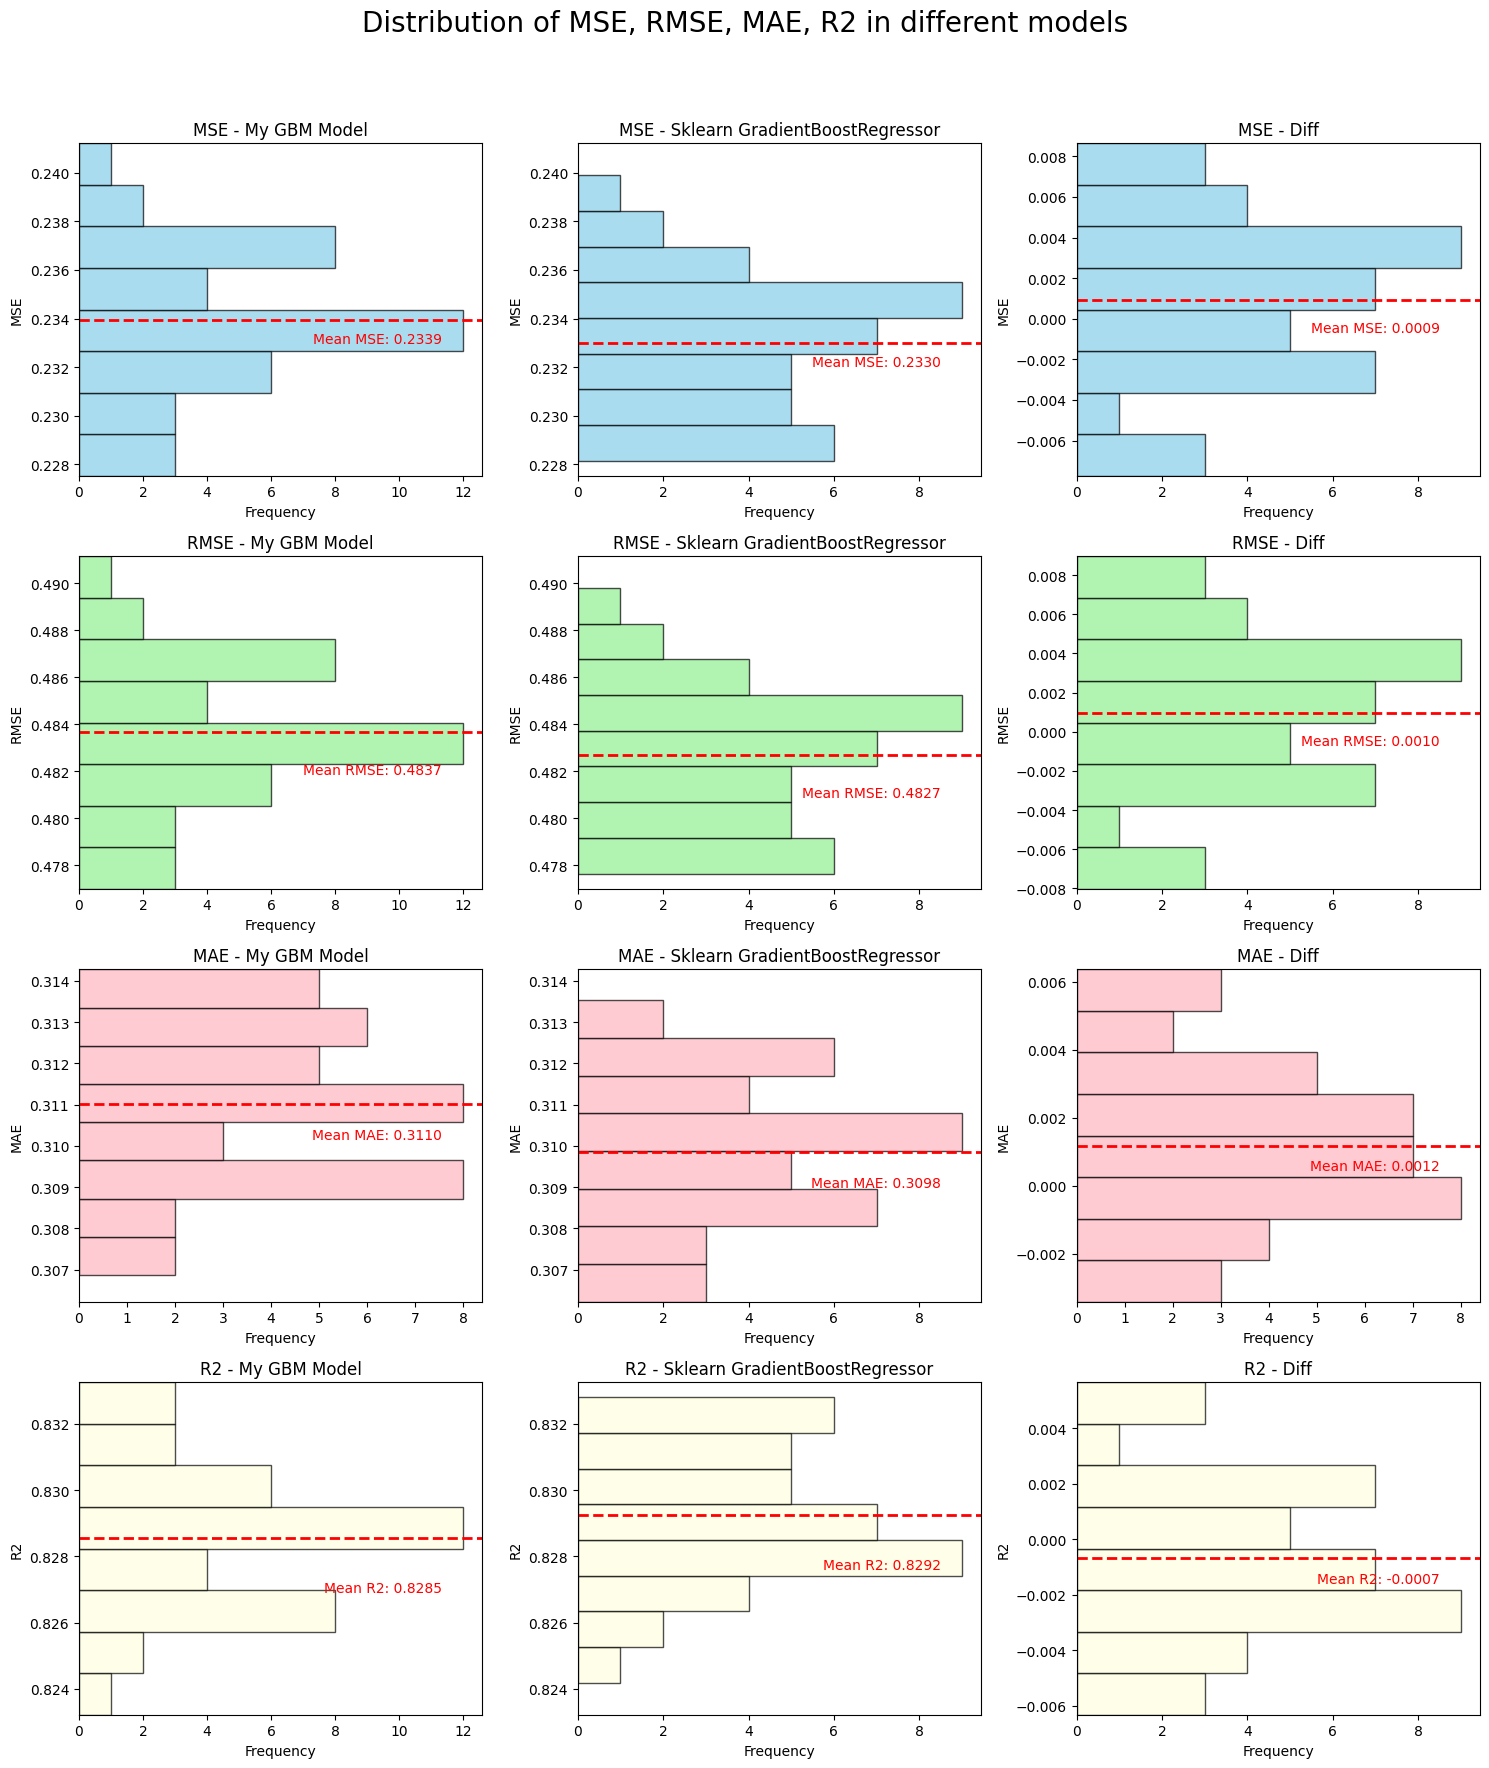

In [285]:
# Randomly split the dataset into 70% training, 30% test repeatedly and do the same task
# on the same data by two different models and see how results are distributed
# 

# Prepare to plot the chart
# 
# Names for two models
nsnames = ["My GBM Model", "Sklearn GradientBoostRegressor", "Diff"]

# Compute global y-axis limits for each metric.
# Note. I want to make the y-axis have the same limits for sub-plots.
mse_min = [np.min(arr) for arr in mse_scores]; mse_min[1] = min(mse_min[0], mse_min[1]); mse_min[0] = mse_min[1];
mse_max = [np.max(arr) for arr in mse_scores]; mse_max[1] = max(mse_max[0], mse_max[1]); mse_max[0] = mse_max[1];
rmse_min = [np.min(arr) for arr in rmse_scores]; rmse_min[1] = min(rmse_min[0], rmse_min[1]); rmse_min[0] = rmse_min[1];
rmse_max = [np.max(arr) for arr in rmse_scores]; rmse_max[1] = max(rmse_max[0], rmse_max[1]); rmse_max[0] = rmse_max[1];
mae_min = [np.min(arr) for arr in mae_scores]; mae_min[1] = min(mae_min[0], mae_min[1]); mae_min[0] = mae_min[1];
mae_max = [np.max(arr) for arr in mae_scores]; mae_max[1] = max(mae_max[0], mae_max[1]); mae_max[0] = mae_max[1];
r2_min = [np.min(arr) for arr in r2_scores]; r2_min[1] = min(r2_min[0], r2_min[1]); r2_min[0] = r2_min[1];
r2_max = [np.max(arr) for arr in r2_scores]; r2_max[1] = max(r2_max[0], r2_max[1]); r2_max[0] = r2_max[1];

# Create a figure with 4 rows and 3 columns.
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 18))
fig.suptitle('Distribution of MSE, RMSE, MAE, R2 in different models', fontsize=20)

# Plot horizontal histograms for each method.
for i, method in enumerate(nsnames):
    
    # Top row: MSE histograms, blue.
    data_mse = mse_scores[i]
    ax_mse = axes[0, i]
    counts, bins, patches = ax_mse.hist(data_mse, bins=8, orientation='horizontal',
                                        alpha=0.7, color='skyblue', edgecolor='black')
    mean_mse = np.mean(data_mse)
    ax_mse.axhline(mean_mse, color='red', linestyle='dashed', linewidth=2)
    xmax = ax_mse.get_xlim()[1]
    if i != 2:
        ax_mse.text(xmax * 0.9, mean_mse * 0.9966, f'Mean MSE: {mean_mse:.4f}', color='red', va='center', ha='right')
    else:
        ax_mse.text(xmax * 0.9, mean_mse * -0.5, f'Mean MSE: {mean_mse:.4f}', color='red', va='center', ha='right')
    ax_mse.set_title(f'MSE - {method}')
    ax_mse.set_xlabel('Frequency')
    ax_mse.set_ylabel('MSE')
    ax_mse.set_ylim(mse_min[i], mse_max[i])

    # Upper Middle row: RMSE score histograms, green.
    data_rmse = rmse_scores[i]
    ax_rmse = axes[1, i]
    counts, bins, patches = ax_rmse.hist(data_rmse, bins=8, orientation='horizontal',
                                         alpha=0.7, color='lightgreen', edgecolor='black')
    mean_rmse = np.mean(data_rmse)
    ax_rmse.axhline(mean_rmse, color='red', linestyle='dashed', linewidth=2)
    xmax = ax_rmse.get_xlim()[1]
    if i != 2:
        ax_rmse.text(xmax * 0.9, mean_rmse * 0.9966, f'Mean RMSE: {mean_rmse:.4f}', color='red', va='center', ha='right')
    else:
        ax_rmse.text(xmax * 0.9, mean_rmse * -0.5, f'Mean RMSE: {mean_rmse:.4f}', color='red', va='center', ha='right')
    ax_rmse.set_title(f'RMSE - {method}')
    ax_rmse.set_xlabel('Frequency')
    ax_rmse.set_ylabel('RMSE')
    ax_rmse.set_ylim(rmse_min[i], rmse_max[i])

    # Lower Middle row: MAE score histograms, pink.
    data_mae = mae_scores[i]
    ax_mae = axes[2, i]
    counts, bins, patches = ax_mae.hist(data_mae, bins=8, orientation='horizontal',
                                         alpha=0.7, color='lightpink', edgecolor='black')
    mean_mae = np.mean(data_mae)
    ax_mae.axhline(mean_mae, color='red', linestyle='dashed', linewidth=2)
    xmax = ax_mae.get_xlim()[1]
    if i != 2:
        ax_mae.text(xmax * 0.9, mean_mae * 0.9976, f'Mean MAE: {mean_mae:.4f}', color='red', va='center', ha='right')
    else:
        ax_mae.text(xmax * 0.9, mean_mae * 0.5, f'Mean MAE: {mean_mae:.4f}', color='red', va='center', ha='right')
    ax_mae.set_title(f'MAE - {method}')
    ax_mae.set_xlabel('Frequency')
    ax_mae.set_ylabel('MAE')
    ax_mae.set_ylim(mae_min[i], mae_max[i])

    # Bottom row: R2-Score score histograms, pink.
    data_r2 = r2_scores[i]
    ax_r2 = axes[3, i]
    counts, bins, patches = ax_r2.hist(data_r2, bins=8, orientation='horizontal',
                                         alpha=0.7, color='lightyellow', edgecolor='black')
    mean_r2 = np.mean(data_r2)
    ax_r2.axhline(mean_r2, color='red', linestyle='dashed', linewidth=2)
    xmax = ax_r2.get_xlim()[1]
    if i != 2:
        ax_r2.text(xmax * 0.9, mean_r2 * 0.9982, f'Mean R2: {mean_r2:.4f}', color='red', va='center', ha='right')
    else:
        ax_r2.text(xmax * 0.9, mean_r2 * 2.1, f'Mean R2: {mean_r2:.4f}', color='red', va='center', ha='right')
    ax_r2.set_title(f'R2 - {method}')
    ax_r2.set_xlabel('Frequency')
    ax_r2.set_ylabel('R2')
    ax_r2.set_ylim(r2_min[i], r2_max[i])

# Show the plot (5 * 3 sub-plot matrix).
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Short Comparision between implementations
# 
#                              RMSE       MAE        R^2
#  
# Sklearn Bench 50           0.4968    0.3251     0.8191
# Sklearn Bench 100          0.4872    0.3120     0.8260
# My GBM CART x5             0.7504    0.5758     0.5872
# My GBM CART x10            0.5936    0.4289     0.7418
# My GBM CART x20            0.5275    0.3530     0.7961 
# My GBM CART x50            0.4939    0.3245     0.8212
# My GBM CART x100           0.4779    0.3102     0.8327 
# * Comparable Logit Reg                          0.7296
#
#
#                    MSE       RMSE       MAE        R^2
# My GBM Mean     0.2339     0.4837    0.3110     0.8285
# Sklearn Mean    0.2330     0.4827    0.3098     0.8292
#
# Conclusion:
# > ⭐ Performance: My GBM implementation steadily closes the gap with scikit-learn’s reference model as
#   the number of boosting rounds grows. At 50–100 trees it matches—or even edges past—the sklearn benchmark.
#   Even though, on average, there is a tiny difference between my implementation and sklearn's, I believe it is just a noise,
#   because the difference is too small and it can generally be regarded as a comparable implementation having good performance.
# 
# > ⭐ Speed: Let's first talk about the absolute time cost. For 100 estimators, sklearn with C/C++ backend costs 34 seconds, and 
#   my pure-python implementation (yeah, I admit I used numpy, but the tree is implemented pure in Python) costs 16m 14seconds.
#   It's significantly slow, but not desperately a sloth. :) I have used a series of techniques to optimize including grid search
#   in constructing the tree. Let's blame this to Python again :)
#
# > Some kind notes. It is possible to use a non-CART weak learner in my GBM implementation, for example the LRTW (Linear Regression Tree Wrapper).
#   Even though I haven't done an extensive amount of tests, I have observed that it can be used as a weak learner in gradient boost models,
#   while the improvement in performance may not be that significant.


`End of Homework 3 Q2 by Nathmath Huang (bh2821)`